In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Data extraction and pre-processing

In [2]:
data = np.loadtxt('airfoil_self_noise.dat')
X    = data[:,:5]
Y    = data[:,5]

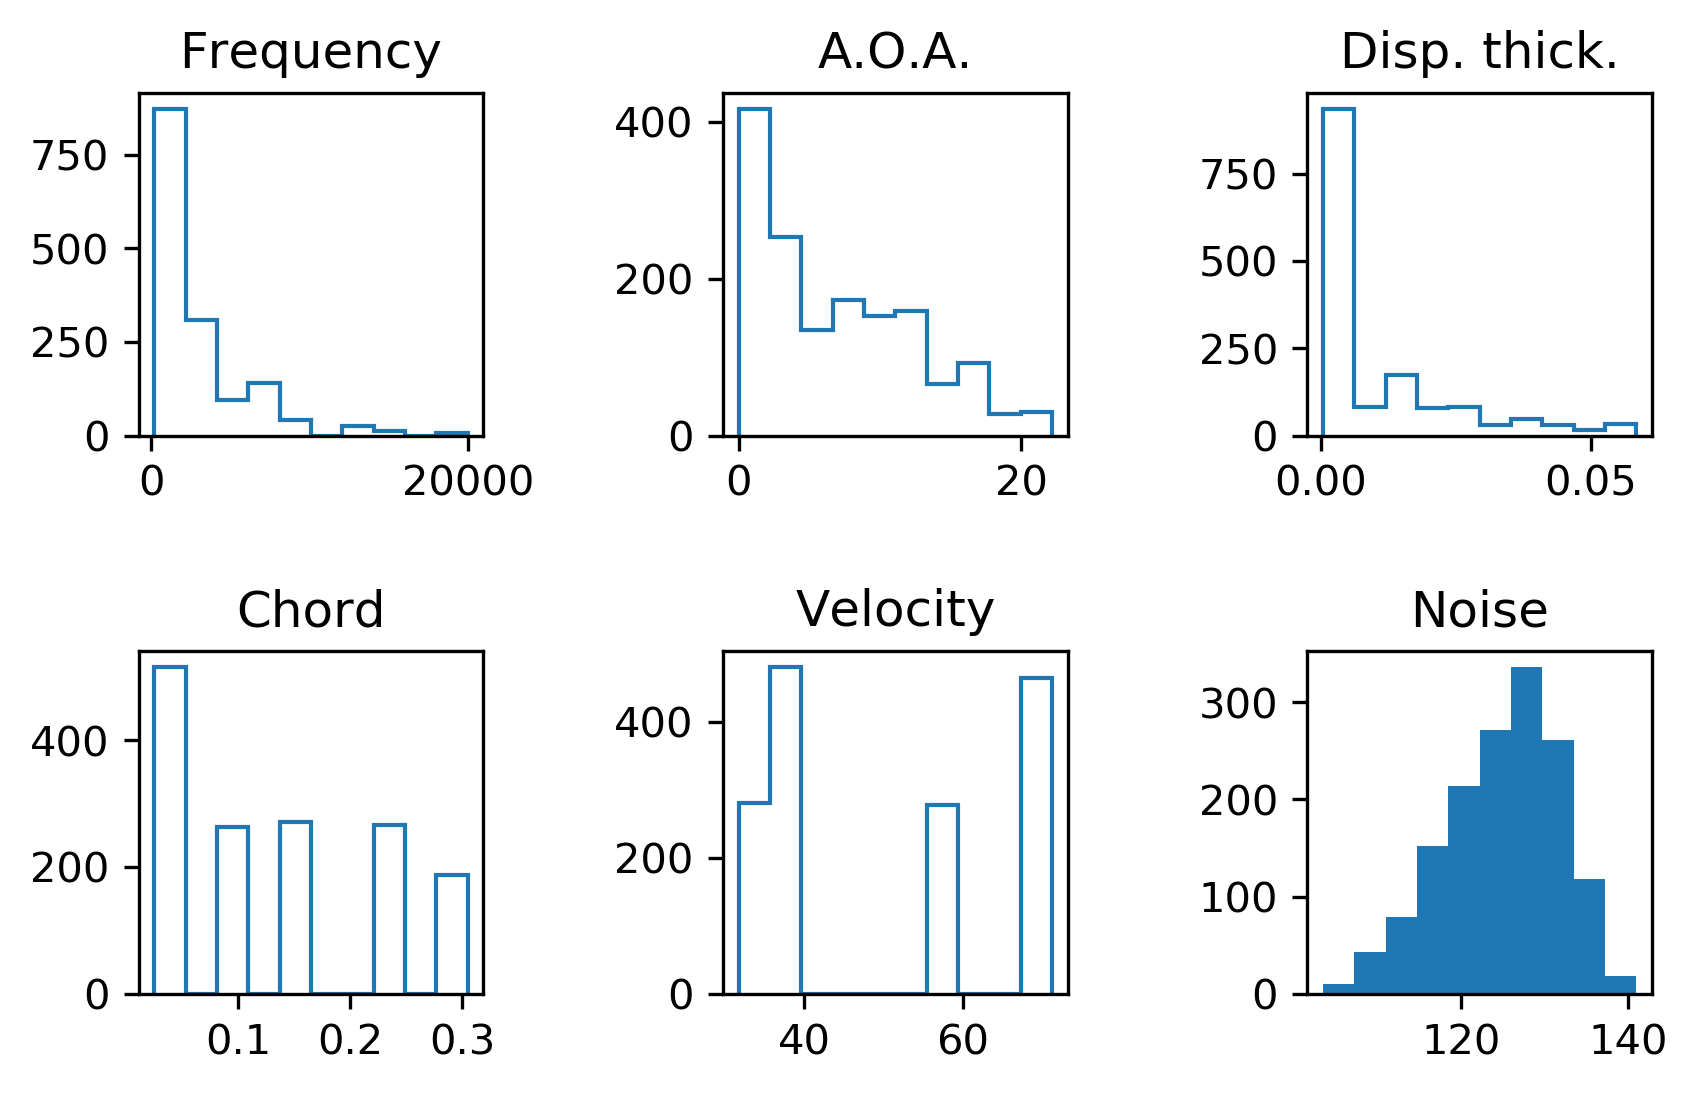

In [3]:
fig, axs = plt.subplots(2, 3,dpi=300)
axs[0, 0].hist(X[:,0],density=False,histtype='step')
axs[0, 0].set_title('Frequency')
axs[0, 1].hist(X[:,1],density=False,histtype='step')
axs[0, 1].set_title('A.O.A.')
axs[1, 0].hist(X[:,2],density=False,histtype='step')
axs[1, 0].set_title('Chord')
axs[1, 1].hist(X[:,3],density=False,histtype='step')
axs[1, 1].set_title('Velocity')
axs[0, 2].hist(X[:,4],density=False,histtype='step')
axs[0, 2].set_title('Disp. thick.')
axs[1, 2].hist(Y,density=False,histtype='stepfilled')
axs[1, 2].set_title('Noise')
fig.tight_layout(pad=2.0)
plt.savefig('data_dist.png', dpi=300)

In [4]:
# normalize data
std_X = np.std(X, 0)
std_X[std_X==0] = 1
mean_X = np.mean(X,0)
std_Y = np.std(Y,0)
mean_Y = np.mean(Y,0)
x_norm = (X - mean_X)/std_X #network input
y_norm = (Y - mean_Y)/std_Y 

## Set up neural network

In [5]:
def generate_model(input_dim, output_dim, n_layer, n_hidden,
                   optimizer_meth, act_fcn, learning_rate = 0.1, reg=0.0001):
    
    tf.random.set_seed(2020)
    keras.initializers.he_normal(seed=None)
    
    model = Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_dim))      # input layer

    for _ in range(n_layer-1):
        model.add(keras.layers.Dense(n_hidden, 
                                     activation=act_fcn,
                                     kernel_regularizer=regularizers.l2(reg)))
    
    model.add(keras.layers.Dense(output_dim, activation="linear")) # output layer

    model.summary()

    epochs = 150
    adam = optimizers.Adam(lr=learning_rate,decay=1e-2/epochs)
    
    model.compile(loss='mse', optimizer=adam, metrics=['mse'])
    return model

In [6]:
def train(model, x_norm, y_norm, batch_size, epochs, verbose=1, validation_split=.2):

    x_train, x_val, y_train, y_val = train_test_split(x_norm, y_norm, test_size=0.2)
    
    history = model.fit(x_train, y_train, epochs=epochs,
                        validation_data=(x_val, y_val), 
                        verbose=1)
    return history

## Hyperparameter tuning

In [99]:
# selecting number of layers 
levels  = 7
trainLoss = np.zeros(levels)
valLoss   = np.zeros(levels)
for _ in range(levels):
    model = generate_model(x_norm.shape[1], 1, _+1, 8, "adam", "relu", 0.001, 0.01)
    history     = train(model, x_norm, y_norm, 1, 2000, 1, .2)
    trainLoss[_]  = np.mean(history.history['loss'][-10:-1])
    valLoss[_]    = np.mean(history.history['val_loss'][-10:-1])

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 301 samples
Epoch 1/2000
1202/1202 [==============================] - 1s 473us/sample - loss: 5.3601 - mse: 5.3601 - val_loss: 4.9178 - val_mse: 4.9178
Epoch 2/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 4.9887 - mse: 4.9887 - val_loss: 4.5640 - val_mse: 4.5640
Epoch 3/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 4.6460 - mse: 4.6460 - val_loss: 4.2349 - val_mse: 4.2349
Epoch 4/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 4.3229 - mse: 4.3229 - val_loss: 3.9315 - val_mse: 3.9315
Epoch 5/2000
1202/1202 [=========================

Epoch 56/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.5297 - mse: 0.5297 - val_loss: 0.5065 - val_mse: 0.5065
Epoch 57/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.5264 - mse: 0.5264 - val_loss: 0.5041 - val_mse: 0.5041
Epoch 58/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.5235 - mse: 0.5235 - val_loss: 0.5016 - val_mse: 0.5016
Epoch 59/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.5210 - mse: 0.5210 - val_loss: 0.4996 - val_mse: 0.4996
Epoch 60/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4978 - val_mse: 0.4978
Epoch 61/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.5167 - mse: 0.5167 - val_loss: 0.4957 - val_mse: 0.4957
Epoch 62/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.5147 - mse: 0.5147 - val_loss: 0.4942 - val_mse: 0.4942
Epoch 63/2000
1202/1

1202/1202 [==============================] - 0s 92us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4698 - val_mse: 0.4698
Epoch 173/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4696 - val_mse: 0.4696
Epoch 174/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 175/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4700 - val_mse: 0.4700
Epoch 176/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 177/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 178/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 179/2000
1202/1202 [==

1202/1202 [==============================] - 0s 96us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 289/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 290/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4697 - val_mse: 0.4697
Epoch 291/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4699 - val_mse: 0.4699
Epoch 292/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4699 - val_mse: 0.4699
Epoch 293/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 294/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 295/2000
1202/1202 [==

1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 405/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 406/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4696 - val_mse: 0.4696
Epoch 407/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 408/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 409/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4696 - val_mse: 0.4696
Epoch 410/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 411/2000
1202/1202 [==

1202/1202 [==============================] - 0s 107us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 521/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 522/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 523/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4891 - mse: 0.4891 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 524/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4688 - val_mse: 0.4688
Epoch 525/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 526/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 527/2000
1202/1202 [

1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 579/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4688 - val_mse: 0.4688
Epoch 580/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4688 - val_mse: 0.4688
Epoch 581/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 582/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 583/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 584/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4890 - mse: 0.4890 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 585/2000
1202/1202 [==

1202/1202 [==============================] - 0s 94us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 695/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 696/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4688 - val_mse: 0.4688
Epoch 697/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 698/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 699/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 700/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 701/2000
1202/1202 [==

1202/1202 [==============================] - 0s 97us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 811/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 812/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 813/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 814/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 815/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 816/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 817/2000
1202/1202 [==

1202/1202 [==============================] - 0s 93us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 927/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 928/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 929/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 930/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 931/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 932/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 933/2000
1202/1202 [==

Epoch 1042/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1043/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 1044/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1045/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 1046/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 1047/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 1048/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4688 - val_mse: 0.4688
Epoch

Epoch 1157/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1158/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1159/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1160/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1161/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1162/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1163/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 

1202/1202 [==============================] - 0s 70us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1272/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4695 - val_mse: 0.4695
Epoch 1273/2000
1202/1202 [==============================] - 0s 152us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1274/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1275/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1276/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1277/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1278/2000
1202/

Epoch 1329/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1330/2000
1202/1202 [==============================] - 0s 67us/sample - loss: 0.4889 - mse: 0.4889 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1331/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1332/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1333/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 1334/2000
1202/1202 [==============================] - 0s 244us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1335/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoc

Epoch 1444/2000
1202/1202 [==============================] - 0s 159us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1445/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1446/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.4887 - mse: 0.4887 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1447/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 1448/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1449/2000
1202/1202 [==============================] - 0s 146us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1450/2000
1202/1202 [==============================] - 0s 147us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691


Epoch 1559/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1560/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1561/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1562/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1563/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1564/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 1565/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 

Epoch 1674/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1675/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1676/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1677/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1678/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1679/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1680/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4695 - val_mse: 0.4695
Epoc

Epoch 1789/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1790/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 1791/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1792/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1793/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.4887 - mse: 0.4887 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1794/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1795/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 

Epoch 1847/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1848/2000
1202/1202 [==============================] - 0s 69us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1849/2000
1202/1202 [==============================] - 0s 68us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1850/2000
1202/1202 [==============================] - 0s 69us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1851/2000
1202/1202 [==============================] - 0s 68us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4690 - val_mse: 0.4690
Epoch 1852/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1853/2000
1202/1202 [==============================] - 0s 69us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 

Epoch 1962/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4692 - val_mse: 0.4692
Epoch 1963/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1964/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1965/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1966/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4691 - val_mse: 0.4691
Epoch 1967/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 1968/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.4888 - mse: 0.4888 - val_loss: 0.4693 - val_mse: 0.4693
Epoch 

1202/1202 [==============================] - 0s 78us/sample - loss: 0.3262 - mse: 0.2945 - val_loss: 0.3532 - val_mse: 0.3217
Epoch 74/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.3250 - mse: 0.2935 - val_loss: 0.3529 - val_mse: 0.3215
Epoch 75/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.3245 - mse: 0.2930 - val_loss: 0.3536 - val_mse: 0.3222
Epoch 76/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.3233 - mse: 0.2919 - val_loss: 0.3523 - val_mse: 0.3211
Epoch 77/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.3233 - mse: 0.2920 - val_loss: 0.3526 - val_mse: 0.3214
Epoch 78/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.3227 - mse: 0.2916 - val_loss: 0.3482 - val_mse: 0.3171
Epoch 79/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.3226 - mse: 0.2915 - val_loss: 0.3489 - val_mse: 0.3179
Epoch 80/2000
1202/1202 [=========

Epoch 189/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2688 - mse: 0.2383 - val_loss: 0.2903 - val_mse: 0.2599
Epoch 190/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2683 - mse: 0.2379 - val_loss: 0.2905 - val_mse: 0.2601
Epoch 191/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2680 - mse: 0.2376 - val_loss: 0.2898 - val_mse: 0.2593
Epoch 192/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2686 - mse: 0.2381 - val_loss: 0.2899 - val_mse: 0.2595
Epoch 193/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.2681 - mse: 0.2377 - val_loss: 0.2883 - val_mse: 0.2579
Epoch 194/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2678 - mse: 0.2373 - val_loss: 0.2905 - val_mse: 0.2600
Epoch 195/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2678 - mse: 0.2373 - val_loss: 0.2896 - val_mse: 0.2591
Epoch 

Epoch 247/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2542 - mse: 0.2239 - val_loss: 0.2752 - val_mse: 0.2448
Epoch 248/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2534 - mse: 0.2231 - val_loss: 0.2747 - val_mse: 0.2444
Epoch 249/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2529 - mse: 0.2226 - val_loss: 0.2766 - val_mse: 0.2463
Epoch 250/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2534 - mse: 0.2230 - val_loss: 0.2770 - val_mse: 0.2466
Epoch 251/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2531 - mse: 0.2227 - val_loss: 0.2738 - val_mse: 0.2435
Epoch 252/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2531 - mse: 0.2228 - val_loss: 0.2738 - val_mse: 0.2435
Epoch 253/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2531 - mse: 0.2228 - val_loss: 0.2744 - val_mse: 0.2440
Epoch 

Epoch 305/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2400 - mse: 0.2094 - val_loss: 0.2624 - val_mse: 0.2318
Epoch 306/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2401 - mse: 0.2094 - val_loss: 0.2617 - val_mse: 0.2310
Epoch 307/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.2404 - mse: 0.2097 - val_loss: 0.2644 - val_mse: 0.2336
Epoch 308/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2398 - mse: 0.2091 - val_loss: 0.2590 - val_mse: 0.2283
Epoch 309/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2398 - mse: 0.2091 - val_loss: 0.2596 - val_mse: 0.2289
Epoch 310/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2391 - mse: 0.2084 - val_loss: 0.2614 - val_mse: 0.2306
Epoch 311/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.2393 - mse: 0.2086 - val_loss: 0.2628 - val_mse: 0.2321
Epoch 31

Epoch 363/2000
1202/1202 [==============================] - 0s 196us/sample - loss: 0.2279 - mse: 0.1969 - val_loss: 0.2515 - val_mse: 0.2205
Epoch 364/2000
1202/1202 [==============================] - 0s 161us/sample - loss: 0.2276 - mse: 0.1965 - val_loss: 0.2501 - val_mse: 0.2190
Epoch 365/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2272 - mse: 0.1962 - val_loss: 0.2502 - val_mse: 0.2192
Epoch 366/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2273 - mse: 0.1962 - val_loss: 0.2499 - val_mse: 0.2189
Epoch 367/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2267 - mse: 0.1956 - val_loss: 0.2505 - val_mse: 0.2195
Epoch 368/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.2267 - mse: 0.1957 - val_loss: 0.2505 - val_mse: 0.2194
Epoch 369/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2264 - mse: 0.1953 - val_loss: 0.2519 - val_mse: 0.2208
Epoch 

Epoch 421/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2179 - mse: 0.1862 - val_loss: 0.2430 - val_mse: 0.2113
Epoch 422/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2179 - mse: 0.1863 - val_loss: 0.2427 - val_mse: 0.2110
Epoch 423/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2177 - mse: 0.1861 - val_loss: 0.2445 - val_mse: 0.2128
Epoch 424/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2177 - mse: 0.1860 - val_loss: 0.2421 - val_mse: 0.2104
Epoch 425/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2178 - mse: 0.1861 - val_loss: 0.2418 - val_mse: 0.2101
Epoch 426/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.2172 - mse: 0.1855 - val_loss: 0.2430 - val_mse: 0.2113
Epoch 427/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2171 - mse: 0.1854 - val_loss: 0.2430 - val_mse: 0.2113
Epoch 

Epoch 479/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2108 - mse: 0.1784 - val_loss: 0.2398 - val_mse: 0.2074
Epoch 480/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2102 - mse: 0.1778 - val_loss: 0.2375 - val_mse: 0.2051
Epoch 481/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.2102 - mse: 0.1778 - val_loss: 0.2378 - val_mse: 0.2053
Epoch 482/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.2102 - mse: 0.1778 - val_loss: 0.2365 - val_mse: 0.2040
Epoch 483/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2099 - mse: 0.1774 - val_loss: 0.2382 - val_mse: 0.2058
Epoch 484/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2098 - mse: 0.1773 - val_loss: 0.2385 - val_mse: 0.2061
Epoch 485/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.2098 - mse: 0.1773 - val_loss: 0.2365 - val_mse: 0.2040
Epoch 48

Epoch 537/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2056 - mse: 0.1727 - val_loss: 0.2334 - val_mse: 0.2005
Epoch 538/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2049 - mse: 0.1720 - val_loss: 0.2352 - val_mse: 0.2023
Epoch 539/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2052 - mse: 0.1723 - val_loss: 0.2354 - val_mse: 0.2024
Epoch 540/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2055 - mse: 0.1726 - val_loss: 0.2375 - val_mse: 0.2045
Epoch 541/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2048 - mse: 0.1719 - val_loss: 0.2335 - val_mse: 0.2006
Epoch 542/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2053 - mse: 0.1724 - val_loss: 0.2331 - val_mse: 0.2002
Epoch 543/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2048 - mse: 0.1718 - val_loss: 0.2335 - val_mse: 0.2005
Epoch 

Epoch 595/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2021 - mse: 0.1689 - val_loss: 0.2320 - val_mse: 0.1989
Epoch 596/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2016 - mse: 0.1685 - val_loss: 0.2317 - val_mse: 0.1986
Epoch 597/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2015 - mse: 0.1684 - val_loss: 0.2326 - val_mse: 0.1995
Epoch 598/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2020 - mse: 0.1688 - val_loss: 0.2312 - val_mse: 0.1981
Epoch 599/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.2021 - mse: 0.1690 - val_loss: 0.2315 - val_mse: 0.1984
Epoch 600/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2013 - mse: 0.1682 - val_loss: 0.2310 - val_mse: 0.1979
Epoch 601/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2017 - mse: 0.1686 - val_loss: 0.2313 - val_mse: 0.1982
Epoch 6

Epoch 653/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1991 - mse: 0.1660 - val_loss: 0.2284 - val_mse: 0.1953
Epoch 654/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1991 - mse: 0.1660 - val_loss: 0.2299 - val_mse: 0.1969
Epoch 655/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1990 - mse: 0.1659 - val_loss: 0.2301 - val_mse: 0.1970
Epoch 656/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1987 - mse: 0.1657 - val_loss: 0.2292 - val_mse: 0.1962
Epoch 657/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1993 - mse: 0.1663 - val_loss: 0.2288 - val_mse: 0.1958
Epoch 658/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1991 - mse: 0.1660 - val_loss: 0.2306 - val_mse: 0.1976
Epoch 659/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1989 - mse: 0.1659 - val_loss: 0.2297 - val_mse: 0.1967
Epoch 6

Epoch 711/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1970 - mse: 0.1642 - val_loss: 0.2289 - val_mse: 0.1960
Epoch 712/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1970 - mse: 0.1642 - val_loss: 0.2289 - val_mse: 0.1961
Epoch 713/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1969 - mse: 0.1640 - val_loss: 0.2293 - val_mse: 0.1965
Epoch 714/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1976 - mse: 0.1648 - val_loss: 0.2307 - val_mse: 0.1979
Epoch 715/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1967 - mse: 0.1638 - val_loss: 0.2284 - val_mse: 0.1956
Epoch 716/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1971 - mse: 0.1643 - val_loss: 0.2299 - val_mse: 0.1971
Epoch 717/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1971 - mse: 0.1643 - val_loss: 0.2290 - val_mse: 0.1962
Epoch 718/2

Epoch 769/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1951 - mse: 0.1625 - val_loss: 0.2283 - val_mse: 0.1957
Epoch 770/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1954 - mse: 0.1628 - val_loss: 0.2276 - val_mse: 0.1950
Epoch 771/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1953 - mse: 0.1627 - val_loss: 0.2282 - val_mse: 0.1957
Epoch 772/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1949 - mse: 0.1624 - val_loss: 0.2287 - val_mse: 0.1962
Epoch 773/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1950 - mse: 0.1625 - val_loss: 0.2291 - val_mse: 0.1966
Epoch 774/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1956 - mse: 0.1631 - val_loss: 0.2279 - val_mse: 0.1954
Epoch 775/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1947 - mse: 0.1622 - val_loss: 0.2284 - val_mse: 0.1959
Epoch 776/2

Epoch 827/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1933 - mse: 0.1609 - val_loss: 0.2273 - val_mse: 0.1949
Epoch 828/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1932 - mse: 0.1609 - val_loss: 0.2279 - val_mse: 0.1956
Epoch 829/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1934 - mse: 0.1610 - val_loss: 0.2273 - val_mse: 0.1950
Epoch 830/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1935 - mse: 0.1611 - val_loss: 0.2273 - val_mse: 0.1949
Epoch 831/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1933 - mse: 0.1610 - val_loss: 0.2278 - val_mse: 0.1955
Epoch 832/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1931 - mse: 0.1607 - val_loss: 0.2274 - val_mse: 0.1951
Epoch 833/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1935 - mse: 0.1611 - val_loss: 0.2273 - val_mse: 0.1950
Epoch 834/

Epoch 885/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1920 - mse: 0.1598 - val_loss: 0.2269 - val_mse: 0.1948
Epoch 886/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1921 - mse: 0.1599 - val_loss: 0.2273 - val_mse: 0.1951
Epoch 887/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1921 - mse: 0.1599 - val_loss: 0.2282 - val_mse: 0.1960
Epoch 888/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1919 - mse: 0.1598 - val_loss: 0.2257 - val_mse: 0.1935
Epoch 889/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1918 - mse: 0.1597 - val_loss: 0.2275 - val_mse: 0.1953
Epoch 890/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1918 - mse: 0.1596 - val_loss: 0.2268 - val_mse: 0.1947
Epoch 891/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1920 - mse: 0.1599 - val_loss: 0.2276 - val_mse: 0.1955
Epoch 892/20

Epoch 943/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1904 - mse: 0.1584 - val_loss: 0.2266 - val_mse: 0.1947
Epoch 944/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1905 - mse: 0.1586 - val_loss: 0.2260 - val_mse: 0.1941
Epoch 945/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1906 - mse: 0.1587 - val_loss: 0.2246 - val_mse: 0.1926
Epoch 946/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1905 - mse: 0.1586 - val_loss: 0.2272 - val_mse: 0.1953
Epoch 947/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1905 - mse: 0.1586 - val_loss: 0.2264 - val_mse: 0.1945
Epoch 948/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1906 - mse: 0.1587 - val_loss: 0.2261 - val_mse: 0.1942
Epoch 949/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1903 - mse: 0.1584 - val_loss: 0.2265 - val_mse: 0.1946
Epoch 950/2

Epoch 1001/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1891 - mse: 0.1574 - val_loss: 0.2253 - val_mse: 0.1936
Epoch 1002/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1894 - mse: 0.1576 - val_loss: 0.2244 - val_mse: 0.1927
Epoch 1003/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1893 - mse: 0.1576 - val_loss: 0.2259 - val_mse: 0.1942
Epoch 1004/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1893 - mse: 0.1576 - val_loss: 0.2261 - val_mse: 0.1944
Epoch 1005/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1892 - mse: 0.1575 - val_loss: 0.2250 - val_mse: 0.1934
Epoch 1006/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1891 - mse: 0.1574 - val_loss: 0.2252 - val_mse: 0.1936
Epoch 1007/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1892 - mse: 0.1575 - val_loss: 0.2256 - val_mse: 0.1939
Epoch

Epoch 1116/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1873 - mse: 0.1562 - val_loss: 0.2247 - val_mse: 0.1936
Epoch 1117/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1874 - mse: 0.1562 - val_loss: 0.2252 - val_mse: 0.1940
Epoch 1118/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1870 - mse: 0.1558 - val_loss: 0.2237 - val_mse: 0.1925
Epoch 1119/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1871 - mse: 0.1560 - val_loss: 0.2239 - val_mse: 0.1927
Epoch 1120/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1869 - mse: 0.1558 - val_loss: 0.2224 - val_mse: 0.1913
Epoch 1121/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1870 - mse: 0.1558 - val_loss: 0.2229 - val_mse: 0.1918
Epoch 1122/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1869 - mse: 0.1557 - val_loss: 0.2234 - val_mse: 0.1922
Epo

1202/1202 [==============================] - 0s 97us/sample - loss: 0.1856 - mse: 0.1549 - val_loss: 0.2214 - val_mse: 0.1906
Epoch 1231/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1857 - mse: 0.1550 - val_loss: 0.2218 - val_mse: 0.1910
Epoch 1232/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.1853 - mse: 0.1546 - val_loss: 0.2215 - val_mse: 0.1907
Epoch 1233/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1854 - mse: 0.1546 - val_loss: 0.2215 - val_mse: 0.1908
Epoch 1234/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1853 - mse: 0.1546 - val_loss: 0.2216 - val_mse: 0.1909
Epoch 1235/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1855 - mse: 0.1548 - val_loss: 0.2208 - val_mse: 0.1900
Epoch 1236/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1852 - mse: 0.1545 - val_loss: 0.2222 - val_mse: 0.1915
Epoch 1237/2000
12

Epoch 1345/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1842 - mse: 0.1539 - val_loss: 0.2205 - val_mse: 0.1902
Epoch 1346/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1841 - mse: 0.1539 - val_loss: 0.2192 - val_mse: 0.1890
Epoch 1347/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1838 - mse: 0.1535 - val_loss: 0.2215 - val_mse: 0.1912
Epoch 1348/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1836 - mse: 0.1534 - val_loss: 0.2197 - val_mse: 0.1895
Epoch 1349/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1840 - mse: 0.1537 - val_loss: 0.2195 - val_mse: 0.1893
Epoch 1350/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1837 - mse: 0.1535 - val_loss: 0.2213 - val_mse: 0.1911
Epoch 1351/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1840 - mse: 0.1537 - val_loss: 0.2207 - val_mse: 0.1904
Epoch 

Epoch 1403/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1830 - mse: 0.1530 - val_loss: 0.2191 - val_mse: 0.1890
Epoch 1404/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1838 - mse: 0.1537 - val_loss: 0.2204 - val_mse: 0.1904
Epoch 1405/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1833 - mse: 0.1532 - val_loss: 0.2199 - val_mse: 0.1899
Epoch 1406/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1833 - mse: 0.1532 - val_loss: 0.2193 - val_mse: 0.1893
Epoch 1407/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1832 - mse: 0.1532 - val_loss: 0.2184 - val_mse: 0.1884
Epoch 1408/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1832 - mse: 0.1531 - val_loss: 0.2198 - val_mse: 0.1897
Epoch 1409/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1835 - mse: 0.1534 - val_loss: 0.2189 - val_mse: 0.1889
Epoch 

Epoch 1461/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1830 - mse: 0.1531 - val_loss: 0.2184 - val_mse: 0.1885
Epoch 1462/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1824 - mse: 0.1525 - val_loss: 0.2181 - val_mse: 0.1882
Epoch 1463/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1823 - mse: 0.1525 - val_loss: 0.2180 - val_mse: 0.1881
Epoch 1464/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1823 - mse: 0.1524 - val_loss: 0.2188 - val_mse: 0.1889
Epoch 1465/2000
1202/1202 [==============================] - 0s 69us/sample - loss: 0.1824 - mse: 0.1525 - val_loss: 0.2183 - val_mse: 0.1884
Epoch 1466/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1823 - mse: 0.1525 - val_loss: 0.2177 - val_mse: 0.1878
Epoch 1467/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1824 - mse: 0.1526 - val_loss: 0.2181 - val_mse: 0.1882
Epoch 

Epoch 1519/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1817 - mse: 0.1519 - val_loss: 0.2159 - val_mse: 0.1862
Epoch 1520/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1816 - mse: 0.1519 - val_loss: 0.2170 - val_mse: 0.1873
Epoch 1521/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1817 - mse: 0.1519 - val_loss: 0.2170 - val_mse: 0.1873
Epoch 1522/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1816 - mse: 0.1518 - val_loss: 0.2166 - val_mse: 0.1869
Epoch 1523/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1815 - mse: 0.1517 - val_loss: 0.2160 - val_mse: 0.1863
Epoch 1524/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1814 - mse: 0.1517 - val_loss: 0.2162 - val_mse: 0.1864
Epoch 1525/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1816 - mse: 0.1519 - val_loss: 0.2169 - val_mse: 0.1872
Epoch 

Epoch 1577/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1808 - mse: 0.1512 - val_loss: 0.2162 - val_mse: 0.1866
Epoch 1578/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1809 - mse: 0.1513 - val_loss: 0.2160 - val_mse: 0.1864
Epoch 1579/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1809 - mse: 0.1513 - val_loss: 0.2160 - val_mse: 0.1864
Epoch 1580/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1809 - mse: 0.1513 - val_loss: 0.2158 - val_mse: 0.1862
Epoch 1581/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1807 - mse: 0.1511 - val_loss: 0.2167 - val_mse: 0.1871
Epoch 1582/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1812 - mse: 0.1516 - val_loss: 0.2175 - val_mse: 0.1879
Epoch 1583/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1807 - mse: 0.1511 - val_loss: 0.2159 - val_mse: 0.1863
Epoch 

Epoch 1635/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1808 - mse: 0.1513 - val_loss: 0.2164 - val_mse: 0.1870
Epoch 1636/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1802 - mse: 0.1507 - val_loss: 0.2156 - val_mse: 0.1861
Epoch 1637/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1804 - mse: 0.1509 - val_loss: 0.2161 - val_mse: 0.1867
Epoch 1638/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1806 - mse: 0.1511 - val_loss: 0.2155 - val_mse: 0.1860
Epoch 1639/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1802 - mse: 0.1507 - val_loss: 0.2163 - val_mse: 0.1868
Epoch 1640/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1802 - mse: 0.1507 - val_loss: 0.2157 - val_mse: 0.1862
Epoch 1641/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1803 - mse: 0.1509 - val_loss: 0.2156 - val_mse: 0.1862
Epoch 

Epoch 1693/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1797 - mse: 0.1504 - val_loss: 0.2148 - val_mse: 0.1855
Epoch 1694/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1798 - mse: 0.1505 - val_loss: 0.2152 - val_mse: 0.1859
Epoch 1695/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1800 - mse: 0.1507 - val_loss: 0.2149 - val_mse: 0.1857
Epoch 1696/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1797 - mse: 0.1504 - val_loss: 0.2157 - val_mse: 0.1864
Epoch 1697/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1797 - mse: 0.1504 - val_loss: 0.2141 - val_mse: 0.1848
Epoch 1698/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1796 - mse: 0.1503 - val_loss: 0.2151 - val_mse: 0.1858
Epoch 1699/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1797 - mse: 0.1504 - val_loss: 0.2157 - val_mse: 0.1865
Epoch 

Epoch 1751/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1789 - mse: 0.1497 - val_loss: 0.2141 - val_mse: 0.1849
Epoch 1752/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1789 - mse: 0.1497 - val_loss: 0.2150 - val_mse: 0.1858
Epoch 1753/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1788 - mse: 0.1496 - val_loss: 0.2145 - val_mse: 0.1853
Epoch 1754/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1789 - mse: 0.1497 - val_loss: 0.2140 - val_mse: 0.1848
Epoch 1755/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1789 - mse: 0.1497 - val_loss: 0.2147 - val_mse: 0.1855
Epoch 1756/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1788 - mse: 0.1496 - val_loss: 0.2145 - val_mse: 0.1854
Epoch 1757/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1784 - mse: 0.1493 - val_loss: 0.2152 - val_mse: 0.1861
Epoch 

Epoch 1809/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1780 - mse: 0.1489 - val_loss: 0.2139 - val_mse: 0.1848
Epoch 1810/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1781 - mse: 0.1490 - val_loss: 0.2138 - val_mse: 0.1847
Epoch 1811/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1780 - mse: 0.1489 - val_loss: 0.2130 - val_mse: 0.1839
Epoch 1812/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1781 - mse: 0.1490 - val_loss: 0.2138 - val_mse: 0.1847
Epoch 1813/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1778 - mse: 0.1488 - val_loss: 0.2143 - val_mse: 0.1852
Epoch 1814/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1780 - mse: 0.1489 - val_loss: 0.2136 - val_mse: 0.1846
Epoch 1815/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1778 - mse: 0.1487 - val_loss: 0.2143 - val_mse: 0.1852
Epoch 

Epoch 1867/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1772 - mse: 0.1483 - val_loss: 0.2144 - val_mse: 0.1854
Epoch 1868/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.1771 - mse: 0.1482 - val_loss: 0.2143 - val_mse: 0.1853
Epoch 1869/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1775 - mse: 0.1486 - val_loss: 0.2138 - val_mse: 0.1848
Epoch 1870/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.1772 - mse: 0.1483 - val_loss: 0.2138 - val_mse: 0.1848
Epoch 1871/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1772 - mse: 0.1483 - val_loss: 0.2143 - val_mse: 0.1853
Epoch 1872/2000
1202/1202 [==============================] - 0s 70us/sample - loss: 0.1772 - mse: 0.1482 - val_loss: 0.2147 - val_mse: 0.1857
Epoch 1873/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1770 - mse: 0.1481 - val_loss: 0.2143 - val_mse: 0.1854
Epoch 

Epoch 1925/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1764 - mse: 0.1476 - val_loss: 0.2124 - val_mse: 0.1836
Epoch 1926/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1770 - mse: 0.1482 - val_loss: 0.2119 - val_mse: 0.1831
Epoch 1927/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1765 - mse: 0.1477 - val_loss: 0.2133 - val_mse: 0.1844
Epoch 1928/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1765 - mse: 0.1477 - val_loss: 0.2124 - val_mse: 0.1836
Epoch 1929/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1764 - mse: 0.1476 - val_loss: 0.2122 - val_mse: 0.1834
Epoch 1930/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1764 - mse: 0.1476 - val_loss: 0.2124 - val_mse: 0.1836
Epoch 1931/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1766 - mse: 0.1478 - val_loss: 0.2125 - val_mse: 0.1837
Epoch 

Epoch 1983/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1760 - mse: 0.1473 - val_loss: 0.2113 - val_mse: 0.1826
Epoch 1984/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1759 - mse: 0.1472 - val_loss: 0.2122 - val_mse: 0.1835
Epoch 1985/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1761 - mse: 0.1474 - val_loss: 0.2120 - val_mse: 0.1833
Epoch 1986/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1761 - mse: 0.1473 - val_loss: 0.2116 - val_mse: 0.1829
Epoch 1987/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1760 - mse: 0.1473 - val_loss: 0.2123 - val_mse: 0.1835
Epoch 1988/2000
1202/1202 [==============================] - 0s 72us/sample - loss: 0.1761 - mse: 0.1473 - val_loss: 0.2119 - val_mse: 0.1832
Epoch 1989/2000
1202/1202 [==============================] - 0s 71us/sample - loss: 0.1761 - mse: 0.1474 - val_loss: 0.2115 - val_mse: 0.1828
Epoch 

1202/1202 [==============================] - 0s 75us/sample - loss: 0.2797 - mse: 0.2093 - val_loss: 0.3066 - val_mse: 0.2363
Epoch 94/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.2790 - mse: 0.2087 - val_loss: 0.3052 - val_mse: 0.2351
Epoch 95/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2781 - mse: 0.2081 - val_loss: 0.3047 - val_mse: 0.2348
Epoch 96/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.2771 - mse: 0.2073 - val_loss: 0.3034 - val_mse: 0.2337
Epoch 97/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2754 - mse: 0.2058 - val_loss: 0.3006 - val_mse: 0.2312
Epoch 98/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2753 - mse: 0.2060 - val_loss: 0.3026 - val_mse: 0.2335
Epoch 99/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2742 - mse: 0.2052 - val_loss: 0.3009 - val_mse: 0.2320
Epoch 100/2000
1202/1202 [========

1202/1202 [==============================] - 0s 75us/sample - loss: 0.2270 - mse: 0.1675 - val_loss: 0.2510 - val_mse: 0.1915
Epoch 210/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.2256 - mse: 0.1661 - val_loss: 0.2512 - val_mse: 0.1917
Epoch 211/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2253 - mse: 0.1659 - val_loss: 0.2522 - val_mse: 0.1929
Epoch 212/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.2251 - mse: 0.1658 - val_loss: 0.2540 - val_mse: 0.1947
Epoch 213/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2254 - mse: 0.1661 - val_loss: 0.2504 - val_mse: 0.1911
Epoch 214/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2256 - mse: 0.1664 - val_loss: 0.2497 - val_mse: 0.1904
Epoch 215/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2250 - mse: 0.1658 - val_loss: 0.2493 - val_mse: 0.1900
Epoch 216/2000
1202/1202 [==

1202/1202 [==============================] - 0s 76us/sample - loss: 0.2029 - mse: 0.1443 - val_loss: 0.2313 - val_mse: 0.1726
Epoch 326/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2036 - mse: 0.1449 - val_loss: 0.2371 - val_mse: 0.1785
Epoch 327/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.2044 - mse: 0.1456 - val_loss: 0.2353 - val_mse: 0.1766
Epoch 328/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.2036 - mse: 0.1449 - val_loss: 0.2311 - val_mse: 0.1724
Epoch 329/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.2022 - mse: 0.1434 - val_loss: 0.2324 - val_mse: 0.1736
Epoch 330/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.2024 - mse: 0.1436 - val_loss: 0.2339 - val_mse: 0.1752
Epoch 331/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.2039 - mse: 0.1452 - val_loss: 0.2351 - val_mse: 0.1764
Epoch 332/2000
1202/1202 [==

1202/1202 [==============================] - 0s 74us/sample - loss: 0.1912 - mse: 0.1330 - val_loss: 0.2258 - val_mse: 0.1676
Epoch 442/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1917 - mse: 0.1335 - val_loss: 0.2240 - val_mse: 0.1659
Epoch 443/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1911 - mse: 0.1330 - val_loss: 0.2237 - val_mse: 0.1655
Epoch 444/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1922 - mse: 0.1340 - val_loss: 0.2246 - val_mse: 0.1664
Epoch 445/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1918 - mse: 0.1337 - val_loss: 0.2232 - val_mse: 0.1651
Epoch 446/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1905 - mse: 0.1324 - val_loss: 0.2243 - val_mse: 0.1662
Epoch 447/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1914 - mse: 0.1333 - val_loss: 0.2249 - val_mse: 0.1668
Epoch 448/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.1822 - mse: 0.1246 - val_loss: 0.2172 - val_mse: 0.1596
Epoch 558/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1830 - mse: 0.1254 - val_loss: 0.2146 - val_mse: 0.1569
Epoch 559/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1830 - mse: 0.1254 - val_loss: 0.2173 - val_mse: 0.1597
Epoch 560/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1819 - mse: 0.1243 - val_loss: 0.2153 - val_mse: 0.1577
Epoch 561/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1822 - mse: 0.1245 - val_loss: 0.2159 - val_mse: 0.1582
Epoch 562/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1822 - mse: 0.1246 - val_loss: 0.2157 - val_mse: 0.1581
Epoch 563/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1818 - mse: 0.1242 - val_loss: 0.2153 - val_mse: 0.1577
Epoch 564/2000
1202/1202 [==

1202/1202 [==============================] - 0s 74us/sample - loss: 0.1752 - mse: 0.1185 - val_loss: 0.2064 - val_mse: 0.1497
Epoch 674/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1751 - mse: 0.1184 - val_loss: 0.2073 - val_mse: 0.1506
Epoch 675/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1752 - mse: 0.1185 - val_loss: 0.2095 - val_mse: 0.1528
Epoch 676/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1751 - mse: 0.1184 - val_loss: 0.2065 - val_mse: 0.1497
Epoch 677/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1759 - mse: 0.1192 - val_loss: 0.2068 - val_mse: 0.1500
Epoch 678/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1761 - mse: 0.1194 - val_loss: 0.2067 - val_mse: 0.1500
Epoch 679/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1753 - mse: 0.1187 - val_loss: 0.2066 - val_mse: 0.1499
Epoch 680/2000
1202/1202 [==

1202/1202 [==============================] - 0s 74us/sample - loss: 0.1737 - mse: 0.1180 - val_loss: 0.2036 - val_mse: 0.1478
Epoch 790/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1726 - mse: 0.1169 - val_loss: 0.2010 - val_mse: 0.1454
Epoch 791/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1714 - mse: 0.1157 - val_loss: 0.2046 - val_mse: 0.1490
Epoch 792/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1708 - mse: 0.1151 - val_loss: 0.2010 - val_mse: 0.1453
Epoch 793/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1707 - mse: 0.1150 - val_loss: 0.2019 - val_mse: 0.1462
Epoch 794/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1703 - mse: 0.1146 - val_loss: 0.2000 - val_mse: 0.1443
Epoch 795/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1706 - mse: 0.1150 - val_loss: 0.2033 - val_mse: 0.1477
Epoch 796/2000
1202/1202 [==

1202/1202 [==============================] - 0s 75us/sample - loss: 0.1674 - mse: 0.1128 - val_loss: 0.1958 - val_mse: 0.1412
Epoch 906/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1666 - mse: 0.1120 - val_loss: 0.1971 - val_mse: 0.1425
Epoch 907/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1675 - mse: 0.1129 - val_loss: 0.1983 - val_mse: 0.1437
Epoch 908/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1673 - mse: 0.1127 - val_loss: 0.1963 - val_mse: 0.1417
Epoch 909/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1679 - mse: 0.1133 - val_loss: 0.1962 - val_mse: 0.1416
Epoch 910/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1670 - mse: 0.1125 - val_loss: 0.1964 - val_mse: 0.1418
Epoch 911/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1668 - mse: 0.1122 - val_loss: 0.1968 - val_mse: 0.1422
Epoch 912/2000
1202/1202 [==

1202/1202 [==============================] - 0s 75us/sample - loss: 0.1651 - mse: 0.1114 - val_loss: 0.1927 - val_mse: 0.1391
Epoch 1022/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1643 - mse: 0.1107 - val_loss: 0.1903 - val_mse: 0.1367
Epoch 1023/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1641 - mse: 0.1105 - val_loss: 0.1938 - val_mse: 0.1401
Epoch 1024/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1643 - mse: 0.1107 - val_loss: 0.1908 - val_mse: 0.1372
Epoch 1025/2000
1202/1202 [==============================] - 0s 75us/sample - loss: 0.1641 - mse: 0.1105 - val_loss: 0.1908 - val_mse: 0.1373
Epoch 1026/2000
1202/1202 [==============================] - 0s 73us/sample - loss: 0.1646 - mse: 0.1111 - val_loss: 0.1911 - val_mse: 0.1375
Epoch 1027/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1643 - mse: 0.1107 - val_loss: 0.1905 - val_mse: 0.1369
Epoch 1028/2000
1202/1

Epoch 1079/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1627 - mse: 0.1095 - val_loss: 0.1892 - val_mse: 0.1360
Epoch 1080/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1637 - mse: 0.1105 - val_loss: 0.1898 - val_mse: 0.1366
Epoch 1081/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1631 - mse: 0.1099 - val_loss: 0.1891 - val_mse: 0.1359
Epoch 1082/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1629 - mse: 0.1097 - val_loss: 0.1892 - val_mse: 0.1360
Epoch 1083/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1628 - mse: 0.1097 - val_loss: 0.1905 - val_mse: 0.1373
Epoch 1084/2000
1202/1202 [==============================] - 0s 74us/sample - loss: 0.1633 - mse: 0.1102 - val_loss: 0.1910 - val_mse: 0.1378
Epoch 1085/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.1625 - mse: 0.1093 - val_loss: 0.1897 - val_mse: 0.1366
Epoch 

1202/1202 [==============================] - 0s 106us/sample - loss: 0.1605 - mse: 0.1082 - val_loss: 0.1860 - val_mse: 0.1337
Epoch 1194/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1607 - mse: 0.1083 - val_loss: 0.1878 - val_mse: 0.1354
Epoch 1195/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1605 - mse: 0.1082 - val_loss: 0.1876 - val_mse: 0.1353
Epoch 1196/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1606 - mse: 0.1082 - val_loss: 0.1860 - val_mse: 0.1337
Epoch 1197/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1610 - mse: 0.1086 - val_loss: 0.1899 - val_mse: 0.1375
Epoch 1198/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1611 - mse: 0.1088 - val_loss: 0.1875 - val_mse: 0.1352
Epoch 1199/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1615 - mse: 0.1091 - val_loss: 0.1868 - val_mse: 0.1345
Epoch 1200/2000
1

1202/1202 [==============================] - 0s 96us/sample - loss: 0.1593 - mse: 0.1078 - val_loss: 0.1854 - val_mse: 0.1339
Epoch 1308/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1595 - mse: 0.1079 - val_loss: 0.1849 - val_mse: 0.1333
Epoch 1309/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1595 - mse: 0.1080 - val_loss: 0.1862 - val_mse: 0.1347
Epoch 1310/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1586 - mse: 0.1071 - val_loss: 0.1854 - val_mse: 0.1339
Epoch 1311/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1595 - mse: 0.1080 - val_loss: 0.1862 - val_mse: 0.1347
Epoch 1312/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1590 - mse: 0.1075 - val_loss: 0.1860 - val_mse: 0.1346
Epoch 1313/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1586 - mse: 0.1071 - val_loss: 0.1846 - val_mse: 0.1331
Epoch 1314/2000
1

1202/1202 [==============================] - 0s 104us/sample - loss: 0.1573 - mse: 0.1065 - val_loss: 0.1823 - val_mse: 0.1315
Epoch 1422/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1572 - mse: 0.1065 - val_loss: 0.1840 - val_mse: 0.1332
Epoch 1423/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1573 - mse: 0.1066 - val_loss: 0.1832 - val_mse: 0.1325
Epoch 1424/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1573 - mse: 0.1066 - val_loss: 0.1825 - val_mse: 0.1317
Epoch 1425/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1581 - mse: 0.1073 - val_loss: 0.1845 - val_mse: 0.1338
Epoch 1426/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1574 - mse: 0.1067 - val_loss: 0.1829 - val_mse: 0.1322
Epoch 1427/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1580 - mse: 0.1073 - val_loss: 0.1827 - val_mse: 0.1320
Epoch 1428/2000

1202/1202 [==============================] - 0s 101us/sample - loss: 0.1561 - mse: 0.1061 - val_loss: 0.1813 - val_mse: 0.1313
Epoch 1536/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1559 - mse: 0.1059 - val_loss: 0.1810 - val_mse: 0.1310
Epoch 1537/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1562 - mse: 0.1062 - val_loss: 0.1809 - val_mse: 0.1309
Epoch 1538/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1563 - mse: 0.1063 - val_loss: 0.1807 - val_mse: 0.1307
Epoch 1539/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1559 - mse: 0.1059 - val_loss: 0.1813 - val_mse: 0.1313
Epoch 1540/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1556 - mse: 0.1055 - val_loss: 0.1827 - val_mse: 0.1327
Epoch 1541/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1559 - mse: 0.1059 - val_loss: 0.1812 - val_mse: 0.1312
Epoch 1542/2000
1

1202/1202 [==============================] - 0s 100us/sample - loss: 0.1554 - mse: 0.1061 - val_loss: 0.1805 - val_mse: 0.1312
Epoch 1650/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1544 - mse: 0.1050 - val_loss: 0.1801 - val_mse: 0.1308
Epoch 1651/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1554 - mse: 0.1061 - val_loss: 0.1811 - val_mse: 0.1318
Epoch 1652/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1549 - mse: 0.1056 - val_loss: 0.1803 - val_mse: 0.1310
Epoch 1653/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1549 - mse: 0.1056 - val_loss: 0.1827 - val_mse: 0.1334
Epoch 1654/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1556 - mse: 0.1063 - val_loss: 0.1814 - val_mse: 0.1321
Epoch 1655/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1551 - mse: 0.1058 - val_loss: 0.1815 - val_mse: 0.1322
Epoch 1656/2000
12

1202/1202 [==============================] - 0s 94us/sample - loss: 0.1533 - mse: 0.1046 - val_loss: 0.1802 - val_mse: 0.1315
Epoch 1764/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1533 - mse: 0.1046 - val_loss: 0.1786 - val_mse: 0.1299
Epoch 1765/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1535 - mse: 0.1048 - val_loss: 0.1780 - val_mse: 0.1293
Epoch 1766/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1537 - mse: 0.1051 - val_loss: 0.1789 - val_mse: 0.1303
Epoch 1767/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1533 - mse: 0.1047 - val_loss: 0.1784 - val_mse: 0.1298
Epoch 1768/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1533 - mse: 0.1047 - val_loss: 0.1797 - val_mse: 0.1311
Epoch 1769/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1542 - mse: 0.1056 - val_loss: 0.1790 - val_mse: 0.1304
Epoch 1770/2000
1

1202/1202 [==============================] - 0s 104us/sample - loss: 0.1528 - mse: 0.1046 - val_loss: 0.1770 - val_mse: 0.1288
Epoch 1878/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1522 - mse: 0.1040 - val_loss: 0.1756 - val_mse: 0.1274
Epoch 1879/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1524 - mse: 0.1042 - val_loss: 0.1768 - val_mse: 0.1286
Epoch 1880/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1522 - mse: 0.1040 - val_loss: 0.1768 - val_mse: 0.1287
Epoch 1881/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1522 - mse: 0.1040 - val_loss: 0.1766 - val_mse: 0.1285
Epoch 1882/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1526 - mse: 0.1045 - val_loss: 0.1771 - val_mse: 0.1290
Epoch 1883/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1522 - mse: 0.1040 - val_loss: 0.1760 - val_mse: 0.1279
Epoch 1884/2000
1

1202/1202 [==============================] - 0s 105us/sample - loss: 0.1514 - mse: 0.1035 - val_loss: 0.1752 - val_mse: 0.1274
Epoch 1992/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1515 - mse: 0.1037 - val_loss: 0.1747 - val_mse: 0.1269
Epoch 1993/2000
1202/1202 [==============================] - 0s 125us/sample - loss: 0.1507 - mse: 0.1029 - val_loss: 0.1759 - val_mse: 0.1281
Epoch 1994/2000
1202/1202 [==============================] - 0s 132us/sample - loss: 0.1510 - mse: 0.1032 - val_loss: 0.1756 - val_mse: 0.1278
Epoch 1995/2000
1202/1202 [==============================] - 0s 131us/sample - loss: 0.1510 - mse: 0.1032 - val_loss: 0.1762 - val_mse: 0.1284
Epoch 1996/2000
1202/1202 [==============================] - 0s 134us/sample - loss: 0.1516 - mse: 0.1038 - val_loss: 0.1760 - val_mse: 0.1282
Epoch 1997/2000
1202/1202 [==============================] - 0s 140us/sample - loss: 0.1512 - mse: 0.1034 - val_loss: 0.1743 - val_mse: 0.1265
Epoch 1998/2000

Epoch 43/2000
1202/1202 [==============================] - 0s 249us/sample - loss: 0.3809 - mse: 0.2808 - val_loss: 0.3535 - val_mse: 0.2535
Epoch 44/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.3772 - mse: 0.2774 - val_loss: 0.3509 - val_mse: 0.2514
Epoch 45/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.3735 - mse: 0.2741 - val_loss: 0.3583 - val_mse: 0.2591
Epoch 46/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.3734 - mse: 0.2742 - val_loss: 0.3482 - val_mse: 0.2493
Epoch 47/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.3694 - mse: 0.2706 - val_loss: 0.3436 - val_mse: 0.2451
Epoch 48/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.3669 - mse: 0.2686 - val_loss: 0.3415 - val_mse: 0.2432
Epoch 49/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.3651 - mse: 0.2672 - val_loss: 0.3394 - val_mse: 0.2416
Epoch 50/2000
120

Epoch 159/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2412 - mse: 0.1468 - val_loss: 0.2155 - val_mse: 0.1211
Epoch 160/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2420 - mse: 0.1476 - val_loss: 0.2218 - val_mse: 0.1274
Epoch 161/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2385 - mse: 0.1441 - val_loss: 0.2127 - val_mse: 0.1181
Epoch 162/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2396 - mse: 0.1452 - val_loss: 0.2177 - val_mse: 0.1233
Epoch 163/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2387 - mse: 0.1442 - val_loss: 0.2146 - val_mse: 0.1200
Epoch 164/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2379 - mse: 0.1433 - val_loss: 0.2165 - val_mse: 0.1221
Epoch 165/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2378 - mse: 0.1434 - val_loss: 0.2173 - val_mse: 0.1228
Epoch 

Epoch 217/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2269 - mse: 0.1346 - val_loss: 0.2059 - val_mse: 0.1137
Epoch 218/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2253 - mse: 0.1332 - val_loss: 0.2043 - val_mse: 0.1122
Epoch 219/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2249 - mse: 0.1326 - val_loss: 0.2058 - val_mse: 0.1136
Epoch 220/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.2242 - mse: 0.1319 - val_loss: 0.2042 - val_mse: 0.1120
Epoch 221/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2247 - mse: 0.1325 - val_loss: 0.2043 - val_mse: 0.1121
Epoch 222/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2235 - mse: 0.1313 - val_loss: 0.2099 - val_mse: 0.1178
Epoch 223/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2245 - mse: 0.1323 - val_loss: 0.2060 - val_mse: 0.1138
Epoch 2

Epoch 275/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2152 - mse: 0.1244 - val_loss: 0.1953 - val_mse: 0.1045
Epoch 276/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.2141 - mse: 0.1233 - val_loss: 0.1921 - val_mse: 0.1013
Epoch 277/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2137 - mse: 0.1229 - val_loss: 0.1993 - val_mse: 0.1086
Epoch 278/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2138 - mse: 0.1231 - val_loss: 0.1953 - val_mse: 0.1048
Epoch 279/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2131 - mse: 0.1225 - val_loss: 0.1921 - val_mse: 0.1015
Epoch 280/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.2143 - mse: 0.1237 - val_loss: 0.1962 - val_mse: 0.1056
Epoch 281/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2125 - mse: 0.1219 - val_loss: 0.1962 - val_mse: 0.1057
Epoch 2

Epoch 333/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2050 - mse: 0.1155 - val_loss: 0.1886 - val_mse: 0.0991
Epoch 334/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2059 - mse: 0.1164 - val_loss: 0.1878 - val_mse: 0.0983
Epoch 335/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2051 - mse: 0.1156 - val_loss: 0.1874 - val_mse: 0.0978
Epoch 336/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2059 - mse: 0.1164 - val_loss: 0.1940 - val_mse: 0.1045
Epoch 337/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2059 - mse: 0.1165 - val_loss: 0.1901 - val_mse: 0.1007
Epoch 338/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2046 - mse: 0.1150 - val_loss: 0.1880 - val_mse: 0.0985
Epoch 339/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2056 - mse: 0.1160 - val_loss: 0.1877 - val_mse: 0.0982
Epoch 

Epoch 391/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1987 - mse: 0.1103 - val_loss: 0.1847 - val_mse: 0.0964
Epoch 392/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1994 - mse: 0.1111 - val_loss: 0.1836 - val_mse: 0.0953
Epoch 393/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1987 - mse: 0.1104 - val_loss: 0.1828 - val_mse: 0.0945
Epoch 394/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1989 - mse: 0.1106 - val_loss: 0.1834 - val_mse: 0.0951
Epoch 395/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1986 - mse: 0.1103 - val_loss: 0.1831 - val_mse: 0.0948
Epoch 396/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1994 - mse: 0.1110 - val_loss: 0.1841 - val_mse: 0.0958
Epoch 397/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2004 - mse: 0.1121 - val_loss: 0.1829 - val_mse: 0.0946
Epoch 

Epoch 449/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1962 - mse: 0.1097 - val_loss: 0.1819 - val_mse: 0.0954
Epoch 450/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1958 - mse: 0.1094 - val_loss: 0.1810 - val_mse: 0.0945
Epoch 451/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1955 - mse: 0.1091 - val_loss: 0.1798 - val_mse: 0.0934
Epoch 452/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1942 - mse: 0.1078 - val_loss: 0.1802 - val_mse: 0.0938
Epoch 453/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1979 - mse: 0.1115 - val_loss: 0.1836 - val_mse: 0.0972
Epoch 454/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1937 - mse: 0.1074 - val_loss: 0.1853 - val_mse: 0.0990
Epoch 455/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1946 - mse: 0.1083 - val_loss: 0.1795 - val_mse: 0.0932
Epoch 

Epoch 507/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1922 - mse: 0.1076 - val_loss: 0.1761 - val_mse: 0.0914
Epoch 508/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1905 - mse: 0.1058 - val_loss: 0.1765 - val_mse: 0.0918
Epoch 509/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1907 - mse: 0.1061 - val_loss: 0.1807 - val_mse: 0.0961
Epoch 510/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1917 - mse: 0.1071 - val_loss: 0.1791 - val_mse: 0.0945
Epoch 511/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1900 - mse: 0.1055 - val_loss: 0.1790 - val_mse: 0.0945
Epoch 512/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1921 - mse: 0.1076 - val_loss: 0.1783 - val_mse: 0.0938
Epoch 513/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1909 - mse: 0.1064 - val_loss: 0.1760 - val_mse: 0.0915
Epoch 

Epoch 565/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1867 - mse: 0.1039 - val_loss: 0.1753 - val_mse: 0.0924
Epoch 566/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1885 - mse: 0.1057 - val_loss: 0.1743 - val_mse: 0.0915
Epoch 567/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1875 - mse: 0.1047 - val_loss: 0.1734 - val_mse: 0.0906
Epoch 568/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1899 - mse: 0.1071 - val_loss: 0.1747 - val_mse: 0.0919
Epoch 569/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1870 - mse: 0.1042 - val_loss: 0.1735 - val_mse: 0.0907
Epoch 570/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1878 - mse: 0.1049 - val_loss: 0.1730 - val_mse: 0.0903
Epoch 571/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1875 - mse: 0.1048 - val_loss: 0.1734 - val_mse: 0.0907
Epoch 

Epoch 623/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1853 - mse: 0.1036 - val_loss: 0.1725 - val_mse: 0.0909
Epoch 624/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1848 - mse: 0.1032 - val_loss: 0.1704 - val_mse: 0.0887
Epoch 625/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1850 - mse: 0.1034 - val_loss: 0.1712 - val_mse: 0.0896
Epoch 626/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1848 - mse: 0.1032 - val_loss: 0.1706 - val_mse: 0.0890
Epoch 627/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.1845 - mse: 0.1030 - val_loss: 0.1730 - val_mse: 0.0914
Epoch 628/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1838 - mse: 0.1022 - val_loss: 0.1703 - val_mse: 0.0887
Epoch 629/2000
1202/1202 [==============================] - 0s 129us/sample - loss: 0.1842 - mse: 0.1026 - val_loss: 0.1704 - val_mse: 0.0888
Epoch 

Epoch 681/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1810 - mse: 0.1003 - val_loss: 0.1668 - val_mse: 0.0861
Epoch 682/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1813 - mse: 0.1006 - val_loss: 0.1672 - val_mse: 0.0865
Epoch 683/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1809 - mse: 0.1003 - val_loss: 0.1687 - val_mse: 0.0881
Epoch 684/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1809 - mse: 0.1003 - val_loss: 0.1686 - val_mse: 0.0879
Epoch 685/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1814 - mse: 0.1009 - val_loss: 0.1693 - val_mse: 0.0887
Epoch 686/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1818 - mse: 0.1012 - val_loss: 0.1661 - val_mse: 0.0855
Epoch 687/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1809 - mse: 0.1004 - val_loss: 0.1667 - val_mse: 0.0862
Epoch 688/200

1202/1202 [==============================] - 0s 93us/sample - loss: 0.1787 - mse: 0.0993 - val_loss: 0.1665 - val_mse: 0.0870
Epoch 740/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.1790 - mse: 0.0996 - val_loss: 0.1661 - val_mse: 0.0867
Epoch 741/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1788 - mse: 0.0993 - val_loss: 0.1648 - val_mse: 0.0854
Epoch 742/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1790 - mse: 0.0996 - val_loss: 0.1648 - val_mse: 0.0853
Epoch 743/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1789 - mse: 0.0995 - val_loss: 0.1662 - val_mse: 0.0868
Epoch 744/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1787 - mse: 0.0994 - val_loss: 0.1651 - val_mse: 0.0857
Epoch 745/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1792 - mse: 0.0998 - val_loss: 0.1678 - val_mse: 0.0885
Epoch 746/2000
1202/1202 [=

1202/1202 [==============================] - 0s 122us/sample - loss: 0.1739 - mse: 0.0962 - val_loss: 0.1610 - val_mse: 0.0833
Epoch 856/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1737 - mse: 0.0961 - val_loss: 0.1628 - val_mse: 0.0851
Epoch 857/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1738 - mse: 0.0962 - val_loss: 0.1618 - val_mse: 0.0841
Epoch 858/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1745 - mse: 0.0969 - val_loss: 0.1602 - val_mse: 0.0826
Epoch 859/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1742 - mse: 0.0966 - val_loss: 0.1628 - val_mse: 0.0853
Epoch 860/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1745 - mse: 0.0970 - val_loss: 0.1627 - val_mse: 0.0851
Epoch 861/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1736 - mse: 0.0960 - val_loss: 0.1604 - val_mse: 0.0828
Epoch 862/2000
1202/1

Epoch 913/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1717 - mse: 0.0950 - val_loss: 0.1595 - val_mse: 0.0828
Epoch 914/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1719 - mse: 0.0952 - val_loss: 0.1588 - val_mse: 0.0821
Epoch 915/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1728 - mse: 0.0961 - val_loss: 0.1587 - val_mse: 0.0820
Epoch 916/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1714 - mse: 0.0947 - val_loss: 0.1588 - val_mse: 0.0821
Epoch 917/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1714 - mse: 0.0947 - val_loss: 0.1608 - val_mse: 0.0842
Epoch 918/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1714 - mse: 0.0948 - val_loss: 0.1588 - val_mse: 0.0822
Epoch 919/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1716 - mse: 0.0950 - val_loss: 0.1594 - val_mse: 0.0828
Epoch 

Epoch 971/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1701 - mse: 0.0943 - val_loss: 0.1577 - val_mse: 0.0819
Epoch 972/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1699 - mse: 0.0941 - val_loss: 0.1582 - val_mse: 0.0823
Epoch 973/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1703 - mse: 0.0945 - val_loss: 0.1568 - val_mse: 0.0810
Epoch 974/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1701 - mse: 0.0943 - val_loss: 0.1575 - val_mse: 0.0817
Epoch 975/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1701 - mse: 0.0943 - val_loss: 0.1567 - val_mse: 0.0809
Epoch 976/2000
1202/1202 [==============================] - 0s 134us/sample - loss: 0.1697 - mse: 0.0940 - val_loss: 0.1601 - val_mse: 0.0843
Epoch 977/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1700 - mse: 0.0943 - val_loss: 0.1581 - val_mse: 0.0824
Epoch 978/2

Epoch 1029/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1694 - mse: 0.0945 - val_loss: 0.1560 - val_mse: 0.0811
Epoch 1030/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1691 - mse: 0.0942 - val_loss: 0.1553 - val_mse: 0.0805
Epoch 1031/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1690 - mse: 0.0942 - val_loss: 0.1554 - val_mse: 0.0805
Epoch 1032/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1687 - mse: 0.0939 - val_loss: 0.1562 - val_mse: 0.0814
Epoch 1033/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1683 - mse: 0.0935 - val_loss: 0.1575 - val_mse: 0.0827
Epoch 1034/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1694 - mse: 0.0946 - val_loss: 0.1565 - val_mse: 0.0818
Epoch 1035/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1684 - mse: 0.0936 - val_loss: 0.1557 - val_mse: 0.0809
Epoch 

1202/1202 [==============================] - 0s 121us/sample - loss: 0.1663 - mse: 0.0930 - val_loss: 0.1535 - val_mse: 0.0803
Epoch 1144/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1661 - mse: 0.0929 - val_loss: 0.1539 - val_mse: 0.0807
Epoch 1145/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1669 - mse: 0.0936 - val_loss: 0.1559 - val_mse: 0.0826
Epoch 1146/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1667 - mse: 0.0935 - val_loss: 0.1535 - val_mse: 0.0802
Epoch 1147/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1660 - mse: 0.0928 - val_loss: 0.1531 - val_mse: 0.0799
Epoch 1148/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1660 - mse: 0.0928 - val_loss: 0.1546 - val_mse: 0.0814
Epoch 1149/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1655 - mse: 0.0924 - val_loss: 0.1552 - val_mse: 0.0820
Epoch 1150/2000

1202/1202 [==============================] - 0s 110us/sample - loss: 0.1637 - mse: 0.0919 - val_loss: 0.1522 - val_mse: 0.0804
Epoch 1258/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1640 - mse: 0.0922 - val_loss: 0.1527 - val_mse: 0.0809
Epoch 1259/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1639 - mse: 0.0921 - val_loss: 0.1518 - val_mse: 0.0800
Epoch 1260/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1641 - mse: 0.0923 - val_loss: 0.1546 - val_mse: 0.0828
Epoch 1261/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1647 - mse: 0.0930 - val_loss: 0.1595 - val_mse: 0.0877
Epoch 1262/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1642 - mse: 0.0924 - val_loss: 0.1525 - val_mse: 0.0807
Epoch 1263/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1637 - mse: 0.0919 - val_loss: 0.1521 - val_mse: 0.0803
Epoch 1264/2000

1202/1202 [==============================] - 0s 106us/sample - loss: 0.1634 - mse: 0.0927 - val_loss: 0.1509 - val_mse: 0.0802
Epoch 1372/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1626 - mse: 0.0919 - val_loss: 0.1507 - val_mse: 0.0800
Epoch 1373/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1628 - mse: 0.0921 - val_loss: 0.1512 - val_mse: 0.0805
Epoch 1374/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1626 - mse: 0.0919 - val_loss: 0.1503 - val_mse: 0.0796
Epoch 1375/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1625 - mse: 0.0919 - val_loss: 0.1495 - val_mse: 0.0788
Epoch 1376/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1631 - mse: 0.0924 - val_loss: 0.1519 - val_mse: 0.0812
Epoch 1377/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1636 - mse: 0.0930 - val_loss: 0.1523 - val_mse: 0.0816
Epoch 1378/2000

1202/1202 [==============================] - 0s 126us/sample - loss: 0.1608 - mse: 0.0911 - val_loss: 0.1489 - val_mse: 0.0792
Epoch 1486/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1605 - mse: 0.0909 - val_loss: 0.1501 - val_mse: 0.0804
Epoch 1487/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1606 - mse: 0.0910 - val_loss: 0.1485 - val_mse: 0.0788
Epoch 1488/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1614 - mse: 0.0918 - val_loss: 0.1499 - val_mse: 0.0803
Epoch 1489/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1609 - mse: 0.0912 - val_loss: 0.1484 - val_mse: 0.0787
Epoch 1490/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1604 - mse: 0.0908 - val_loss: 0.1508 - val_mse: 0.0812
Epoch 1491/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1608 - mse: 0.0911 - val_loss: 0.1488 - val_mse: 0.0792
Epoch 1492/2000

1202/1202 [==============================] - 0s 111us/sample - loss: 0.1596 - mse: 0.0908 - val_loss: 0.1477 - val_mse: 0.0788
Epoch 1600/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1592 - mse: 0.0903 - val_loss: 0.1499 - val_mse: 0.0811
Epoch 1601/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.1599 - mse: 0.0911 - val_loss: 0.1480 - val_mse: 0.0791
Epoch 1602/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1586 - mse: 0.0898 - val_loss: 0.1479 - val_mse: 0.0791
Epoch 1603/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1589 - mse: 0.0900 - val_loss: 0.1498 - val_mse: 0.0810
Epoch 1604/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1597 - mse: 0.0909 - val_loss: 0.1472 - val_mse: 0.0784
Epoch 1605/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1590 - mse: 0.0902 - val_loss: 0.1473 - val_mse: 0.0785
Epoch 1606/2000

1202/1202 [==============================] - 0s 102us/sample - loss: 0.1575 - mse: 0.0894 - val_loss: 0.1469 - val_mse: 0.0789
Epoch 1714/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1575 - mse: 0.0894 - val_loss: 0.1462 - val_mse: 0.0782
Epoch 1715/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1570 - mse: 0.0890 - val_loss: 0.1461 - val_mse: 0.0780
Epoch 1716/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1572 - mse: 0.0892 - val_loss: 0.1469 - val_mse: 0.0788
Epoch 1717/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1578 - mse: 0.0898 - val_loss: 0.1458 - val_mse: 0.0777
Epoch 1718/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1575 - mse: 0.0895 - val_loss: 0.1460 - val_mse: 0.0779
Epoch 1719/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1574 - mse: 0.0894 - val_loss: 0.1459 - val_mse: 0.0778
Epoch 1720/2000

1202/1202 [==============================] - 0s 110us/sample - loss: 0.1560 - mse: 0.0886 - val_loss: 0.1453 - val_mse: 0.0779
Epoch 1828/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1563 - mse: 0.0889 - val_loss: 0.1446 - val_mse: 0.0772
Epoch 1829/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1562 - mse: 0.0888 - val_loss: 0.1462 - val_mse: 0.0788
Epoch 1830/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1560 - mse: 0.0886 - val_loss: 0.1459 - val_mse: 0.0785
Epoch 1831/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1557 - mse: 0.0883 - val_loss: 0.1449 - val_mse: 0.0775
Epoch 1832/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1558 - mse: 0.0884 - val_loss: 0.1467 - val_mse: 0.0793
Epoch 1833/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1555 - mse: 0.0882 - val_loss: 0.1450 - val_mse: 0.0777
Epoch 1834/2000

1202/1202 [==============================] - 0s 102us/sample - loss: 0.1549 - mse: 0.0883 - val_loss: 0.1488 - val_mse: 0.0821
Epoch 1942/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1554 - mse: 0.0887 - val_loss: 0.1465 - val_mse: 0.0799
Epoch 1943/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1548 - mse: 0.0882 - val_loss: 0.1437 - val_mse: 0.0770
Epoch 1944/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1554 - mse: 0.0888 - val_loss: 0.1442 - val_mse: 0.0775
Epoch 1945/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1547 - mse: 0.0881 - val_loss: 0.1440 - val_mse: 0.0774
Epoch 1946/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1544 - mse: 0.0878 - val_loss: 0.1448 - val_mse: 0.0782
Epoch 1947/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1558 - mse: 0.0892 - val_loss: 0.1444 - val_mse: 0.0778
Epoch 1948/2000

Epoch 49/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.3763 - mse: 0.2796 - val_loss: 0.4206 - val_mse: 0.3242
Epoch 50/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.3726 - mse: 0.2763 - val_loss: 0.4159 - val_mse: 0.3199
Epoch 51/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.3725 - mse: 0.2766 - val_loss: 0.4177 - val_mse: 0.3216
Epoch 52/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.3714 - mse: 0.2759 - val_loss: 0.4133 - val_mse: 0.3179
Epoch 53/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.3694 - mse: 0.2744 - val_loss: 0.4155 - val_mse: 0.3204
Epoch 54/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.3688 - mse: 0.2739 - val_loss: 0.4120 - val_mse: 0.3176
Epoch 55/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.3679 - mse: 0.2736 - val_loss: 0.4078 - val_mse: 0.3135
Epoch 56/2000
1202

1202/1202 [==============================] - 0s 113us/sample - loss: 0.2810 - mse: 0.1920 - val_loss: 0.3001 - val_mse: 0.2111
Epoch 166/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2769 - mse: 0.1880 - val_loss: 0.3028 - val_mse: 0.2136
Epoch 167/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2766 - mse: 0.1872 - val_loss: 0.3045 - val_mse: 0.2151
Epoch 168/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.2754 - mse: 0.1859 - val_loss: 0.3044 - val_mse: 0.2152
Epoch 169/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2762 - mse: 0.1868 - val_loss: 0.3063 - val_mse: 0.2168
Epoch 170/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.2750 - mse: 0.1853 - val_loss: 0.2960 - val_mse: 0.2063
Epoch 171/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2729 - mse: 0.1830 - val_loss: 0.2976 - val_mse: 0.2077
Epoch 172/2000
1202/1202

1202/1202 [==============================] - 0s 210us/sample - loss: 0.2287 - mse: 0.1342 - val_loss: 0.2597 - val_mse: 0.1652
Epoch 282/2000
1202/1202 [==============================] - 0s 129us/sample - loss: 0.2311 - mse: 0.1365 - val_loss: 0.2598 - val_mse: 0.1653
Epoch 283/2000
1202/1202 [==============================] - 0s 135us/sample - loss: 0.2279 - mse: 0.1333 - val_loss: 0.2563 - val_mse: 0.1615
Epoch 284/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2278 - mse: 0.1332 - val_loss: 0.2607 - val_mse: 0.1661
Epoch 285/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.2282 - mse: 0.1335 - val_loss: 0.2620 - val_mse: 0.1674
Epoch 286/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2279 - mse: 0.1332 - val_loss: 0.2563 - val_mse: 0.1616
Epoch 287/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.2270 - mse: 0.1325 - val_loss: 0.2582 - val_mse: 0.1636
Epoch 288/2000
1202/1

Epoch 339/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.2158 - mse: 0.1203 - val_loss: 0.2436 - val_mse: 0.1482
Epoch 340/2000
1202/1202 [==============================] - 0s 141us/sample - loss: 0.2144 - mse: 0.1190 - val_loss: 0.2439 - val_mse: 0.1486
Epoch 341/2000
1202/1202 [==============================] - 0s 126us/sample - loss: 0.2154 - mse: 0.1198 - val_loss: 0.2424 - val_mse: 0.1467
Epoch 342/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2152 - mse: 0.1196 - val_loss: 0.2437 - val_mse: 0.1483
Epoch 343/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.2147 - mse: 0.1192 - val_loss: 0.2446 - val_mse: 0.1491
Epoch 344/2000
1202/1202 [==============================] - 0s 180us/sample - loss: 0.2142 - mse: 0.1187 - val_loss: 0.2402 - val_mse: 0.1446
Epoch 345/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2146 - mse: 0.1190 - val_loss: 0.2441 - val_mse: 0.1486
Epoch 

Epoch 397/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.2074 - mse: 0.1131 - val_loss: 0.2350 - val_mse: 0.1407
Epoch 398/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2082 - mse: 0.1139 - val_loss: 0.2347 - val_mse: 0.1404
Epoch 399/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2075 - mse: 0.1132 - val_loss: 0.2359 - val_mse: 0.1416
Epoch 400/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.2078 - mse: 0.1137 - val_loss: 0.2318 - val_mse: 0.1376
Epoch 401/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2068 - mse: 0.1126 - val_loss: 0.2452 - val_mse: 0.1511
Epoch 402/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2077 - mse: 0.1135 - val_loss: 0.2324 - val_mse: 0.1382
Epoch 403/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.2073 - mse: 0.1132 - val_loss: 0.2386 - val_mse: 0.1445
Epoch 4

Epoch 455/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2024 - mse: 0.1101 - val_loss: 0.2245 - val_mse: 0.1323
Epoch 456/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2031 - mse: 0.1108 - val_loss: 0.2286 - val_mse: 0.1364
Epoch 457/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2033 - mse: 0.1112 - val_loss: 0.2315 - val_mse: 0.1393
Epoch 458/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2019 - mse: 0.1097 - val_loss: 0.2332 - val_mse: 0.1410
Epoch 459/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2038 - mse: 0.1117 - val_loss: 0.2308 - val_mse: 0.1387
Epoch 460/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2020 - mse: 0.1099 - val_loss: 0.2254 - val_mse: 0.1332
Epoch 461/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2020 - mse: 0.1099 - val_loss: 0.2255 - val_mse: 0.1334
Epoch 462/

1202/1202 [==============================] - 0s 85us/sample - loss: 0.1993 - mse: 0.1090 - val_loss: 0.2267 - val_mse: 0.1364
Epoch 514/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1979 - mse: 0.1076 - val_loss: 0.2200 - val_mse: 0.1296
Epoch 515/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1994 - mse: 0.1091 - val_loss: 0.2289 - val_mse: 0.1387
Epoch 516/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1979 - mse: 0.1077 - val_loss: 0.2220 - val_mse: 0.1318
Epoch 517/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1976 - mse: 0.1074 - val_loss: 0.2233 - val_mse: 0.1331
Epoch 518/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1974 - mse: 0.1072 - val_loss: 0.2198 - val_mse: 0.1295
Epoch 519/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1975 - mse: 0.1072 - val_loss: 0.2220 - val_mse: 0.1317
Epoch 520/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.1920 - mse: 0.1049 - val_loss: 0.2176 - val_mse: 0.1305
Epoch 630/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1934 - mse: 0.1063 - val_loss: 0.2182 - val_mse: 0.1311
Epoch 631/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1917 - mse: 0.1046 - val_loss: 0.2219 - val_mse: 0.1349
Epoch 632/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1918 - mse: 0.1046 - val_loss: 0.2174 - val_mse: 0.1303
Epoch 633/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1926 - mse: 0.1057 - val_loss: 0.2170 - val_mse: 0.1299
Epoch 634/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1915 - mse: 0.1044 - val_loss: 0.2155 - val_mse: 0.1284
Epoch 635/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1922 - mse: 0.1052 - val_loss: 0.2130 - val_mse: 0.1260
Epoch 636/2000
1202/1202 [==

Epoch 745/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1883 - mse: 0.1038 - val_loss: 0.2086 - val_mse: 0.1241
Epoch 746/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.1900 - mse: 0.1055 - val_loss: 0.2071 - val_mse: 0.1225
Epoch 747/2000
1202/1202 [==============================] - 0s 127us/sample - loss: 0.1899 - mse: 0.1054 - val_loss: 0.2069 - val_mse: 0.1225
Epoch 748/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1883 - mse: 0.1039 - val_loss: 0.2108 - val_mse: 0.1265
Epoch 749/2000
1202/1202 [==============================] - 0s 126us/sample - loss: 0.1875 - mse: 0.1031 - val_loss: 0.2095 - val_mse: 0.1251
Epoch 750/2000
1202/1202 [==============================] - 0s 131us/sample - loss: 0.1879 - mse: 0.1035 - val_loss: 0.2105 - val_mse: 0.1261
Epoch 751/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.1881 - mse: 0.1037 - val_loss: 0.2124 - val_mse: 0.1281
Epoch 

Epoch 803/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1866 - mse: 0.1032 - val_loss: 0.2174 - val_mse: 0.1340
Epoch 804/2000
1202/1202 [==============================] - 0s 126us/sample - loss: 0.1866 - mse: 0.1033 - val_loss: 0.2058 - val_mse: 0.1225
Epoch 805/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1852 - mse: 0.1019 - val_loss: 0.2078 - val_mse: 0.1244
Epoch 806/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1864 - mse: 0.1031 - val_loss: 0.2077 - val_mse: 0.1244
Epoch 807/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1855 - mse: 0.1021 - val_loss: 0.2064 - val_mse: 0.1231
Epoch 808/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1871 - mse: 0.1038 - val_loss: 0.2080 - val_mse: 0.1247
Epoch 809/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1857 - mse: 0.1024 - val_loss: 0.2034 - val_mse: 0.1201
Epoch 81

Epoch 861/2000
1202/1202 [==============================] - 0s 152us/sample - loss: 0.1852 - mse: 0.1028 - val_loss: 0.2041 - val_mse: 0.1217
Epoch 862/2000
1202/1202 [==============================] - 0s 152us/sample - loss: 0.1840 - mse: 0.1016 - val_loss: 0.2083 - val_mse: 0.1260
Epoch 863/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1845 - mse: 0.1022 - val_loss: 0.2122 - val_mse: 0.1299
Epoch 864/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1840 - mse: 0.1017 - val_loss: 0.2087 - val_mse: 0.1265
Epoch 865/2000
1202/1202 [==============================] - 0s 141us/sample - loss: 0.1847 - mse: 0.1024 - val_loss: 0.2092 - val_mse: 0.1270
Epoch 866/2000
1202/1202 [==============================] - 0s 164us/sample - loss: 0.1849 - mse: 0.1027 - val_loss: 0.2052 - val_mse: 0.1229
Epoch 867/2000
1202/1202 [==============================] - 0s 135us/sample - loss: 0.1851 - mse: 0.1029 - val_loss: 0.2073 - val_mse: 0.1251
Epoch 

Epoch 919/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1833 - mse: 0.1018 - val_loss: 0.2027 - val_mse: 0.1213
Epoch 920/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1836 - mse: 0.1022 - val_loss: 0.2064 - val_mse: 0.1250
Epoch 921/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1830 - mse: 0.1015 - val_loss: 0.2057 - val_mse: 0.1242
Epoch 922/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1822 - mse: 0.1007 - val_loss: 0.2025 - val_mse: 0.1210
Epoch 923/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1828 - mse: 0.1014 - val_loss: 0.2008 - val_mse: 0.1194
Epoch 924/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1822 - mse: 0.1008 - val_loss: 0.2048 - val_mse: 0.1235
Epoch 925/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1820 - mse: 0.1007 - val_loss: 0.2036 - val_mse: 0.1223
Epoch 926/200

1202/1202 [==============================] - 0s 88us/sample - loss: 0.1808 - mse: 0.1002 - val_loss: 0.1996 - val_mse: 0.1189
Epoch 978/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1810 - mse: 0.1004 - val_loss: 0.1999 - val_mse: 0.1193
Epoch 979/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1816 - mse: 0.1010 - val_loss: 0.2051 - val_mse: 0.1245
Epoch 980/2000
1202/1202 [==============================] - 0s 123us/sample - loss: 0.1812 - mse: 0.1006 - val_loss: 0.1999 - val_mse: 0.1193
Epoch 981/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1814 - mse: 0.1008 - val_loss: 0.2047 - val_mse: 0.1241
Epoch 982/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1811 - mse: 0.1005 - val_loss: 0.1998 - val_mse: 0.1193
Epoch 983/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1809 - mse: 0.1004 - val_loss: 0.2050 - val_mse: 0.1245
Epoch 984/2000
1202/1202 [=

Epoch 1035/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1796 - mse: 0.0998 - val_loss: 0.1986 - val_mse: 0.1187
Epoch 1036/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1804 - mse: 0.1006 - val_loss: 0.1998 - val_mse: 0.1200
Epoch 1037/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1793 - mse: 0.0995 - val_loss: 0.2019 - val_mse: 0.1221
Epoch 1038/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1807 - mse: 0.1010 - val_loss: 0.2043 - val_mse: 0.1246
Epoch 1039/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1805 - mse: 0.1008 - val_loss: 0.1979 - val_mse: 0.1181
Epoch 1040/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1802 - mse: 0.1005 - val_loss: 0.2001 - val_mse: 0.1204
Epoch 1041/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1792 - mse: 0.0995 - val_loss: 0.1984 - val_mse: 0.1187
Epoch 

Epoch 1093/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1787 - mse: 0.0996 - val_loss: 0.2001 - val_mse: 0.1210
Epoch 1094/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1791 - mse: 0.1001 - val_loss: 0.1977 - val_mse: 0.1187
Epoch 1095/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1793 - mse: 0.1002 - val_loss: 0.2006 - val_mse: 0.1215
Epoch 1096/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.1789 - mse: 0.0998 - val_loss: 0.1971 - val_mse: 0.1180
Epoch 1097/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.1784 - mse: 0.0994 - val_loss: 0.2013 - val_mse: 0.1223
Epoch 1098/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1797 - mse: 0.1007 - val_loss: 0.1991 - val_mse: 0.1202
Epoch 1099/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1806 - mse: 0.1017 - val_loss: 0.1970 - val_mse: 0.1180
Epo

1202/1202 [==============================] - 0s 119us/sample - loss: 0.1765 - mse: 0.0986 - val_loss: 0.1977 - val_mse: 0.1198
Epoch 1208/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1761 - mse: 0.0983 - val_loss: 0.1943 - val_mse: 0.1165
Epoch 1209/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1769 - mse: 0.0990 - val_loss: 0.1939 - val_mse: 0.1160
Epoch 1210/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1767 - mse: 0.0989 - val_loss: 0.1990 - val_mse: 0.1212
Epoch 1211/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1771 - mse: 0.0993 - val_loss: 0.1989 - val_mse: 0.1211
Epoch 1212/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1763 - mse: 0.0985 - val_loss: 0.1975 - val_mse: 0.1197
Epoch 1213/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1771 - mse: 0.0993 - val_loss: 0.1929 - val_mse: 0.1151
Epoch 1214/2000
1

Epoch 1322/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1748 - mse: 0.0980 - val_loss: 0.1933 - val_mse: 0.1166
Epoch 1323/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1741 - mse: 0.0973 - val_loss: 0.1952 - val_mse: 0.1183
Epoch 1324/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1765 - mse: 0.0997 - val_loss: 0.1928 - val_mse: 0.1160
Epoch 1325/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1757 - mse: 0.0989 - val_loss: 0.1944 - val_mse: 0.1176
Epoch 1326/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1744 - mse: 0.0977 - val_loss: 0.1927 - val_mse: 0.1159
Epoch 1327/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1750 - mse: 0.0982 - val_loss: 0.1910 - val_mse: 0.1142
Epoch 1328/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1747 - mse: 0.0980 - val_loss: 0.1966 - val_mse: 0.1199
Epoch 

Epoch 1380/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1737 - mse: 0.0973 - val_loss: 0.1934 - val_mse: 0.1170
Epoch 1381/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1736 - mse: 0.0972 - val_loss: 0.1921 - val_mse: 0.1157
Epoch 1382/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1734 - mse: 0.0970 - val_loss: 0.1922 - val_mse: 0.1158
Epoch 1383/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1734 - mse: 0.0971 - val_loss: 0.1949 - val_mse: 0.1186
Epoch 1384/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1741 - mse: 0.0978 - val_loss: 0.1921 - val_mse: 0.1158
Epoch 1385/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1727 - mse: 0.0964 - val_loss: 0.2033 - val_mse: 0.1270
Epoch 1386/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1748 - mse: 0.0985 - val_loss: 0.1955 - val_mse: 0.1192
Epoch 

Epoch 1438/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1737 - mse: 0.0977 - val_loss: 0.1915 - val_mse: 0.1155
Epoch 1439/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1732 - mse: 0.0972 - val_loss: 0.1895 - val_mse: 0.1136
Epoch 1440/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1737 - mse: 0.0978 - val_loss: 0.1931 - val_mse: 0.1172
Epoch 1441/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1737 - mse: 0.0978 - val_loss: 0.1909 - val_mse: 0.1150
Epoch 1442/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1723 - mse: 0.0964 - val_loss: 0.1895 - val_mse: 0.1136
Epoch 1443/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1726 - mse: 0.0967 - val_loss: 0.1920 - val_mse: 0.1161
Epoch 1444/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1732 - mse: 0.0973 - val_loss: 0.1901 - val_mse: 0.1141
Epoch 

1202/1202 [==============================] - 0s 113us/sample - loss: 0.1712 - mse: 0.0960 - val_loss: 0.1881 - val_mse: 0.1129
Epoch 1553/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.1713 - mse: 0.0961 - val_loss: 0.1868 - val_mse: 0.1117
Epoch 1554/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1720 - mse: 0.0969 - val_loss: 0.1886 - val_mse: 0.1134
Epoch 1555/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.1715 - mse: 0.0963 - val_loss: 0.1938 - val_mse: 0.1187
Epoch 1556/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1716 - mse: 0.0965 - val_loss: 0.1888 - val_mse: 0.1138
Epoch 1557/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1717 - mse: 0.0965 - val_loss: 0.1918 - val_mse: 0.1167
Epoch 1558/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1714 - mse: 0.0963 - val_loss: 0.1905 - val_mse: 0.1154
Epoch 1559/2000

1202/1202 [==============================] - 0s 117us/sample - loss: 0.1696 - mse: 0.0947 - val_loss: 0.1838 - val_mse: 0.1089
Epoch 1667/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1694 - mse: 0.0945 - val_loss: 0.1831 - val_mse: 0.1082
Epoch 1668/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1702 - mse: 0.0953 - val_loss: 0.1860 - val_mse: 0.1111
Epoch 1669/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1686 - mse: 0.0937 - val_loss: 0.1866 - val_mse: 0.1118
Epoch 1670/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1688 - mse: 0.0939 - val_loss: 0.1874 - val_mse: 0.1125
Epoch 1671/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1695 - mse: 0.0946 - val_loss: 0.1824 - val_mse: 0.1075
Epoch 1672/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1693 - mse: 0.0944 - val_loss: 0.1837 - val_mse: 0.1088
Epoch 1673/2000

1202/1202 [==============================] - 0s 114us/sample - loss: 0.1677 - mse: 0.0931 - val_loss: 0.1828 - val_mse: 0.1082
Epoch 1781/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1665 - mse: 0.0919 - val_loss: 0.1901 - val_mse: 0.1155
Epoch 1782/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1677 - mse: 0.0931 - val_loss: 0.1852 - val_mse: 0.1106
Epoch 1783/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1665 - mse: 0.0919 - val_loss: 0.1842 - val_mse: 0.1095
Epoch 1784/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1672 - mse: 0.0925 - val_loss: 0.1857 - val_mse: 0.1111
Epoch 1785/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1673 - mse: 0.0927 - val_loss: 0.1820 - val_mse: 0.1073
Epoch 1786/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1674 - mse: 0.0928 - val_loss: 0.1824 - val_mse: 0.1077
Epoch 1787/2000

1202/1202 [==============================] - 0s 115us/sample - loss: 0.1655 - mse: 0.0913 - val_loss: 0.1792 - val_mse: 0.1050
Epoch 1895/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1658 - mse: 0.0915 - val_loss: 0.1814 - val_mse: 0.1071
Epoch 1896/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1655 - mse: 0.0912 - val_loss: 0.1841 - val_mse: 0.1098
Epoch 1897/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1656 - mse: 0.0914 - val_loss: 0.1837 - val_mse: 0.1094
Epoch 1898/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1656 - mse: 0.0914 - val_loss: 0.1831 - val_mse: 0.1088
Epoch 1899/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1664 - mse: 0.0922 - val_loss: 0.1807 - val_mse: 0.1065
Epoch 1900/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1653 - mse: 0.0911 - val_loss: 0.1861 - val_mse: 0.1119
Epoch 1901/2000

Train on 1202 samples, validate on 301 samples
Epoch 1/2000
1202/1202 [==============================] - 2s 1ms/sample - loss: 1.2987 - mse: 0.9396 - val_loss: 1.3184 - val_mse: 0.9794
Epoch 2/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 1.1835 - mse: 0.8596 - val_loss: 1.1801 - val_mse: 0.8709
Epoch 3/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 1.0324 - mse: 0.7336 - val_loss: 1.0010 - val_mse: 0.7122
Epoch 4/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.8924 - mse: 0.6109 - val_loss: 0.8707 - val_mse: 0.5971
Epoch 5/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.7958 - mse: 0.5287 - val_loss: 0.7961 - val_mse: 0.5361
Epoch 6/2000
1202/1202 [==============================] - 0s 126us/sample - loss: 0.7347 - mse: 0.4808 - val_loss: 0.7401 - val_mse: 0.4923
Epoch 7/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.6920 - mse: 0.4491 - val_loss: 

Epoch 59/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.3881 - mse: 0.2677 - val_loss: 0.3753 - val_mse: 0.2553
Epoch 60/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.3872 - mse: 0.2672 - val_loss: 0.3738 - val_mse: 0.2540
Epoch 61/2000
1202/1202 [==============================] - 0s 127us/sample - loss: 0.3847 - mse: 0.2650 - val_loss: 0.3767 - val_mse: 0.2575
Epoch 62/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.3812 - mse: 0.2621 - val_loss: 0.3693 - val_mse: 0.2509
Epoch 63/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.3802 - mse: 0.2617 - val_loss: 0.3685 - val_mse: 0.2503
Epoch 64/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.3770 - mse: 0.2590 - val_loss: 0.3665 - val_mse: 0.2485
Epoch 65/2000
1202/1202 [==============================] - 0s 129us/sample - loss: 0.3755 - mse: 0.2574 - val_loss: 0.3653 - val_mse: 0.2476
Epoch 66/2000

1202/1202 [==============================] - 0s 88us/sample - loss: 0.2673 - mse: 0.1541 - val_loss: 0.2652 - val_mse: 0.1521
Epoch 176/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2681 - mse: 0.1547 - val_loss: 0.2654 - val_mse: 0.1520
Epoch 177/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2662 - mse: 0.1530 - val_loss: 0.2645 - val_mse: 0.1514
Epoch 178/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2690 - mse: 0.1556 - val_loss: 0.2656 - val_mse: 0.1524
Epoch 179/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2661 - mse: 0.1528 - val_loss: 0.2668 - val_mse: 0.1537
Epoch 180/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2647 - mse: 0.1516 - val_loss: 0.2664 - val_mse: 0.1533
Epoch 181/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2651 - mse: 0.1520 - val_loss: 0.2642 - val_mse: 0.1510
Epoch 182/2000
1202/1202 [==

1202/1202 [==============================] - 0s 88us/sample - loss: 0.2423 - mse: 0.1332 - val_loss: 0.2450 - val_mse: 0.1359
Epoch 292/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.2405 - mse: 0.1313 - val_loss: 0.2472 - val_mse: 0.1380
Epoch 293/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2445 - mse: 0.1356 - val_loss: 0.2435 - val_mse: 0.1347
Epoch 294/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2437 - mse: 0.1350 - val_loss: 0.2474 - val_mse: 0.1387
Epoch 295/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2410 - mse: 0.1323 - val_loss: 0.2512 - val_mse: 0.1426
Epoch 296/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2401 - mse: 0.1312 - val_loss: 0.2436 - val_mse: 0.1347
Epoch 297/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2406 - mse: 0.1319 - val_loss: 0.2456 - val_mse: 0.1368
Epoch 298/2000
1202/1202 [==

1202/1202 [==============================] - 0s 87us/sample - loss: 0.2280 - mse: 0.1235 - val_loss: 0.2381 - val_mse: 0.1337
Epoch 408/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2294 - mse: 0.1250 - val_loss: 0.2433 - val_mse: 0.1391
Epoch 409/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2311 - mse: 0.1268 - val_loss: 0.2373 - val_mse: 0.1330
Epoch 410/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2287 - mse: 0.1245 - val_loss: 0.2340 - val_mse: 0.1297
Epoch 411/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2289 - mse: 0.1247 - val_loss: 0.2358 - val_mse: 0.1317
Epoch 412/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2292 - mse: 0.1250 - val_loss: 0.2372 - val_mse: 0.1330
Epoch 413/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.2301 - mse: 0.1262 - val_loss: 0.2343 - val_mse: 0.1302
Epoch 414/2000
1202/1202 [==

1202/1202 [==============================] - 0s 87us/sample - loss: 0.2198 - mse: 0.1194 - val_loss: 0.2313 - val_mse: 0.1309
Epoch 524/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2198 - mse: 0.1195 - val_loss: 0.2275 - val_mse: 0.1271
Epoch 525/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2196 - mse: 0.1192 - val_loss: 0.2312 - val_mse: 0.1309
Epoch 526/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2205 - mse: 0.1201 - val_loss: 0.2266 - val_mse: 0.1262
Epoch 527/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2202 - mse: 0.1199 - val_loss: 0.2352 - val_mse: 0.1350
Epoch 528/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2231 - mse: 0.1230 - val_loss: 0.2277 - val_mse: 0.1276
Epoch 529/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2204 - mse: 0.1203 - val_loss: 0.2308 - val_mse: 0.1306
Epoch 530/2000
1202/1202 [==

1202/1202 [==============================] - 0s 88us/sample - loss: 0.2142 - mse: 0.1166 - val_loss: 0.2207 - val_mse: 0.1231
Epoch 640/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2144 - mse: 0.1168 - val_loss: 0.2215 - val_mse: 0.1240
Epoch 641/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2148 - mse: 0.1173 - val_loss: 0.2236 - val_mse: 0.1260
Epoch 642/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2136 - mse: 0.1160 - val_loss: 0.2255 - val_mse: 0.1280
Epoch 643/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.2146 - mse: 0.1171 - val_loss: 0.2278 - val_mse: 0.1304
Epoch 644/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.2134 - mse: 0.1160 - val_loss: 0.2214 - val_mse: 0.1240
Epoch 645/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2141 - mse: 0.1167 - val_loss: 0.2205 - val_mse: 0.1232
Epoch 646/2000
1202/1202 [

1202/1202 [==============================] - 0s 93us/sample - loss: 0.2114 - mse: 0.1161 - val_loss: 0.2189 - val_mse: 0.1237
Epoch 756/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.2097 - mse: 0.1145 - val_loss: 0.2166 - val_mse: 0.1213
Epoch 757/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2097 - mse: 0.1144 - val_loss: 0.2169 - val_mse: 0.1216
Epoch 758/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2090 - mse: 0.1139 - val_loss: 0.2177 - val_mse: 0.1226
Epoch 759/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2099 - mse: 0.1148 - val_loss: 0.2208 - val_mse: 0.1257
Epoch 760/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.2107 - mse: 0.1157 - val_loss: 0.2178 - val_mse: 0.1228
Epoch 761/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2096 - mse: 0.1146 - val_loss: 0.2154 - val_mse: 0.1204
Epoch 762/2000
1202/1202 [=

1202/1202 [==============================] - 0s 94us/sample - loss: 0.2067 - mse: 0.1133 - val_loss: 0.2118 - val_mse: 0.1184
Epoch 872/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.2055 - mse: 0.1121 - val_loss: 0.2143 - val_mse: 0.1209
Epoch 873/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.2051 - mse: 0.1117 - val_loss: 0.2147 - val_mse: 0.1214
Epoch 874/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.2059 - mse: 0.1125 - val_loss: 0.2135 - val_mse: 0.1202
Epoch 875/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.2067 - mse: 0.1133 - val_loss: 0.2155 - val_mse: 0.1221
Epoch 876/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.2070 - mse: 0.1136 - val_loss: 0.2206 - val_mse: 0.1273
Epoch 877/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2070 - mse: 0.1136 - val_loss: 0.2158 - val_mse: 0.1224
Epoch 878/2000
1202/1202 [==

Epoch 929/2000
1202/1202 [==============================] - 0s 133us/sample - loss: 0.2047 - mse: 0.1118 - val_loss: 0.2145 - val_mse: 0.1217
Epoch 930/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.2062 - mse: 0.1134 - val_loss: 0.2146 - val_mse: 0.1218
Epoch 931/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.2051 - mse: 0.1123 - val_loss: 0.2099 - val_mse: 0.1171
Epoch 932/2000
1202/1202 [==============================] - 0s 132us/sample - loss: 0.2038 - mse: 0.1111 - val_loss: 0.2183 - val_mse: 0.1256
Epoch 933/2000
1202/1202 [==============================] - 0s 148us/sample - loss: 0.2046 - mse: 0.1117 - val_loss: 0.2107 - val_mse: 0.1179
Epoch 934/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.2025 - mse: 0.1099 - val_loss: 0.2109 - val_mse: 0.1182
Epoch 935/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.2042 - mse: 0.1115 - val_loss: 0.2163 - val_mse: 0.1236
Epoch 

Epoch 987/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2025 - mse: 0.1100 - val_loss: 0.2094 - val_mse: 0.1170
Epoch 988/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2016 - mse: 0.1092 - val_loss: 0.2074 - val_mse: 0.1150
Epoch 989/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2029 - mse: 0.1105 - val_loss: 0.2073 - val_mse: 0.1149
Epoch 990/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2020 - mse: 0.1096 - val_loss: 0.2080 - val_mse: 0.1156
Epoch 991/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.2025 - mse: 0.1101 - val_loss: 0.2098 - val_mse: 0.1175
Epoch 992/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.2016 - mse: 0.1092 - val_loss: 0.2082 - val_mse: 0.1157
Epoch 993/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2009 - mse: 0.1085 - val_loss: 0.2078 - val_mse: 0.1153
Epoch 99

1202/1202 [==============================] - 0s 87us/sample - loss: 0.1954 - mse: 0.1022 - val_loss: 0.2016 - val_mse: 0.1084
Epoch 1102/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1950 - mse: 0.1018 - val_loss: 0.2023 - val_mse: 0.1091
Epoch 1103/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1965 - mse: 0.1034 - val_loss: 0.2025 - val_mse: 0.1093
Epoch 1104/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1958 - mse: 0.1027 - val_loss: 0.1996 - val_mse: 0.1064
Epoch 1105/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1959 - mse: 0.1027 - val_loss: 0.2005 - val_mse: 0.1074
Epoch 1106/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1961 - mse: 0.1030 - val_loss: 0.2005 - val_mse: 0.1073
Epoch 1107/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1952 - mse: 0.1021 - val_loss: 0.1997 - val_mse: 0.1066
Epoch 1108/2000
1202/1

Epoch 1159/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1942 - mse: 0.1011 - val_loss: 0.1999 - val_mse: 0.1068
Epoch 1160/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1934 - mse: 0.1002 - val_loss: 0.1977 - val_mse: 0.1046
Epoch 1161/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1933 - mse: 0.1002 - val_loss: 0.1974 - val_mse: 0.1043
Epoch 1162/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1949 - mse: 0.1017 - val_loss: 0.1977 - val_mse: 0.1044
Epoch 1163/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1946 - mse: 0.1014 - val_loss: 0.1990 - val_mse: 0.1059
Epoch 1164/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1941 - mse: 0.1010 - val_loss: 0.1996 - val_mse: 0.1064
Epoch 1165/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1944 - mse: 0.1012 - val_loss: 0.2009 - val_mse: 0.1078
Epoch 

Epoch 1217/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1920 - mse: 0.0990 - val_loss: 0.1994 - val_mse: 0.1065
Epoch 1218/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1924 - mse: 0.0994 - val_loss: 0.1973 - val_mse: 0.1043
Epoch 1219/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1923 - mse: 0.0993 - val_loss: 0.1955 - val_mse: 0.1025
Epoch 1220/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1923 - mse: 0.0993 - val_loss: 0.1961 - val_mse: 0.1030
Epoch 1221/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1919 - mse: 0.0988 - val_loss: 0.1954 - val_mse: 0.1024
Epoch 1222/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1914 - mse: 0.0984 - val_loss: 0.1964 - val_mse: 0.1034
Epoch 1223/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1919 - mse: 0.0989 - val_loss: 0.1955 - val_mse: 0.1025
Epoch 

Epoch 1275/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1898 - mse: 0.0971 - val_loss: 0.1941 - val_mse: 0.1014
Epoch 1276/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1895 - mse: 0.0968 - val_loss: 0.1991 - val_mse: 0.1064
Epoch 1277/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1900 - mse: 0.0973 - val_loss: 0.1944 - val_mse: 0.1016
Epoch 1278/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1903 - mse: 0.0977 - val_loss: 0.1951 - val_mse: 0.1024
Epoch 1279/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1907 - mse: 0.0981 - val_loss: 0.1945 - val_mse: 0.1019
Epoch 1280/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1898 - mse: 0.0971 - val_loss: 0.1957 - val_mse: 0.1031
Epoch 1281/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1921 - mse: 0.0994 - val_loss: 0.1926 - val_mse: 0.0999
Epoch 

Epoch 1333/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1891 - mse: 0.0968 - val_loss: 0.1923 - val_mse: 0.0999
Epoch 1334/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1896 - mse: 0.0973 - val_loss: 0.1950 - val_mse: 0.1026
Epoch 1335/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1887 - mse: 0.0963 - val_loss: 0.1922 - val_mse: 0.0999
Epoch 1336/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1890 - mse: 0.0967 - val_loss: 0.1936 - val_mse: 0.1013
Epoch 1337/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1890 - mse: 0.0967 - val_loss: 0.1937 - val_mse: 0.1014
Epoch 1338/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1893 - mse: 0.0970 - val_loss: 0.1918 - val_mse: 0.0995
Epoch 1339/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1894 - mse: 0.0971 - val_loss: 0.1913 - val_mse: 0.0990
Epoch 

Epoch 1391/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1875 - mse: 0.0954 - val_loss: 0.1957 - val_mse: 0.1037
Epoch 1392/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1877 - mse: 0.0956 - val_loss: 0.1917 - val_mse: 0.0996
Epoch 1393/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1887 - mse: 0.0966 - val_loss: 0.1937 - val_mse: 0.1017
Epoch 1394/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1885 - mse: 0.0965 - val_loss: 0.1948 - val_mse: 0.1027
Epoch 1395/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1882 - mse: 0.0961 - val_loss: 0.1906 - val_mse: 0.0986
Epoch 1396/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1877 - mse: 0.0956 - val_loss: 0.1945 - val_mse: 0.1025
Epoch 1397/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1885 - mse: 0.0964 - val_loss: 0.1914 - val_mse: 0.0994
Epoch 

Epoch 1449/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1866 - mse: 0.0950 - val_loss: 0.1918 - val_mse: 0.1002
Epoch 1450/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1870 - mse: 0.0954 - val_loss: 0.1904 - val_mse: 0.0988
Epoch 1451/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1873 - mse: 0.0956 - val_loss: 0.1890 - val_mse: 0.0974
Epoch 1452/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1873 - mse: 0.0957 - val_loss: 0.1954 - val_mse: 0.1038
Epoch 1453/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1876 - mse: 0.0960 - val_loss: 0.1897 - val_mse: 0.0982
Epoch 1454/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1876 - mse: 0.0960 - val_loss: 0.1889 - val_mse: 0.0973
Epoch 1455/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1869 - mse: 0.0953 - val_loss: 0.1887 - val_mse: 0.0971
Epoch 

Epoch 1507/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1858 - mse: 0.0946 - val_loss: 0.1891 - val_mse: 0.0979
Epoch 1508/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1862 - mse: 0.0951 - val_loss: 0.1911 - val_mse: 0.1000
Epoch 1509/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1854 - mse: 0.0943 - val_loss: 0.1886 - val_mse: 0.0975
Epoch 1510/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1854 - mse: 0.0943 - val_loss: 0.1925 - val_mse: 0.1014
Epoch 1511/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1862 - mse: 0.0950 - val_loss: 0.1893 - val_mse: 0.0982
Epoch 1512/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1862 - mse: 0.0951 - val_loss: 0.1917 - val_mse: 0.1006
Epoch 1513/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1865 - mse: 0.0953 - val_loss: 0.1893 - val_mse: 0.0982
Epoch

Epoch 1622/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1841 - mse: 0.0939 - val_loss: 0.1915 - val_mse: 0.1012
Epoch 1623/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1848 - mse: 0.0946 - val_loss: 0.1876 - val_mse: 0.0973
Epoch 1624/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1842 - mse: 0.0940 - val_loss: 0.1883 - val_mse: 0.0980
Epoch 1625/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1838 - mse: 0.0935 - val_loss: 0.1886 - val_mse: 0.0984
Epoch 1626/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1837 - mse: 0.0934 - val_loss: 0.1871 - val_mse: 0.0968
Epoch 1627/2000
1202/1202 [==============================] - 0s 131us/sample - loss: 0.1836 - mse: 0.0933 - val_loss: 0.1924 - val_mse: 0.1021
Epoch 1628/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1850 - mse: 0.0948 - val_loss: 0.1879 - val_mse: 0.0977
Epoc

1202/1202 [==============================] - 0s 108us/sample - loss: 0.1829 - mse: 0.0934 - val_loss: 0.1856 - val_mse: 0.0962
Epoch 1737/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1824 - mse: 0.0930 - val_loss: 0.1879 - val_mse: 0.0984
Epoch 1738/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1820 - mse: 0.0926 - val_loss: 0.1845 - val_mse: 0.0951
Epoch 1739/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1819 - mse: 0.0925 - val_loss: 0.1846 - val_mse: 0.0952
Epoch 1740/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.1829 - mse: 0.0935 - val_loss: 0.1859 - val_mse: 0.0965
Epoch 1741/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1816 - mse: 0.0922 - val_loss: 0.1874 - val_mse: 0.0981
Epoch 1742/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1825 - mse: 0.0931 - val_loss: 0.1868 - val_mse: 0.0975
Epoch 1743/2000


Epoch 1851/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1811 - mse: 0.0923 - val_loss: 0.1874 - val_mse: 0.0987
Epoch 1852/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1813 - mse: 0.0926 - val_loss: 0.1838 - val_mse: 0.0951
Epoch 1853/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1803 - mse: 0.0916 - val_loss: 0.1854 - val_mse: 0.0967
Epoch 1854/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1804 - mse: 0.0918 - val_loss: 0.1851 - val_mse: 0.0965
Epoch 1855/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1802 - mse: 0.0916 - val_loss: 0.1853 - val_mse: 0.0967
Epoch 1856/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1815 - mse: 0.0929 - val_loss: 0.1840 - val_mse: 0.0953
Epoch 1857/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1804 - mse: 0.0917 - val_loss: 0.1844 - val_mse: 0.0957
Epoch 

Epoch 1966/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1800 - mse: 0.0920 - val_loss: 0.1852 - val_mse: 0.0972
Epoch 1967/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1795 - mse: 0.0915 - val_loss: 0.1842 - val_mse: 0.0962
Epoch 1968/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1792 - mse: 0.0912 - val_loss: 0.1860 - val_mse: 0.0981
Epoch 1969/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1798 - mse: 0.0918 - val_loss: 0.1831 - val_mse: 0.0951
Epoch 1970/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1801 - mse: 0.0921 - val_loss: 0.1846 - val_mse: 0.0966
Epoch 1971/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1799 - mse: 0.0919 - val_loss: 0.1840 - val_mse: 0.0961
Epoch 1972/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1795 - mse: 0.0914 - val_loss: 0.1844 - val_mse: 0.0964
Epoch

1202/1202 [==============================] - 0s 97us/sample - loss: 0.3819 - mse: 0.2690 - val_loss: 0.3692 - val_mse: 0.2562
Epoch 73/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.3811 - mse: 0.2683 - val_loss: 0.3663 - val_mse: 0.2529
Epoch 74/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.3822 - mse: 0.2686 - val_loss: 0.3643 - val_mse: 0.2508
Epoch 75/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.3776 - mse: 0.2645 - val_loss: 0.3618 - val_mse: 0.2490
Epoch 76/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.3755 - mse: 0.2621 - val_loss: 0.3598 - val_mse: 0.2466
Epoch 77/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.3745 - mse: 0.2614 - val_loss: 0.3706 - val_mse: 0.2572
Epoch 78/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.3756 - mse: 0.2622 - val_loss: 0.3625 - val_mse: 0.2486
Epoch 79/2000
1202/1202 [===

1202/1202 [==============================] - 0s 97us/sample - loss: 0.3087 - mse: 0.1864 - val_loss: 0.3075 - val_mse: 0.1852
Epoch 131/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.3087 - mse: 0.1863 - val_loss: 0.3074 - val_mse: 0.1852
Epoch 132/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.3042 - mse: 0.1820 - val_loss: 0.3045 - val_mse: 0.1823
Epoch 133/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.3018 - mse: 0.1794 - val_loss: 0.3084 - val_mse: 0.1859
Epoch 134/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.3064 - mse: 0.1840 - val_loss: 0.3052 - val_mse: 0.1825
Epoch 135/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.3025 - mse: 0.1801 - val_loss: 0.3063 - val_mse: 0.1839
Epoch 136/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.3009 - mse: 0.1784 - val_loss: 0.3011 - val_mse: 0.1785
Epoch 137/2000
1202/1202 [=

1202/1202 [==============================] - 0s 98us/sample - loss: 0.2763 - mse: 0.1547 - val_loss: 0.2771 - val_mse: 0.1554
Epoch 189/2000
1202/1202 [==============================] - 0s 138us/sample - loss: 0.2790 - mse: 0.1574 - val_loss: 0.2827 - val_mse: 0.1611
Epoch 190/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2765 - mse: 0.1549 - val_loss: 0.2776 - val_mse: 0.1561
Epoch 191/2000
1202/1202 [==============================] - 0s 141us/sample - loss: 0.2762 - mse: 0.1548 - val_loss: 0.2807 - val_mse: 0.1593
Epoch 192/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.2778 - mse: 0.1563 - val_loss: 0.2851 - val_mse: 0.1635
Epoch 193/2000
1202/1202 [==============================] - 0s 182us/sample - loss: 0.2757 - mse: 0.1544 - val_loss: 0.2766 - val_mse: 0.1555
Epoch 194/2000
1202/1202 [==============================] - 0s 170us/sample - loss: 0.2768 - mse: 0.1556 - val_loss: 0.3042 - val_mse: 0.1831
Epoch 195/2000
1202/12

Epoch 246/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2613 - mse: 0.1422 - val_loss: 0.2650 - val_mse: 0.1456
Epoch 247/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2608 - mse: 0.1415 - val_loss: 0.2643 - val_mse: 0.1449
Epoch 248/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2613 - mse: 0.1422 - val_loss: 0.2669 - val_mse: 0.1479
Epoch 249/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2641 - mse: 0.1451 - val_loss: 0.2659 - val_mse: 0.1468
Epoch 250/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2631 - mse: 0.1441 - val_loss: 0.2678 - val_mse: 0.1490
Epoch 251/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2612 - mse: 0.1423 - val_loss: 0.2642 - val_mse: 0.1454
Epoch 252/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.2626 - mse: 0.1438 - val_loss: 0.2658 - val_mse: 0.1469
Epoch 

Epoch 304/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2537 - mse: 0.1376 - val_loss: 0.2564 - val_mse: 0.1402
Epoch 305/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2533 - mse: 0.1372 - val_loss: 0.2546 - val_mse: 0.1386
Epoch 306/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2551 - mse: 0.1391 - val_loss: 0.2629 - val_mse: 0.1467
Epoch 307/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2535 - mse: 0.1376 - val_loss: 0.2579 - val_mse: 0.1420
Epoch 308/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2541 - mse: 0.1380 - val_loss: 0.2638 - val_mse: 0.1478
Epoch 309/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2527 - mse: 0.1369 - val_loss: 0.2554 - val_mse: 0.1396
Epoch 310/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2536 - mse: 0.1378 - val_loss: 0.2582 - val_mse: 0.1424
Epoch 

Epoch 362/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2501 - mse: 0.1363 - val_loss: 0.2494 - val_mse: 0.1358
Epoch 363/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2472 - mse: 0.1337 - val_loss: 0.2478 - val_mse: 0.1342
Epoch 364/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2475 - mse: 0.1339 - val_loss: 0.2505 - val_mse: 0.1370
Epoch 365/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2461 - mse: 0.1326 - val_loss: 0.2472 - val_mse: 0.1339
Epoch 366/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.2483 - mse: 0.1349 - val_loss: 0.2485 - val_mse: 0.1352
Epoch 367/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2473 - mse: 0.1338 - val_loss: 0.2600 - val_mse: 0.1465
Epoch 368/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2554 - mse: 0.1421 - val_loss: 0.2493 - val_mse: 0.1361
Epoch 

Epoch 420/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2422 - mse: 0.1304 - val_loss: 0.2427 - val_mse: 0.1310
Epoch 421/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2421 - mse: 0.1305 - val_loss: 0.2441 - val_mse: 0.1323
Epoch 422/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2415 - mse: 0.1297 - val_loss: 0.2447 - val_mse: 0.1330
Epoch 423/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2412 - mse: 0.1295 - val_loss: 0.2437 - val_mse: 0.1321
Epoch 424/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2412 - mse: 0.1296 - val_loss: 0.2444 - val_mse: 0.1327
Epoch 425/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2435 - mse: 0.1319 - val_loss: 0.2456 - val_mse: 0.1340
Epoch 426/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2443 - mse: 0.1328 - val_loss: 0.2454 - val_mse: 0.1339
Epoch 

Epoch 478/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2397 - mse: 0.1295 - val_loss: 0.2398 - val_mse: 0.1295
Epoch 479/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2404 - mse: 0.1302 - val_loss: 0.2421 - val_mse: 0.1321
Epoch 480/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2365 - mse: 0.1264 - val_loss: 0.2372 - val_mse: 0.1271
Epoch 481/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2358 - mse: 0.1257 - val_loss: 0.2383 - val_mse: 0.1282
Epoch 482/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2354 - mse: 0.1252 - val_loss: 0.2376 - val_mse: 0.1275
Epoch 483/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2364 - mse: 0.1263 - val_loss: 0.2394 - val_mse: 0.1293
Epoch 484/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2363 - mse: 0.1262 - val_loss: 0.2371 - val_mse: 0.1270
Epoch 

Epoch 536/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2342 - mse: 0.1255 - val_loss: 0.2328 - val_mse: 0.1242
Epoch 537/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2332 - mse: 0.1245 - val_loss: 0.2349 - val_mse: 0.1262
Epoch 538/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2313 - mse: 0.1225 - val_loss: 0.2343 - val_mse: 0.1255
Epoch 539/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2324 - mse: 0.1237 - val_loss: 0.2337 - val_mse: 0.1249
Epoch 540/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2316 - mse: 0.1228 - val_loss: 0.2354 - val_mse: 0.1267
Epoch 541/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2323 - mse: 0.1237 - val_loss: 0.2322 - val_mse: 0.1236
Epoch 542/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2315 - mse: 0.1228 - val_loss: 0.2346 - val_mse: 0.1260
Epoch 

Epoch 594/2000
1202/1202 [==============================] - 0s 129us/sample - loss: 0.2294 - mse: 0.1216 - val_loss: 0.2299 - val_mse: 0.1221
Epoch 595/2000
1202/1202 [==============================] - 0s 128us/sample - loss: 0.2296 - mse: 0.1220 - val_loss: 0.2349 - val_mse: 0.1273
Epoch 596/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.2295 - mse: 0.1218 - val_loss: 0.2307 - val_mse: 0.1230
Epoch 597/2000
1202/1202 [==============================] - 0s 127us/sample - loss: 0.2267 - mse: 0.1190 - val_loss: 0.2301 - val_mse: 0.1225
Epoch 598/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2278 - mse: 0.1201 - val_loss: 0.2345 - val_mse: 0.1268
Epoch 599/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2275 - mse: 0.1199 - val_loss: 0.2302 - val_mse: 0.1225
Epoch 600/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.2286 - mse: 0.1209 - val_loss: 0.2361 - val_mse: 0.1285
Epoch 

Epoch 652/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2244 - mse: 0.1170 - val_loss: 0.2268 - val_mse: 0.1195
Epoch 653/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2244 - mse: 0.1170 - val_loss: 0.2356 - val_mse: 0.1283
Epoch 654/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2241 - mse: 0.1168 - val_loss: 0.2250 - val_mse: 0.1177
Epoch 655/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2230 - mse: 0.1157 - val_loss: 0.2272 - val_mse: 0.1198
Epoch 656/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2249 - mse: 0.1176 - val_loss: 0.2271 - val_mse: 0.1199
Epoch 657/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2226 - mse: 0.1152 - val_loss: 0.2261 - val_mse: 0.1187
Epoch 658/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2240 - mse: 0.1167 - val_loss: 0.2264 - val_mse: 0.1191
Epoch 

Epoch 710/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2229 - mse: 0.1154 - val_loss: 0.2237 - val_mse: 0.1163
Epoch 711/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2218 - mse: 0.1143 - val_loss: 0.2238 - val_mse: 0.1162
Epoch 712/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2206 - mse: 0.1131 - val_loss: 0.2223 - val_mse: 0.1149
Epoch 713/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2197 - mse: 0.1122 - val_loss: 0.2234 - val_mse: 0.1158
Epoch 714/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2194 - mse: 0.1118 - val_loss: 0.2208 - val_mse: 0.1133
Epoch 715/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2194 - mse: 0.1119 - val_loss: 0.2212 - val_mse: 0.1136
Epoch 716/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2191 - mse: 0.1113 - val_loss: 0.2225 - val_mse: 0.1147
Epoch 

Epoch 768/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2144 - mse: 0.1060 - val_loss: 0.2166 - val_mse: 0.1081
Epoch 769/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2146 - mse: 0.1061 - val_loss: 0.2182 - val_mse: 0.1096
Epoch 770/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2144 - mse: 0.1058 - val_loss: 0.2155 - val_mse: 0.1069
Epoch 771/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2150 - mse: 0.1066 - val_loss: 0.2161 - val_mse: 0.1075
Epoch 772/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2143 - mse: 0.1058 - val_loss: 0.2184 - val_mse: 0.1099
Epoch 773/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2140 - mse: 0.1054 - val_loss: 0.2243 - val_mse: 0.1158
Epoch 774/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2148 - mse: 0.1062 - val_loss: 0.2161 - val_mse: 0.1077
Epoch 

Epoch 826/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.2081 - mse: 0.0987 - val_loss: 0.2113 - val_mse: 0.1019
Epoch 827/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2096 - mse: 0.1002 - val_loss: 0.2118 - val_mse: 0.1025
Epoch 828/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2090 - mse: 0.0996 - val_loss: 0.2159 - val_mse: 0.1065
Epoch 829/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2119 - mse: 0.1026 - val_loss: 0.2143 - val_mse: 0.1049
Epoch 830/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2124 - mse: 0.1031 - val_loss: 0.2254 - val_mse: 0.1160
Epoch 831/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2104 - mse: 0.1011 - val_loss: 0.2115 - val_mse: 0.1022
Epoch 832/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2071 - mse: 0.0977 - val_loss: 0.2138 - val_mse: 0.1044
Epoch 

Epoch 884/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.2061 - mse: 0.0961 - val_loss: 0.2118 - val_mse: 0.1020
Epoch 885/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2094 - mse: 0.0996 - val_loss: 0.2091 - val_mse: 0.0992
Epoch 886/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2048 - mse: 0.0949 - val_loss: 0.2130 - val_mse: 0.1031
Epoch 887/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2103 - mse: 0.1005 - val_loss: 0.2093 - val_mse: 0.0995
Epoch 888/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2054 - mse: 0.0956 - val_loss: 0.2077 - val_mse: 0.0979
Epoch 889/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2045 - mse: 0.0946 - val_loss: 0.2100 - val_mse: 0.1002
Epoch 890/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2058 - mse: 0.0960 - val_loss: 0.2129 - val_mse: 0.1031
Epoch 

Epoch 942/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2019 - mse: 0.0923 - val_loss: 0.2064 - val_mse: 0.0968
Epoch 943/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2020 - mse: 0.0925 - val_loss: 0.2071 - val_mse: 0.0975
Epoch 944/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2025 - mse: 0.0929 - val_loss: 0.2088 - val_mse: 0.0992
Epoch 945/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2015 - mse: 0.0919 - val_loss: 0.2092 - val_mse: 0.0996
Epoch 946/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2014 - mse: 0.0919 - val_loss: 0.2080 - val_mse: 0.0985
Epoch 947/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2008 - mse: 0.0913 - val_loss: 0.2062 - val_mse: 0.0967
Epoch 948/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2021 - mse: 0.0926 - val_loss: 0.2085 - val_mse: 0.0991
Epoch 

Epoch 1000/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2003 - mse: 0.0912 - val_loss: 0.2076 - val_mse: 0.0984
Epoch 1001/2000
1202/1202 [==============================] - 0s 123us/sample - loss: 0.1987 - mse: 0.0895 - val_loss: 0.2034 - val_mse: 0.0942
Epoch 1002/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1989 - mse: 0.0898 - val_loss: 0.2060 - val_mse: 0.0969
Epoch 1003/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1993 - mse: 0.0902 - val_loss: 0.2049 - val_mse: 0.0957
Epoch 1004/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1982 - mse: 0.0890 - val_loss: 0.2052 - val_mse: 0.0960
Epoch 1005/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.1994 - mse: 0.0902 - val_loss: 0.2027 - val_mse: 0.0936
Epoch 1006/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1998 - mse: 0.0906 - val_loss: 0.2133 - val_mse: 0.1041

Epoch 1115/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1940 - mse: 0.0864 - val_loss: 0.2025 - val_mse: 0.0949
Epoch 1116/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1941 - mse: 0.0864 - val_loss: 0.2052 - val_mse: 0.0975
Epoch 1117/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1949 - mse: 0.0872 - val_loss: 0.2062 - val_mse: 0.0985
Epoch 1118/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1952 - mse: 0.0874 - val_loss: 0.2110 - val_mse: 0.1033
Epoch 1119/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1966 - mse: 0.0890 - val_loss: 0.2081 - val_mse: 0.1006
Epoch 1120/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1973 - mse: 0.0897 - val_loss: 0.2010 - val_mse: 0.0935
Epoch 1121/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1933 - mse: 0.0857 - val_loss: 0.2041 - val_mse: 0.0965
Epoch 

Epoch 1230/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1933 - mse: 0.0868 - val_loss: 0.2039 - val_mse: 0.0975
Epoch 1231/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1926 - mse: 0.0861 - val_loss: 0.2022 - val_mse: 0.0957
Epoch 1232/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1923 - mse: 0.0858 - val_loss: 0.2001 - val_mse: 0.0936
Epoch 1233/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1916 - mse: 0.0851 - val_loss: 0.2015 - val_mse: 0.0951
Epoch 1234/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1913 - mse: 0.0849 - val_loss: 0.2026 - val_mse: 0.0961
Epoch 1235/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1926 - mse: 0.0861 - val_loss: 0.2010 - val_mse: 0.0945
Epoch 1236/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1918 - mse: 0.0853 - val_loss: 0.2032 - val_mse: 0.0968
Epoch 

Epoch 1288/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1930 - mse: 0.0871 - val_loss: 0.2032 - val_mse: 0.0973
Epoch 1289/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1910 - mse: 0.0852 - val_loss: 0.2017 - val_mse: 0.0959
Epoch 1290/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1907 - mse: 0.0849 - val_loss: 0.2060 - val_mse: 0.1002
Epoch 1291/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1919 - mse: 0.0861 - val_loss: 0.1994 - val_mse: 0.0936
Epoch 1292/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1917 - mse: 0.0860 - val_loss: 0.2051 - val_mse: 0.0994
Epoch 1293/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1913 - mse: 0.0855 - val_loss: 0.2008 - val_mse: 0.0950
Epoch 1294/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1916 - mse: 0.0858 - val_loss: 0.2000 - val_mse: 0.0942
Epoch 

Epoch 1346/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1911 - mse: 0.0858 - val_loss: 0.2002 - val_mse: 0.0950
Epoch 1347/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1913 - mse: 0.0861 - val_loss: 0.1998 - val_mse: 0.0945
Epoch 1348/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1900 - mse: 0.0848 - val_loss: 0.1992 - val_mse: 0.0940
Epoch 1349/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1905 - mse: 0.0853 - val_loss: 0.2063 - val_mse: 0.1010
Epoch 1350/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1902 - mse: 0.0849 - val_loss: 0.1993 - val_mse: 0.0940
Epoch 1351/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1914 - mse: 0.0861 - val_loss: 0.1998 - val_mse: 0.0946
Epoch 1352/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1902 - mse: 0.0850 - val_loss: 0.1987 - val_mse: 0.0935
Epoch 

Epoch 1404/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1890 - mse: 0.0842 - val_loss: 0.2004 - val_mse: 0.0956
Epoch 1405/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1895 - mse: 0.0848 - val_loss: 0.1981 - val_mse: 0.0934
Epoch 1406/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1895 - mse: 0.0848 - val_loss: 0.1988 - val_mse: 0.0941
Epoch 1407/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1889 - mse: 0.0842 - val_loss: 0.2008 - val_mse: 0.0961
Epoch 1408/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1896 - mse: 0.0849 - val_loss: 0.1990 - val_mse: 0.0943
Epoch 1409/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1897 - mse: 0.0850 - val_loss: 0.2019 - val_mse: 0.0973
Epoch 1410/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1903 - mse: 0.0857 - val_loss: 0.1984 - val_mse: 0.0938
Epoch 

Epoch 1462/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1888 - mse: 0.0848 - val_loss: 0.1993 - val_mse: 0.0953
Epoch 1463/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1889 - mse: 0.0849 - val_loss: 0.2012 - val_mse: 0.0972
Epoch 1464/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1890 - mse: 0.0850 - val_loss: 0.2001 - val_mse: 0.0961
Epoch 1465/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1882 - mse: 0.0842 - val_loss: 0.1998 - val_mse: 0.0958
Epoch 1466/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1876 - mse: 0.0837 - val_loss: 0.2001 - val_mse: 0.0962
Epoch 1467/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1880 - mse: 0.0840 - val_loss: 0.2011 - val_mse: 0.0972
Epoch 1468/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1882 - mse: 0.0842 - val_loss: 0.1980 - val_mse: 0.0941
Epoch 

Epoch 1520/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1888 - mse: 0.0853 - val_loss: 0.2042 - val_mse: 0.1007
Epoch 1521/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1899 - mse: 0.0864 - val_loss: 0.1987 - val_mse: 0.0952
Epoch 1522/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1881 - mse: 0.0846 - val_loss: 0.1983 - val_mse: 0.0948
Epoch 1523/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1870 - mse: 0.0836 - val_loss: 0.2003 - val_mse: 0.0968
Epoch 1524/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1902 - mse: 0.0867 - val_loss: 0.2015 - val_mse: 0.0980
Epoch 1525/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1896 - mse: 0.0862 - val_loss: 0.1991 - val_mse: 0.0956
Epoch 1526/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1881 - mse: 0.0846 - val_loss: 0.1991 - val_mse: 0.0957
Epoch 

Epoch 1578/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1874 - mse: 0.0843 - val_loss: 0.1959 - val_mse: 0.0929
Epoch 1579/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1873 - mse: 0.0843 - val_loss: 0.1989 - val_mse: 0.0959
Epoch 1580/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1862 - mse: 0.0831 - val_loss: 0.1975 - val_mse: 0.0944
Epoch 1581/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1875 - mse: 0.0845 - val_loss: 0.1978 - val_mse: 0.0948
Epoch 1582/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1876 - mse: 0.0846 - val_loss: 0.1988 - val_mse: 0.0958
Epoch 1583/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1862 - mse: 0.0832 - val_loss: 0.1981 - val_mse: 0.0950
Epoch 1584/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1883 - mse: 0.0853 - val_loss: 0.1993 - val_mse: 0.0963
Epoch 

Epoch 1636/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1857 - mse: 0.0832 - val_loss: 0.1986 - val_mse: 0.0961
Epoch 1637/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1863 - mse: 0.0837 - val_loss: 0.1983 - val_mse: 0.0958
Epoch 1638/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1863 - mse: 0.0838 - val_loss: 0.1991 - val_mse: 0.0966
Epoch 1639/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1885 - mse: 0.0860 - val_loss: 0.1965 - val_mse: 0.0940
Epoch 1640/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1861 - mse: 0.0836 - val_loss: 0.1969 - val_mse: 0.0944
Epoch 1641/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1868 - mse: 0.0843 - val_loss: 0.1969 - val_mse: 0.0944
Epoch 1642/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1867 - mse: 0.0841 - val_loss: 0.1984 - val_mse: 0.0959
Epoch 

Epoch 1694/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1851 - mse: 0.0830 - val_loss: 0.1962 - val_mse: 0.0941
Epoch 1695/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1855 - mse: 0.0834 - val_loss: 0.1992 - val_mse: 0.0970
Epoch 1696/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1863 - mse: 0.0842 - val_loss: 0.1970 - val_mse: 0.0948
Epoch 1697/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1849 - mse: 0.0827 - val_loss: 0.1986 - val_mse: 0.0965
Epoch 1698/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1859 - mse: 0.0838 - val_loss: 0.1984 - val_mse: 0.0964
Epoch 1699/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1856 - mse: 0.0835 - val_loss: 0.1969 - val_mse: 0.0948
Epoch 1700/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1849 - mse: 0.0828 - val_loss: 0.1967 - val_mse: 0.0946
Epoch 

Epoch 1752/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.1852 - mse: 0.0836 - val_loss: 0.1963 - val_mse: 0.0946
Epoch 1753/2000
1202/1202 [==============================] - 0s 162us/sample - loss: 0.1844 - mse: 0.0827 - val_loss: 0.1955 - val_mse: 0.0937
Epoch 1754/2000
1202/1202 [==============================] - 0s 140us/sample - loss: 0.1844 - mse: 0.0826 - val_loss: 0.1963 - val_mse: 0.0947
Epoch 1755/2000
1202/1202 [==============================] - 0s 148us/sample - loss: 0.1860 - mse: 0.0843 - val_loss: 0.2007 - val_mse: 0.0991
Epoch 1756/2000
1202/1202 [==============================] - 0s 95us/sample - loss: 0.1851 - mse: 0.0835 - val_loss: 0.1977 - val_mse: 0.0961
Epoch 1757/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1872 - mse: 0.0855 - val_loss: 0.1981 - val_mse: 0.0965
Epoch 1758/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1868 - mse: 0.0851 - val_loss: 0.1991 - val_mse: 0.0974
Ep

1202/1202 [==============================] - 0s 94us/sample - loss: 0.1841 - mse: 0.0831 - val_loss: 0.1951 - val_mse: 0.0941
Epoch 1867/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1833 - mse: 0.0823 - val_loss: 0.1945 - val_mse: 0.0935
Epoch 1868/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1830 - mse: 0.0819 - val_loss: 0.1968 - val_mse: 0.0958
Epoch 1869/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1841 - mse: 0.0831 - val_loss: 0.1954 - val_mse: 0.0945
Epoch 1870/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1830 - mse: 0.0820 - val_loss: 0.1954 - val_mse: 0.0944
Epoch 1871/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1857 - mse: 0.0848 - val_loss: 0.1946 - val_mse: 0.0937
Epoch 1872/2000
1202/1202 [==============================] - 0s 96us/sample - loss: 0.1845 - mse: 0.0835 - val_loss: 0.1968 - val_mse: 0.0958
Epoch 1873/2000
1202/1

Epoch 1924/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1850 - mse: 0.0844 - val_loss: 0.1952 - val_mse: 0.0946
Epoch 1925/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1846 - mse: 0.0841 - val_loss: 0.1977 - val_mse: 0.0971
Epoch 1926/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1832 - mse: 0.0827 - val_loss: 0.1987 - val_mse: 0.0981
Epoch 1927/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1842 - mse: 0.0836 - val_loss: 0.1948 - val_mse: 0.0942
Epoch 1928/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1834 - mse: 0.0829 - val_loss: 0.1958 - val_mse: 0.0953
Epoch 1929/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1833 - mse: 0.0827 - val_loss: 0.1939 - val_mse: 0.0934
Epoch 1930/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1823 - mse: 0.0818 - val_loss: 0.1949 - val_mse: 0.0944

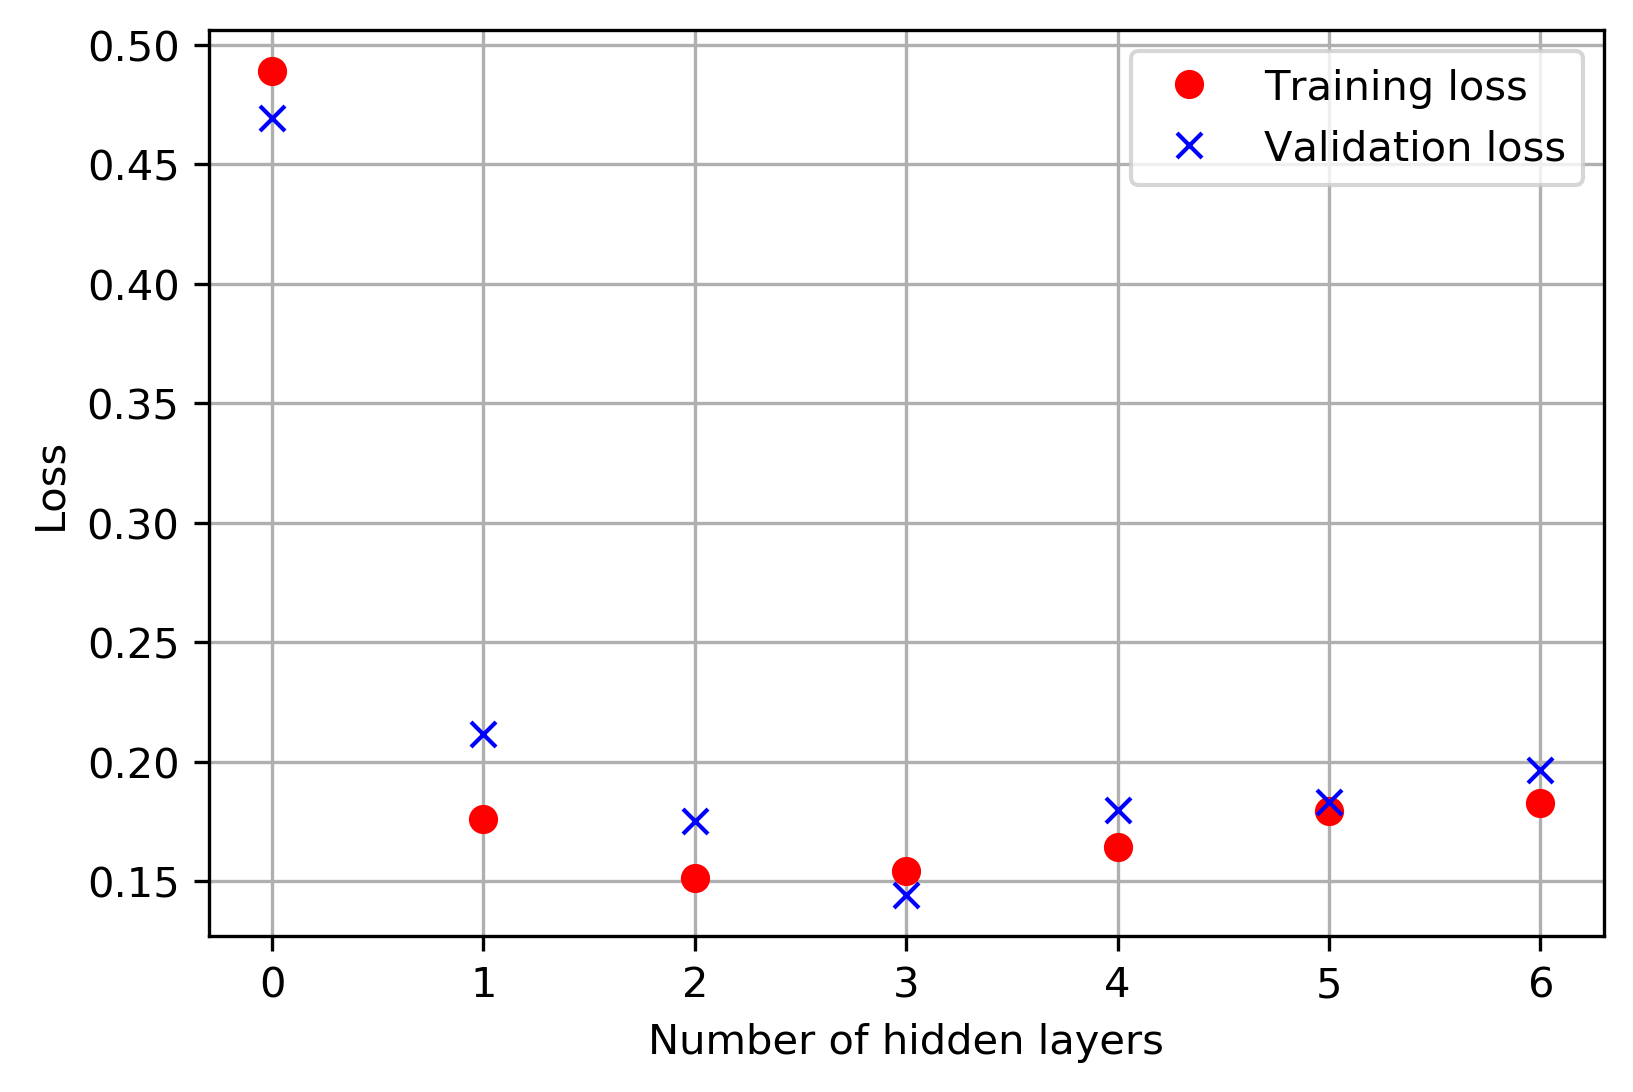

In [101]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(trainLoss,'ro',label="Training loss")
ax.plot(valLoss,'bx',label="Validation loss")
ax.legend()
ax.grid()
ax.set_xlabel("Number of hidden layers")
ax.set_ylabel("Loss")
plt.savefig('num_layers.png', dpi=300)

## Network training

In [7]:
model = generate_model(x_norm.shape[1], 1, 4, 8, "adam", "relu", 0.01, 0.0001)
model.save_weights('model_init.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


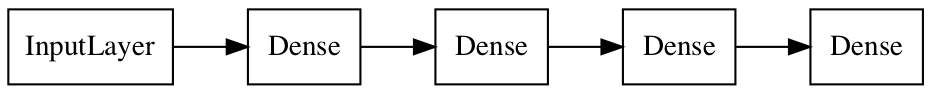

In [8]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=150,
)

In [9]:
history = train(model, x_norm, y_norm, 1, 2000, 1, .2)

Train on 1202 samples, validate on 301 samples
Epoch 1/2000
1202/1202 [==============================] - 1s 1ms/sample - loss: 0.6941 - mse: 0.6918 - val_loss: 0.4375 - val_mse: 0.4352
Epoch 2/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.4528 - mse: 0.4505 - val_loss: 0.4079 - val_mse: 0.4056
Epoch 3/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.3610 - mse: 0.3587 - val_loss: 0.3314 - val_mse: 0.3289
Epoch 4/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.3208 - mse: 0.3184 - val_loss: 0.3015 - val_mse: 0.2990
Epoch 5/2000
1202/1202 [==============================] - 0s 131us/sample - loss: 0.2879 - mse: 0.2854 - val_loss: 0.2782 - val_mse: 0.2757
Epoch 6/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2710 - mse: 0.2684 - val_loss: 0.2638 - val_mse: 0.2612
Epoch 7/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.2522 - mse: 0.2496 - val_loss: 0.

1202/1202 [==============================] - 0s 82us/sample - loss: 0.0945 - mse: 0.0899 - val_loss: 0.1292 - val_mse: 0.1247
Epoch 60/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0973 - mse: 0.0928 - val_loss: 0.1256 - val_mse: 0.1211
Epoch 61/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0959 - mse: 0.0914 - val_loss: 0.1585 - val_mse: 0.1540
Epoch 62/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0989 - mse: 0.0943 - val_loss: 0.1410 - val_mse: 0.1364
Epoch 63/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1055 - mse: 0.1009 - val_loss: 0.1386 - val_mse: 0.1340
Epoch 64/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1045 - mse: 0.0999 - val_loss: 0.1534 - val_mse: 0.1488
Epoch 65/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0983 - mse: 0.0936 - val_loss: 0.1191 - val_mse: 0.1145
Epoch 66/2000
1202/1202 [=========

1202/1202 [==============================] - 0s 82us/sample - loss: 0.0870 - mse: 0.0818 - val_loss: 0.1367 - val_mse: 0.1314
Epoch 118/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0865 - mse: 0.0813 - val_loss: 0.1325 - val_mse: 0.1273
Epoch 119/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0802 - mse: 0.0749 - val_loss: 0.1244 - val_mse: 0.1192
Epoch 120/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0961 - mse: 0.0908 - val_loss: 0.1478 - val_mse: 0.1425
Epoch 121/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0875 - mse: 0.0823 - val_loss: 0.1126 - val_mse: 0.1073
Epoch 122/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0855 - mse: 0.0803 - val_loss: 0.1218 - val_mse: 0.1166
Epoch 123/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0771 - mse: 0.0718 - val_loss: 0.1349 - val_mse: 0.1297
Epoch 124/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0860 - mse: 0.0802 - val_loss: 0.1240 - val_mse: 0.1182
Epoch 176/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0786 - mse: 0.0728 - val_loss: 0.1148 - val_mse: 0.1090
Epoch 177/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0813 - mse: 0.0755 - val_loss: 0.1067 - val_mse: 0.1009
Epoch 178/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.0803 - mse: 0.0744 - val_loss: 0.1294 - val_mse: 0.1235
Epoch 179/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0829 - mse: 0.0770 - val_loss: 0.1115 - val_mse: 0.1057
Epoch 180/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0776 - mse: 0.0718 - val_loss: 0.1151 - val_mse: 0.1093
Epoch 181/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0841 - mse: 0.0782 - val_loss: 0.1313 - val_mse: 0.1254
Epoch 182/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0756 - mse: 0.0696 - val_loss: 0.1137 - val_mse: 0.1077
Epoch 234/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0706 - mse: 0.0646 - val_loss: 0.1040 - val_mse: 0.0980
Epoch 235/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0716 - mse: 0.0656 - val_loss: 0.0999 - val_mse: 0.0940
Epoch 236/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0702 - mse: 0.0642 - val_loss: 0.1058 - val_mse: 0.0998
Epoch 237/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0711 - mse: 0.0651 - val_loss: 0.1167 - val_mse: 0.1107
Epoch 238/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0736 - mse: 0.0676 - val_loss: 0.0988 - val_mse: 0.0928
Epoch 239/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0674 - mse: 0.0615 - val_loss: 0.1141 - val_mse: 0.1081
Epoch 240/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0670 - mse: 0.0608 - val_loss: 0.0875 - val_mse: 0.0813
Epoch 292/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.0693 - mse: 0.0631 - val_loss: 0.0952 - val_mse: 0.0890
Epoch 293/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0719 - mse: 0.0657 - val_loss: 0.0974 - val_mse: 0.0911
Epoch 294/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0666 - mse: 0.0604 - val_loss: 0.1001 - val_mse: 0.0938
Epoch 295/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0686 - mse: 0.0624 - val_loss: 0.0964 - val_mse: 0.0902
Epoch 296/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0714 - mse: 0.0651 - val_loss: 0.1126 - val_mse: 0.1064
Epoch 297/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0714 - mse: 0.0652 - val_loss: 0.0989 - val_mse: 0.0927
Epoch 298/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0649 - mse: 0.0585 - val_loss: 0.0945 - val_mse: 0.0880
Epoch 350/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0652 - mse: 0.0588 - val_loss: 0.0970 - val_mse: 0.0905
Epoch 351/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0655 - mse: 0.0591 - val_loss: 0.1004 - val_mse: 0.0940
Epoch 352/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0632 - mse: 0.0567 - val_loss: 0.0981 - val_mse: 0.0917
Epoch 353/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0694 - mse: 0.0629 - val_loss: 0.1139 - val_mse: 0.1074
Epoch 354/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0667 - mse: 0.0602 - val_loss: 0.0985 - val_mse: 0.0920
Epoch 355/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0703 - mse: 0.0638 - val_loss: 0.0964 - val_mse: 0.0899
Epoch 356/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0647 - mse: 0.0581 - val_loss: 0.0980 - val_mse: 0.0915
Epoch 408/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0633 - mse: 0.0567 - val_loss: 0.0853 - val_mse: 0.0787
Epoch 409/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.0600 - mse: 0.0535 - val_loss: 0.0888 - val_mse: 0.0822
Epoch 410/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0627 - mse: 0.0561 - val_loss: 0.0946 - val_mse: 0.0880
Epoch 411/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0640 - mse: 0.0574 - val_loss: 0.0925 - val_mse: 0.0859
Epoch 412/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0645 - mse: 0.0579 - val_loss: 0.1022 - val_mse: 0.0956
Epoch 413/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0646 - mse: 0.0580 - val_loss: 0.1035 - val_mse: 0.0969
Epoch 414/2000
1202/1202 [==

1202/1202 [==============================] - 0s 81us/sample - loss: 0.0600 - mse: 0.0533 - val_loss: 0.0889 - val_mse: 0.0823
Epoch 466/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0584 - mse: 0.0518 - val_loss: 0.1081 - val_mse: 0.1014
Epoch 467/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0688 - mse: 0.0622 - val_loss: 0.0906 - val_mse: 0.0839
Epoch 468/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.0596 - mse: 0.0530 - val_loss: 0.0962 - val_mse: 0.0896
Epoch 469/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0600 - mse: 0.0533 - val_loss: 0.0958 - val_mse: 0.0892
Epoch 470/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0611 - mse: 0.0544 - val_loss: 0.0845 - val_mse: 0.0778
Epoch 471/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0598 - mse: 0.0532 - val_loss: 0.0884 - val_mse: 0.0818
Epoch 472/2000
1202/1202 [==

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0580 - mse: 0.0513 - val_loss: 0.0887 - val_mse: 0.0820
Epoch 524/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0611 - mse: 0.0544 - val_loss: 0.0885 - val_mse: 0.0818
Epoch 525/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0567 - mse: 0.0501 - val_loss: 0.0903 - val_mse: 0.0837
Epoch 526/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0605 - mse: 0.0539 - val_loss: 0.0970 - val_mse: 0.0904
Epoch 527/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0622 - mse: 0.0555 - val_loss: 0.0875 - val_mse: 0.0809
Epoch 528/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0599 - mse: 0.0533 - val_loss: 0.0848 - val_mse: 0.0782
Epoch 529/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0605 - mse: 0.0539 - val_loss: 0.0940 - val_mse: 0.0873
Epoch 530/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.0604 - mse: 0.0537 - val_loss: 0.0861 - val_mse: 0.0795
Epoch 582/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0558 - mse: 0.0492 - val_loss: 0.0830 - val_mse: 0.0764
Epoch 583/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0559 - mse: 0.0492 - val_loss: 0.0850 - val_mse: 0.0783
Epoch 584/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0580 - mse: 0.0513 - val_loss: 0.0852 - val_mse: 0.0786
Epoch 585/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0597 - mse: 0.0531 - val_loss: 0.0916 - val_mse: 0.0849
Epoch 586/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0584 - mse: 0.0517 - val_loss: 0.0868 - val_mse: 0.0802
Epoch 587/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0605 - mse: 0.0539 - val_loss: 0.0815 - val_mse: 0.0748
Epoch 588/2000
1202/1202 [==

1202/1202 [==============================] - 0s 81us/sample - loss: 0.0568 - mse: 0.0502 - val_loss: 0.0917 - val_mse: 0.0852
Epoch 640/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0593 - mse: 0.0527 - val_loss: 0.0852 - val_mse: 0.0787
Epoch 641/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0589 - mse: 0.0523 - val_loss: 0.0931 - val_mse: 0.0865
Epoch 642/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0571 - mse: 0.0505 - val_loss: 0.0971 - val_mse: 0.0905
Epoch 643/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0576 - mse: 0.0510 - val_loss: 0.0874 - val_mse: 0.0808
Epoch 644/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0570 - mse: 0.0504 - val_loss: 0.0840 - val_mse: 0.0774
Epoch 645/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0579 - mse: 0.0513 - val_loss: 0.0933 - val_mse: 0.0867
Epoch 646/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.0553 - mse: 0.0487 - val_loss: 0.0934 - val_mse: 0.0868
Epoch 698/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0559 - mse: 0.0493 - val_loss: 0.0895 - val_mse: 0.0829
Epoch 699/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.0577 - mse: 0.0511 - val_loss: 0.0874 - val_mse: 0.0808
Epoch 700/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0557 - mse: 0.0491 - val_loss: 0.0856 - val_mse: 0.0790
Epoch 701/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0559 - mse: 0.0492 - val_loss: 0.0852 - val_mse: 0.0786
Epoch 702/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0562 - mse: 0.0496 - val_loss: 0.0870 - val_mse: 0.0804
Epoch 703/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0593 - mse: 0.0527 - val_loss: 0.0841 - val_mse: 0.0775
Epoch 704/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.0560 - mse: 0.0494 - val_loss: 0.0872 - val_mse: 0.0805
Epoch 756/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0570 - mse: 0.0504 - val_loss: 0.0883 - val_mse: 0.0816
Epoch 757/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0566 - mse: 0.0500 - val_loss: 0.0824 - val_mse: 0.0758
Epoch 758/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0559 - mse: 0.0492 - val_loss: 0.0937 - val_mse: 0.0871
Epoch 759/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0557 - mse: 0.0491 - val_loss: 0.0807 - val_mse: 0.0741
Epoch 760/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0549 - mse: 0.0483 - val_loss: 0.0864 - val_mse: 0.0798
Epoch 761/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0543 - mse: 0.0477 - val_loss: 0.0842 - val_mse: 0.0776
Epoch 762/2000
1202/1202 [==

1202/1202 [==============================] - 0s 86us/sample - loss: 0.0552 - mse: 0.0485 - val_loss: 0.0890 - val_mse: 0.0824
Epoch 814/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0559 - mse: 0.0493 - val_loss: 0.0852 - val_mse: 0.0786
Epoch 815/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0539 - mse: 0.0473 - val_loss: 0.0867 - val_mse: 0.0801
Epoch 816/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0543 - mse: 0.0476 - val_loss: 0.0815 - val_mse: 0.0749
Epoch 817/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.0542 - mse: 0.0475 - val_loss: 0.0829 - val_mse: 0.0763
Epoch 818/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0534 - mse: 0.0468 - val_loss: 0.0870 - val_mse: 0.0804
Epoch 819/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0549 - mse: 0.0483 - val_loss: 0.0889 - val_mse: 0.0822
Epoch 820/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.0543 - mse: 0.0476 - val_loss: 0.0845 - val_mse: 0.0779
Epoch 872/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0538 - mse: 0.0472 - val_loss: 0.0829 - val_mse: 0.0762
Epoch 873/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0532 - mse: 0.0465 - val_loss: 0.0833 - val_mse: 0.0766
Epoch 874/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0527 - mse: 0.0461 - val_loss: 0.0870 - val_mse: 0.0804
Epoch 875/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0553 - mse: 0.0487 - val_loss: 0.0902 - val_mse: 0.0836
Epoch 876/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0578 - mse: 0.0512 - val_loss: 0.0814 - val_mse: 0.0748
Epoch 877/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0536 - mse: 0.0469 - val_loss: 0.0821 - val_mse: 0.0755
Epoch 878/2000
1202/1202 [==

1202/1202 [==============================] - 0s 84us/sample - loss: 0.0534 - mse: 0.0468 - val_loss: 0.0881 - val_mse: 0.0815
Epoch 930/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.0530 - mse: 0.0464 - val_loss: 0.0930 - val_mse: 0.0864
Epoch 931/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0540 - mse: 0.0474 - val_loss: 0.0810 - val_mse: 0.0744
Epoch 932/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.0544 - mse: 0.0478 - val_loss: 0.0834 - val_mse: 0.0768
Epoch 933/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0529 - mse: 0.0463 - val_loss: 0.0871 - val_mse: 0.0805
Epoch 934/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.0538 - mse: 0.0472 - val_loss: 0.0901 - val_mse: 0.0835
Epoch 935/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.0568 - mse: 0.0502 - val_loss: 0.0905 - val_mse: 0.0839
Epoch 936/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.0523 - mse: 0.0457 - val_loss: 0.0950 - val_mse: 0.0884
Epoch 988/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0577 - mse: 0.0511 - val_loss: 0.0828 - val_mse: 0.0762
Epoch 989/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0510 - mse: 0.0444 - val_loss: 0.0875 - val_mse: 0.0810
Epoch 990/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0514 - mse: 0.0448 - val_loss: 0.0827 - val_mse: 0.0762
Epoch 991/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0504 - mse: 0.0439 - val_loss: 0.0832 - val_mse: 0.0766
Epoch 992/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0513 - mse: 0.0448 - val_loss: 0.0884 - val_mse: 0.0819
Epoch 993/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0521 - mse: 0.0456 - val_loss: 0.0848 - val_mse: 0.0782
Epoch 994/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.0521 - mse: 0.0456 - val_loss: 0.0822 - val_mse: 0.0756
Epoch 1045/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0522 - mse: 0.0456 - val_loss: 0.0843 - val_mse: 0.0778
Epoch 1046/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0507 - mse: 0.0442 - val_loss: 0.0839 - val_mse: 0.0774
Epoch 1047/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0513 - mse: 0.0448 - val_loss: 0.0839 - val_mse: 0.0774
Epoch 1048/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0497 - mse: 0.0431 - val_loss: 0.0819 - val_mse: 0.0754
Epoch 1049/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0512 - mse: 0.0447 - val_loss: 0.0823 - val_mse: 0.0758
Epoch 1050/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0531 - mse: 0.0465 - val_loss: 0.0874 - val_mse: 0.0809
Epoch 1051/2000
1202/1

Epoch 1102/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0513 - mse: 0.0448 - val_loss: 0.0856 - val_mse: 0.0791
Epoch 1103/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0520 - mse: 0.0455 - val_loss: 0.0875 - val_mse: 0.0810
Epoch 1104/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0509 - mse: 0.0444 - val_loss: 0.0829 - val_mse: 0.0764
Epoch 1105/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0504 - mse: 0.0440 - val_loss: 0.0948 - val_mse: 0.0883
Epoch 1106/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.0525 - mse: 0.0460 - val_loss: 0.0810 - val_mse: 0.0745
Epoch 1107/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.0522 - mse: 0.0457 - val_loss: 0.0859 - val_mse: 0.0794
Epoch 1108/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0494 - mse: 0.0430 - val_loss: 0.0852 - val_mse: 0.0787
Epoch 

Epoch 1160/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0523 - mse: 0.0459 - val_loss: 0.0900 - val_mse: 0.0835
Epoch 1161/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0506 - mse: 0.0442 - val_loss: 0.0810 - val_mse: 0.0746
Epoch 1162/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0510 - mse: 0.0445 - val_loss: 0.0835 - val_mse: 0.0771
Epoch 1163/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0511 - mse: 0.0447 - val_loss: 0.0871 - val_mse: 0.0807
Epoch 1164/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0510 - mse: 0.0446 - val_loss: 0.0869 - val_mse: 0.0804
Epoch 1165/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0505 - mse: 0.0441 - val_loss: 0.0831 - val_mse: 0.0767
Epoch 1166/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0508 - mse: 0.0443 - val_loss: 0.0856 - val_mse: 0.0791
Epoch 

Epoch 1218/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0487 - mse: 0.0423 - val_loss: 0.0827 - val_mse: 0.0763
Epoch 1219/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0515 - mse: 0.0451 - val_loss: 0.0864 - val_mse: 0.0799
Epoch 1220/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0493 - mse: 0.0429 - val_loss: 0.0826 - val_mse: 0.0762
Epoch 1221/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0527 - mse: 0.0463 - val_loss: 0.0889 - val_mse: 0.0825
Epoch 1222/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0495 - mse: 0.0431 - val_loss: 0.0798 - val_mse: 0.0733
Epoch 1223/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0501 - mse: 0.0436 - val_loss: 0.0819 - val_mse: 0.0755
Epoch 1224/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0504 - mse: 0.0440 - val_loss: 0.0835 - val_mse: 0.0771
Epoch 

Epoch 1276/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0495 - mse: 0.0431 - val_loss: 0.0808 - val_mse: 0.0744
Epoch 1277/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0480 - mse: 0.0416 - val_loss: 0.0877 - val_mse: 0.0813
Epoch 1278/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0508 - mse: 0.0445 - val_loss: 0.0907 - val_mse: 0.0843
Epoch 1279/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.0497 - mse: 0.0433 - val_loss: 0.0796 - val_mse: 0.0732
Epoch 1280/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.0491 - mse: 0.0427 - val_loss: 0.0829 - val_mse: 0.0765
Epoch 1281/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.0491 - mse: 0.0427 - val_loss: 0.0810 - val_mse: 0.0746
Epoch 1282/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.0497 - mse: 0.0433 - val_loss: 0.0829 - val_mse: 0.0765
Epo

1202/1202 [==============================] - 0s 83us/sample - loss: 0.0486 - mse: 0.0422 - val_loss: 0.0811 - val_mse: 0.0748
Epoch 1334/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0473 - mse: 0.0410 - val_loss: 0.0815 - val_mse: 0.0752
Epoch 1335/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0478 - mse: 0.0415 - val_loss: 0.0841 - val_mse: 0.0777
Epoch 1336/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.0480 - mse: 0.0417 - val_loss: 0.0864 - val_mse: 0.0801
Epoch 1337/2000
1202/1202 [==============================] - 0s 136us/sample - loss: 0.0485 - mse: 0.0421 - val_loss: 0.0840 - val_mse: 0.0777
Epoch 1338/2000
1202/1202 [==============================] - 0s 149us/sample - loss: 0.0496 - mse: 0.0432 - val_loss: 0.0857 - val_mse: 0.0794
Epoch 1339/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.0484 - mse: 0.0421 - val_loss: 0.0820 - val_mse: 0.0756
Epoch 1340/2000
120

Epoch 1391/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0486 - mse: 0.0423 - val_loss: 0.0821 - val_mse: 0.0758
Epoch 1392/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0488 - mse: 0.0425 - val_loss: 0.0876 - val_mse: 0.0813
Epoch 1393/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0482 - mse: 0.0419 - val_loss: 0.0883 - val_mse: 0.0820
Epoch 1394/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0520 - mse: 0.0457 - val_loss: 0.0788 - val_mse: 0.0725
Epoch 1395/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.0491 - mse: 0.0429 - val_loss: 0.0846 - val_mse: 0.0783
Epoch 1396/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.0494 - mse: 0.0432 - val_loss: 0.0846 - val_mse: 0.0783
Epoch 1397/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0484 - mse: 0.0421 - val_loss: 0.0792 - val_mse: 0.0730
Epoch

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0495 - mse: 0.0432 - val_loss: 0.0911 - val_mse: 0.0848
Epoch 1449/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0492 - mse: 0.0430 - val_loss: 0.0827 - val_mse: 0.0765
Epoch 1450/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0486 - mse: 0.0423 - val_loss: 0.0823 - val_mse: 0.0761
Epoch 1451/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0484 - mse: 0.0422 - val_loss: 0.0854 - val_mse: 0.0792
Epoch 1452/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0493 - mse: 0.0431 - val_loss: 0.0879 - val_mse: 0.0817
Epoch 1453/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0487 - mse: 0.0424 - val_loss: 0.0813 - val_mse: 0.0751
Epoch 1454/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0473 - mse: 0.0411 - val_loss: 0.0839 - val_mse: 0.0776
Epoch 1455/2000
1202/1

Epoch 1506/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0479 - mse: 0.0418 - val_loss: 0.0810 - val_mse: 0.0748
Epoch 1507/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0484 - mse: 0.0422 - val_loss: 0.0815 - val_mse: 0.0753
Epoch 1508/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0478 - mse: 0.0416 - val_loss: 0.0812 - val_mse: 0.0750
Epoch 1509/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0488 - mse: 0.0427 - val_loss: 0.0844 - val_mse: 0.0782
Epoch 1510/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0483 - mse: 0.0421 - val_loss: 0.0801 - val_mse: 0.0739
Epoch 1511/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0481 - mse: 0.0419 - val_loss: 0.0810 - val_mse: 0.0748
Epoch 1512/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0477 - mse: 0.0415 - val_loss: 0.0843 - val_mse: 0.0781
Epoch 

Epoch 1564/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0474 - mse: 0.0412 - val_loss: 0.0844 - val_mse: 0.0782
Epoch 1565/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0476 - mse: 0.0414 - val_loss: 0.0854 - val_mse: 0.0792
Epoch 1566/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.0492 - mse: 0.0431 - val_loss: 0.0889 - val_mse: 0.0828
Epoch 1567/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0503 - mse: 0.0442 - val_loss: 0.0923 - val_mse: 0.0861
Epoch 1568/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0484 - mse: 0.0423 - val_loss: 0.0852 - val_mse: 0.0791
Epoch 1569/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.0464 - mse: 0.0403 - val_loss: 0.0885 - val_mse: 0.0823
Epoch 1570/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.0490 - mse: 0.0429 - val_loss: 0.0804 - val_mse: 0.0742
Epoch 

Epoch 1622/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0479 - mse: 0.0418 - val_loss: 0.0825 - val_mse: 0.0764
Epoch 1623/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0511 - mse: 0.0450 - val_loss: 0.0857 - val_mse: 0.0796
Epoch 1624/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0467 - mse: 0.0406 - val_loss: 0.0858 - val_mse: 0.0797
Epoch 1625/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0470 - mse: 0.0409 - val_loss: 0.0820 - val_mse: 0.0759
Epoch 1626/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0478 - mse: 0.0417 - val_loss: 0.0936 - val_mse: 0.0875
Epoch 1627/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0490 - mse: 0.0429 - val_loss: 0.0800 - val_mse: 0.0739
Epoch 1628/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0470 - mse: 0.0409 - val_loss: 0.0810 - val_mse: 0.0749
Epoch 

Epoch 1680/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0474 - mse: 0.0413 - val_loss: 0.0828 - val_mse: 0.0767
Epoch 1681/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0467 - mse: 0.0406 - val_loss: 0.0837 - val_mse: 0.0776
Epoch 1682/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0484 - mse: 0.0423 - val_loss: 0.0871 - val_mse: 0.0810
Epoch 1683/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0480 - mse: 0.0419 - val_loss: 0.0812 - val_mse: 0.0751
Epoch 1684/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0471 - mse: 0.0411 - val_loss: 0.0806 - val_mse: 0.0745
Epoch 1685/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0478 - mse: 0.0418 - val_loss: 0.0846 - val_mse: 0.0785
Epoch 1686/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0484 - mse: 0.0424 - val_loss: 0.0807 - val_mse: 0.0746
Epoch 

1202/1202 [==============================] - 0s 80us/sample - loss: 0.0476 - mse: 0.0416 - val_loss: 0.0849 - val_mse: 0.0788
Epoch 1738/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0471 - mse: 0.0411 - val_loss: 0.0822 - val_mse: 0.0761
Epoch 1739/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0495 - mse: 0.0435 - val_loss: 0.0788 - val_mse: 0.0728
Epoch 1740/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0488 - mse: 0.0427 - val_loss: 0.0806 - val_mse: 0.0746
Epoch 1741/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0475 - mse: 0.0415 - val_loss: 0.0852 - val_mse: 0.0792
Epoch 1742/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0485 - mse: 0.0425 - val_loss: 0.0887 - val_mse: 0.0827
Epoch 1743/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0490 - mse: 0.0430 - val_loss: 0.0871 - val_mse: 0.0811
Epoch 1744/2000
1202/1

Epoch 1795/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0478 - mse: 0.0418 - val_loss: 0.0876 - val_mse: 0.0816
Epoch 1796/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0471 - mse: 0.0411 - val_loss: 0.0801 - val_mse: 0.0741
Epoch 1797/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0466 - mse: 0.0406 - val_loss: 0.0788 - val_mse: 0.0728
Epoch 1798/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0474 - mse: 0.0414 - val_loss: 0.0858 - val_mse: 0.0798
Epoch 1799/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.0490 - mse: 0.0430 - val_loss: 0.0794 - val_mse: 0.0734
Epoch 1800/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.0484 - mse: 0.0424 - val_loss: 0.0892 - val_mse: 0.0832
Epoch 1801/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.0482 - mse: 0.0422 - val_loss: 0.0878 - val_mse: 0.0818
Epoch 

1202/1202 [==============================] - 0s 78us/sample - loss: 0.0460 - mse: 0.0400 - val_loss: 0.0844 - val_mse: 0.0784
Epoch 1853/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0472 - mse: 0.0413 - val_loss: 0.0821 - val_mse: 0.0762
Epoch 1854/2000
1202/1202 [==============================] - 0s 76us/sample - loss: 0.0480 - mse: 0.0420 - val_loss: 0.0833 - val_mse: 0.0773
Epoch 1855/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0474 - mse: 0.0415 - val_loss: 0.0832 - val_mse: 0.0772
Epoch 1856/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.0473 - mse: 0.0413 - val_loss: 0.0837 - val_mse: 0.0778
Epoch 1857/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.0471 - mse: 0.0411 - val_loss: 0.0817 - val_mse: 0.0757
Epoch 1858/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.0472 - mse: 0.0412 - val_loss: 0.0821 - val_mse: 0.0761
Epoch 1859/2000
1202

Epoch 1910/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0462 - mse: 0.0402 - val_loss: 0.0846 - val_mse: 0.0787
Epoch 1911/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0453 - mse: 0.0394 - val_loss: 0.0803 - val_mse: 0.0743
Epoch 1912/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.0469 - mse: 0.0409 - val_loss: 0.0836 - val_mse: 0.0777
Epoch 1913/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.0465 - mse: 0.0405 - val_loss: 0.0837 - val_mse: 0.0778
Epoch 1914/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.0474 - mse: 0.0415 - val_loss: 0.0829 - val_mse: 0.0770
Epoch 1915/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.0475 - mse: 0.0415 - val_loss: 0.0836 - val_mse: 0.0777
Epoch 1916/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0465 - mse: 0.0406 - val_loss: 0.0805 - val_mse: 0.0746
Epoch 

1202/1202 [==============================] - 0s 106us/sample - loss: 0.0480 - mse: 0.0421 - val_loss: 0.0831 - val_mse: 0.0772
Epoch 1968/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.0455 - mse: 0.0396 - val_loss: 0.0843 - val_mse: 0.0784
Epoch 1969/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.0464 - mse: 0.0405 - val_loss: 0.0846 - val_mse: 0.0788
Epoch 1970/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.0470 - mse: 0.0411 - val_loss: 0.0848 - val_mse: 0.0789
Epoch 1971/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.0474 - mse: 0.0415 - val_loss: 0.0825 - val_mse: 0.0766
Epoch 1972/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0461 - mse: 0.0402 - val_loss: 0.0868 - val_mse: 0.0809
Epoch 1973/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.0478 - mse: 0.0419 - val_loss: 0.0834 - val_mse: 0.0775
Epoch 1974/2000
1202

Text(0, 0.5, 'M.S.E.')

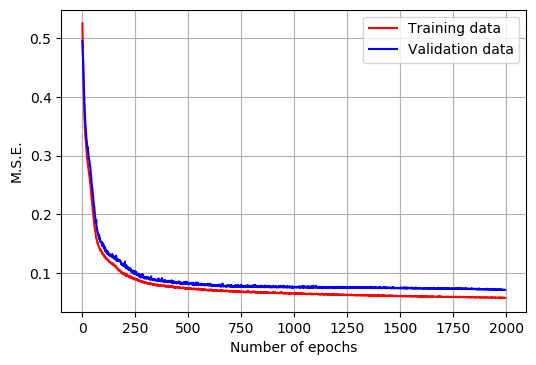

In [29]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['loss'][5:], 'r',label='Training data')
ax.plot(history.history['val_loss'][5:], 'b', label='Validation data')
ax.legend()
ax.grid()
ax.set_xlabel("Number of epochs")
ax.set_ylabel("M.S.E.")
#plt.savefig('training.png', dpi=300)

## More hyperparameter tuning

In [92]:
# selecting learning rate
levels  = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
trainLoss = np.zeros(len(levels))
valLoss   = np.zeros(len(levels))
for _ in range(len(levels)):
    model = generate_model(x_norm.shape[1], 1, 4, 8, "adam", "relu", 0.001, 0.01)
    history     = train(model, x_norm, y_norm, 1, 2000, 1, .2)
    trainLoss[_]  = np.mean(history.history['loss'][-10:-1])
    valLoss[_]    = np.mean(history.history['val_loss'][-10:-1])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 8)                 48        
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_115 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 301 samples
Epoch 1/2000
1202/1202 [==============================] - 1s 812us/sample - loss: 1.1951 - mse: 0.9810 - val_loss: 1.1012 - val_mse: 0.8955
Epoch 2/2000
1202/1202 [==============================] - 0s 100us

Epoch 53/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.3314 - mse: 0.2310 - val_loss: 0.3764 - val_mse: 0.2761
Epoch 54/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.3299 - mse: 0.2299 - val_loss: 0.3716 - val_mse: 0.2717
Epoch 55/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.3274 - mse: 0.2274 - val_loss: 0.3694 - val_mse: 0.2696
Epoch 56/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.3250 - mse: 0.2252 - val_loss: 0.3667 - val_mse: 0.2670
Epoch 57/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.3235 - mse: 0.2238 - val_loss: 0.3648 - val_mse: 0.2651
Epoch 58/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.3213 - mse: 0.2217 - val_loss: 0.3666 - val_mse: 0.2671
Epoch 59/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.3220 - mse: 0.2226 - val_loss: 0.3615 - val_mse: 0.2622
Epoch 60/2000
1202/1

1202/1202 [==============================] - 0s 83us/sample - loss: 0.2266 - mse: 0.1396 - val_loss: 0.2504 - val_mse: 0.1634
Epoch 170/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2245 - mse: 0.1379 - val_loss: 0.2488 - val_mse: 0.1621
Epoch 171/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2233 - mse: 0.1366 - val_loss: 0.2513 - val_mse: 0.1646
Epoch 172/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2238 - mse: 0.1371 - val_loss: 0.2515 - val_mse: 0.1649
Epoch 173/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2249 - mse: 0.1383 - val_loss: 0.2542 - val_mse: 0.1675
Epoch 174/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.2243 - mse: 0.1378 - val_loss: 0.2504 - val_mse: 0.1640
Epoch 175/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2246 - mse: 0.1383 - val_loss: 0.2504 - val_mse: 0.1642
Epoch 176/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.2054 - mse: 0.1269 - val_loss: 0.2342 - val_mse: 0.1558
Epoch 286/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2057 - mse: 0.1273 - val_loss: 0.2357 - val_mse: 0.1571
Epoch 287/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2074 - mse: 0.1290 - val_loss: 0.2361 - val_mse: 0.1575
Epoch 288/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.2055 - mse: 0.1272 - val_loss: 0.2330 - val_mse: 0.1547
Epoch 289/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2059 - mse: 0.1276 - val_loss: 0.2341 - val_mse: 0.1557
Epoch 290/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2048 - mse: 0.1265 - val_loss: 0.2314 - val_mse: 0.1531
Epoch 291/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2044 - mse: 0.1261 - val_loss: 0.2317 - val_mse: 0.1535
Epoch 292/2000
1202/1202 [==

1202/1202 [==============================] - 0s 88us/sample - loss: 0.1952 - mse: 0.1202 - val_loss: 0.2206 - val_mse: 0.1457
Epoch 402/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1944 - mse: 0.1194 - val_loss: 0.2202 - val_mse: 0.1452
Epoch 403/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1949 - mse: 0.1200 - val_loss: 0.2200 - val_mse: 0.1452
Epoch 404/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1943 - mse: 0.1194 - val_loss: 0.2174 - val_mse: 0.1425
Epoch 405/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1941 - mse: 0.1193 - val_loss: 0.2187 - val_mse: 0.1439
Epoch 406/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1953 - mse: 0.1204 - val_loss: 0.2195 - val_mse: 0.1448
Epoch 407/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1938 - mse: 0.1191 - val_loss: 0.2188 - val_mse: 0.1440
Epoch 408/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.1891 - mse: 0.1168 - val_loss: 0.2088 - val_mse: 0.1366
Epoch 518/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1873 - mse: 0.1151 - val_loss: 0.2079 - val_mse: 0.1356
Epoch 519/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1868 - mse: 0.1145 - val_loss: 0.2097 - val_mse: 0.1374
Epoch 520/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1869 - mse: 0.1146 - val_loss: 0.2088 - val_mse: 0.1365
Epoch 521/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1869 - mse: 0.1147 - val_loss: 0.2080 - val_mse: 0.1358
Epoch 522/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1872 - mse: 0.1151 - val_loss: 0.2109 - val_mse: 0.1389
Epoch 523/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1871 - mse: 0.1150 - val_loss: 0.2085 - val_mse: 0.1363
Epoch 524/2000
1202/1202 [==

1202/1202 [==============================] - 0s 86us/sample - loss: 0.1819 - mse: 0.1116 - val_loss: 0.2000 - val_mse: 0.1297
Epoch 634/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1807 - mse: 0.1104 - val_loss: 0.2006 - val_mse: 0.1303
Epoch 635/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1817 - mse: 0.1114 - val_loss: 0.2004 - val_mse: 0.1300
Epoch 636/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1811 - mse: 0.1108 - val_loss: 0.1998 - val_mse: 0.1296
Epoch 637/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1811 - mse: 0.1108 - val_loss: 0.2003 - val_mse: 0.1300
Epoch 638/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1821 - mse: 0.1118 - val_loss: 0.1995 - val_mse: 0.1292
Epoch 639/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1816 - mse: 0.1113 - val_loss: 0.2009 - val_mse: 0.1307
Epoch 640/2000
1202/1202 [==

1202/1202 [==============================] - 0s 81us/sample - loss: 0.1765 - mse: 0.1081 - val_loss: 0.1939 - val_mse: 0.1255
Epoch 750/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1763 - mse: 0.1079 - val_loss: 0.1944 - val_mse: 0.1260
Epoch 751/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1763 - mse: 0.1080 - val_loss: 0.1950 - val_mse: 0.1267
Epoch 752/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1766 - mse: 0.1082 - val_loss: 0.1945 - val_mse: 0.1261
Epoch 753/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1773 - mse: 0.1090 - val_loss: 0.1943 - val_mse: 0.1260
Epoch 754/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1774 - mse: 0.1092 - val_loss: 0.1940 - val_mse: 0.1257
Epoch 755/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1763 - mse: 0.1080 - val_loss: 0.1945 - val_mse: 0.1262
Epoch 756/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.1727 - mse: 0.1060 - val_loss: 0.1895 - val_mse: 0.1229
Epoch 866/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1728 - mse: 0.1061 - val_loss: 0.1885 - val_mse: 0.1219
Epoch 867/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1721 - mse: 0.1055 - val_loss: 0.1874 - val_mse: 0.1208
Epoch 868/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1729 - mse: 0.1063 - val_loss: 0.1874 - val_mse: 0.1208
Epoch 869/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1725 - mse: 0.1059 - val_loss: 0.1887 - val_mse: 0.1221
Epoch 870/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1735 - mse: 0.1068 - val_loss: 0.1889 - val_mse: 0.1223
Epoch 871/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1740 - mse: 0.1074 - val_loss: 0.1871 - val_mse: 0.1206
Epoch 872/2000
1202/1202 [==

1202/1202 [==============================] - 0s 85us/sample - loss: 0.1701 - mse: 0.1051 - val_loss: 0.1833 - val_mse: 0.1183
Epoch 982/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1708 - mse: 0.1058 - val_loss: 0.1845 - val_mse: 0.1195
Epoch 983/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1706 - mse: 0.1056 - val_loss: 0.1839 - val_mse: 0.1189
Epoch 984/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1697 - mse: 0.1048 - val_loss: 0.1837 - val_mse: 0.1188
Epoch 985/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1704 - mse: 0.1055 - val_loss: 0.1840 - val_mse: 0.1191
Epoch 986/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1696 - mse: 0.1048 - val_loss: 0.1833 - val_mse: 0.1184
Epoch 987/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1705 - mse: 0.1056 - val_loss: 0.1850 - val_mse: 0.1201
Epoch 988/2000
1202/1202 [==

Epoch 1039/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1683 - mse: 0.1041 - val_loss: 0.1825 - val_mse: 0.1182
Epoch 1040/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1686 - mse: 0.1043 - val_loss: 0.1817 - val_mse: 0.1174
Epoch 1041/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1684 - mse: 0.1042 - val_loss: 0.1817 - val_mse: 0.1175
Epoch 1042/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1689 - mse: 0.1047 - val_loss: 0.1821 - val_mse: 0.1178
Epoch 1043/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1683 - mse: 0.1041 - val_loss: 0.1834 - val_mse: 0.1191
Epoch 1044/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1691 - mse: 0.1048 - val_loss: 0.1831 - val_mse: 0.1189
Epoch 1045/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1686 - mse: 0.1044 - val_loss: 0.1830 - val_mse: 0.1187
Epoch 

Epoch 1097/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1672 - mse: 0.1036 - val_loss: 0.1820 - val_mse: 0.1183
Epoch 1098/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1669 - mse: 0.1033 - val_loss: 0.1810 - val_mse: 0.1174
Epoch 1099/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1670 - mse: 0.1034 - val_loss: 0.1805 - val_mse: 0.1169
Epoch 1100/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1670 - mse: 0.1034 - val_loss: 0.1822 - val_mse: 0.1187
Epoch 1101/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1672 - mse: 0.1036 - val_loss: 0.1818 - val_mse: 0.1183
Epoch 1102/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1667 - mse: 0.1031 - val_loss: 0.1799 - val_mse: 0.1164
Epoch 1103/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1665 - mse: 0.1030 - val_loss: 0.1819 - val_mse: 0.1183
Epoch 

Epoch 1155/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1654 - mse: 0.1021 - val_loss: 0.1790 - val_mse: 0.1157
Epoch 1156/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1655 - mse: 0.1023 - val_loss: 0.1790 - val_mse: 0.1157
Epoch 1157/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1656 - mse: 0.1023 - val_loss: 0.1797 - val_mse: 0.1164
Epoch 1158/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1655 - mse: 0.1023 - val_loss: 0.1794 - val_mse: 0.1162
Epoch 1159/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1649 - mse: 0.1017 - val_loss: 0.1788 - val_mse: 0.1156
Epoch 1160/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1650 - mse: 0.1018 - val_loss: 0.1798 - val_mse: 0.1166
Epoch 1161/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1650 - mse: 0.1018 - val_loss: 0.1801 - val_mse: 0.1169
Epoch 

Epoch 1213/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1644 - mse: 0.1014 - val_loss: 0.1781 - val_mse: 0.1151
Epoch 1214/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1644 - mse: 0.1014 - val_loss: 0.1775 - val_mse: 0.1145
Epoch 1215/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1652 - mse: 0.1023 - val_loss: 0.1766 - val_mse: 0.1136
Epoch 1216/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1641 - mse: 0.1011 - val_loss: 0.1772 - val_mse: 0.1142
Epoch 1217/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1641 - mse: 0.1011 - val_loss: 0.1767 - val_mse: 0.1138
Epoch 1218/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1643 - mse: 0.1014 - val_loss: 0.1775 - val_mse: 0.1145
Epoch 1219/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1637 - mse: 0.1008 - val_loss: 0.1794 - val_mse: 0.1165
Epoch 

Epoch 1271/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1628 - mse: 0.1001 - val_loss: 0.1776 - val_mse: 0.1149
Epoch 1272/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1628 - mse: 0.1001 - val_loss: 0.1771 - val_mse: 0.1145
Epoch 1273/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1630 - mse: 0.1004 - val_loss: 0.1761 - val_mse: 0.1134
Epoch 1274/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1623 - mse: 0.0996 - val_loss: 0.1759 - val_mse: 0.1133
Epoch 1275/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1623 - mse: 0.0996 - val_loss: 0.1757 - val_mse: 0.1130
Epoch 1276/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1629 - mse: 0.1002 - val_loss: 0.1757 - val_mse: 0.1130
Epoch 1277/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1629 - mse: 0.1002 - val_loss: 0.1756 - val_mse: 0.1130
Epoch 

Epoch 1386/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1609 - mse: 0.0987 - val_loss: 0.1735 - val_mse: 0.1113
Epoch 1387/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1611 - mse: 0.0989 - val_loss: 0.1744 - val_mse: 0.1122
Epoch 1388/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1610 - mse: 0.0988 - val_loss: 0.1735 - val_mse: 0.1113
Epoch 1389/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1608 - mse: 0.0986 - val_loss: 0.1745 - val_mse: 0.1124
Epoch 1390/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1608 - mse: 0.0987 - val_loss: 0.1750 - val_mse: 0.1128
Epoch 1391/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1614 - mse: 0.0992 - val_loss: 0.1730 - val_mse: 0.1107
Epoch 1392/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1613 - mse: 0.0991 - val_loss: 0.1743 - val_mse: 0.1121
Epoch 

Epoch 1444/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1603 - mse: 0.0983 - val_loss: 0.1720 - val_mse: 0.1101
Epoch 1445/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1600 - mse: 0.0981 - val_loss: 0.1727 - val_mse: 0.1107
Epoch 1446/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1602 - mse: 0.0983 - val_loss: 0.1732 - val_mse: 0.1113
Epoch 1447/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1602 - mse: 0.0983 - val_loss: 0.1719 - val_mse: 0.1100
Epoch 1448/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1607 - mse: 0.0989 - val_loss: 0.1726 - val_mse: 0.1107
Epoch 1449/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1607 - mse: 0.0988 - val_loss: 0.1724 - val_mse: 0.1105
Epoch 1450/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1603 - mse: 0.0984 - val_loss: 0.1735 - val_mse: 0.1116
Epoch 

Epoch 1502/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1592 - mse: 0.0976 - val_loss: 0.1719 - val_mse: 0.1103
Epoch 1503/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1598 - mse: 0.0982 - val_loss: 0.1718 - val_mse: 0.1102
Epoch 1504/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1601 - mse: 0.0985 - val_loss: 0.1721 - val_mse: 0.1105
Epoch 1505/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1600 - mse: 0.0985 - val_loss: 0.1733 - val_mse: 0.1117
Epoch 1506/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1599 - mse: 0.0983 - val_loss: 0.1725 - val_mse: 0.1109
Epoch 1507/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1598 - mse: 0.0982 - val_loss: 0.1715 - val_mse: 0.1100
Epoch 1508/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1592 - mse: 0.0977 - val_loss: 0.1723 - val_mse: 0.1107
Epoch 

Epoch 1617/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1578 - mse: 0.0967 - val_loss: 0.1703 - val_mse: 0.1092
Epoch 1618/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1577 - mse: 0.0966 - val_loss: 0.1710 - val_mse: 0.1099
Epoch 1619/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1584 - mse: 0.0973 - val_loss: 0.1705 - val_mse: 0.1093
Epoch 1620/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1578 - mse: 0.0968 - val_loss: 0.1694 - val_mse: 0.1084
Epoch 1621/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1578 - mse: 0.0967 - val_loss: 0.1702 - val_mse: 0.1091
Epoch 1622/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1577 - mse: 0.0966 - val_loss: 0.1701 - val_mse: 0.1090
Epoch 1623/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1588 - mse: 0.0977 - val_loss: 0.1703 - val_mse: 0.1093
Epoch 

Epoch 1675/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1587 - mse: 0.0979 - val_loss: 0.1697 - val_mse: 0.1088
Epoch 1676/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1572 - mse: 0.0963 - val_loss: 0.1699 - val_mse: 0.1090
Epoch 1677/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1585 - mse: 0.0976 - val_loss: 0.1694 - val_mse: 0.1085
Epoch 1678/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1576 - mse: 0.0967 - val_loss: 0.1701 - val_mse: 0.1092
Epoch 1679/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1574 - mse: 0.0965 - val_loss: 0.1701 - val_mse: 0.1092
Epoch 1680/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1574 - mse: 0.0965 - val_loss: 0.1698 - val_mse: 0.1089
Epoch 1681/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1575 - mse: 0.0966 - val_loss: 0.1692 - val_mse: 0.1083
Epoch 

Epoch 1733/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1566 - mse: 0.0957 - val_loss: 0.1688 - val_mse: 0.1079
Epoch 1734/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1565 - mse: 0.0957 - val_loss: 0.1676 - val_mse: 0.1067
Epoch 1735/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1561 - mse: 0.0952 - val_loss: 0.1689 - val_mse: 0.1081
Epoch 1736/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1565 - mse: 0.0957 - val_loss: 0.1687 - val_mse: 0.1078
Epoch 1737/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1563 - mse: 0.0954 - val_loss: 0.1677 - val_mse: 0.1068
Epoch 1738/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1565 - mse: 0.0956 - val_loss: 0.1686 - val_mse: 0.1078
Epoch 1739/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1570 - mse: 0.0961 - val_loss: 0.1687 - val_mse: 0.1078
Epoch 

Epoch 1791/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1558 - mse: 0.0951 - val_loss: 0.1689 - val_mse: 0.1082
Epoch 1792/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1559 - mse: 0.0953 - val_loss: 0.1682 - val_mse: 0.1076
Epoch 1793/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1559 - mse: 0.0953 - val_loss: 0.1676 - val_mse: 0.1070
Epoch 1794/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1555 - mse: 0.0949 - val_loss: 0.1671 - val_mse: 0.1064
Epoch 1795/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1554 - mse: 0.0947 - val_loss: 0.1674 - val_mse: 0.1067
Epoch 1796/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1558 - mse: 0.0952 - val_loss: 0.1667 - val_mse: 0.1061
Epoch 1797/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1558 - mse: 0.0951 - val_loss: 0.1684 - val_mse: 0.1077
Epoch 

Epoch 1849/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1553 - mse: 0.0948 - val_loss: 0.1673 - val_mse: 0.1068
Epoch 1850/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1551 - mse: 0.0946 - val_loss: 0.1669 - val_mse: 0.1063
Epoch 1851/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1547 - mse: 0.0941 - val_loss: 0.1688 - val_mse: 0.1083
Epoch 1852/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1554 - mse: 0.0949 - val_loss: 0.1671 - val_mse: 0.1066
Epoch 1853/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1561 - mse: 0.0955 - val_loss: 0.1681 - val_mse: 0.1075
Epoch 1854/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1556 - mse: 0.0951 - val_loss: 0.1671 - val_mse: 0.1066
Epoch 1855/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1552 - mse: 0.0947 - val_loss: 0.1669 - val_mse: 0.1064
Epoch 

Epoch 1907/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1544 - mse: 0.0942 - val_loss: 0.1664 - val_mse: 0.1062
Epoch 1908/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1548 - mse: 0.0945 - val_loss: 0.1664 - val_mse: 0.1061
Epoch 1909/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1545 - mse: 0.0942 - val_loss: 0.1666 - val_mse: 0.1064
Epoch 1910/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1543 - mse: 0.0941 - val_loss: 0.1662 - val_mse: 0.1059
Epoch 1911/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1544 - mse: 0.0941 - val_loss: 0.1669 - val_mse: 0.1066
Epoch 1912/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1544 - mse: 0.0941 - val_loss: 0.1661 - val_mse: 0.1059
Epoch 1913/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1542 - mse: 0.0940 - val_loss: 0.1678 - val_mse: 0.1075
Epoch 

Epoch 1965/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1540 - mse: 0.0939 - val_loss: 0.1666 - val_mse: 0.1065
Epoch 1966/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1539 - mse: 0.0938 - val_loss: 0.1658 - val_mse: 0.1058
Epoch 1967/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1542 - mse: 0.0942 - val_loss: 0.1658 - val_mse: 0.1058
Epoch 1968/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1539 - mse: 0.0938 - val_loss: 0.1662 - val_mse: 0.1061
Epoch 1969/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1539 - mse: 0.0938 - val_loss: 0.1661 - val_mse: 0.1060
Epoch 1970/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1543 - mse: 0.0942 - val_loss: 0.1663 - val_mse: 0.1063
Epoch 1971/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1538 - mse: 0.0938 - val_loss: 0.1657 - val_mse: 0.1057
Epoch 

1202/1202 [==============================] - 0s 80us/sample - loss: 0.3000 - mse: 0.2005 - val_loss: 0.3033 - val_mse: 0.2037
Epoch 75/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.2980 - mse: 0.1984 - val_loss: 0.2922 - val_mse: 0.1925
Epoch 76/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2970 - mse: 0.1973 - val_loss: 0.2983 - val_mse: 0.1987
Epoch 77/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2971 - mse: 0.1974 - val_loss: 0.2941 - val_mse: 0.1944
Epoch 78/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2964 - mse: 0.1968 - val_loss: 0.2899 - val_mse: 0.1903
Epoch 79/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2925 - mse: 0.1928 - val_loss: 0.2890 - val_mse: 0.1894
Epoch 80/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.2914 - mse: 0.1920 - val_loss: 0.2885 - val_mse: 0.1891
Epoch 81/2000
1202/1202 [=========

1202/1202 [==============================] - 0s 79us/sample - loss: 0.2301 - mse: 0.1395 - val_loss: 0.2281 - val_mse: 0.1375
Epoch 191/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2306 - mse: 0.1401 - val_loss: 0.2275 - val_mse: 0.1369
Epoch 192/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2310 - mse: 0.1404 - val_loss: 0.2310 - val_mse: 0.1403
Epoch 193/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2295 - mse: 0.1390 - val_loss: 0.2283 - val_mse: 0.1377
Epoch 194/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2290 - mse: 0.1382 - val_loss: 0.2263 - val_mse: 0.1356
Epoch 195/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2279 - mse: 0.1372 - val_loss: 0.2268 - val_mse: 0.1361
Epoch 196/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.2271 - mse: 0.1364 - val_loss: 0.2254 - val_mse: 0.1347
Epoch 197/2000
1202/1202 [==

1202/1202 [==============================] - 0s 79us/sample - loss: 0.2052 - mse: 0.1184 - val_loss: 0.2067 - val_mse: 0.1199
Epoch 307/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2058 - mse: 0.1191 - val_loss: 0.2068 - val_mse: 0.1201
Epoch 308/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2033 - mse: 0.1165 - val_loss: 0.2079 - val_mse: 0.1212
Epoch 309/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2032 - mse: 0.1165 - val_loss: 0.2092 - val_mse: 0.1226
Epoch 310/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.2029 - mse: 0.1162 - val_loss: 0.2069 - val_mse: 0.1202
Epoch 311/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2032 - mse: 0.1166 - val_loss: 0.2068 - val_mse: 0.1203
Epoch 312/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2041 - mse: 0.1175 - val_loss: 0.2062 - val_mse: 0.1195
Epoch 313/2000
1202/1202 [==

1202/1202 [==============================] - 0s 79us/sample - loss: 0.1880 - mse: 0.1044 - val_loss: 0.1944 - val_mse: 0.1108
Epoch 423/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1882 - mse: 0.1046 - val_loss: 0.1943 - val_mse: 0.1108
Epoch 424/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1881 - mse: 0.1047 - val_loss: 0.1964 - val_mse: 0.1129
Epoch 425/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1884 - mse: 0.1048 - val_loss: 0.1936 - val_mse: 0.1102
Epoch 426/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1876 - mse: 0.1041 - val_loss: 0.1961 - val_mse: 0.1127
Epoch 427/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1871 - mse: 0.1036 - val_loss: 0.1964 - val_mse: 0.1129
Epoch 428/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1875 - mse: 0.1041 - val_loss: 0.1948 - val_mse: 0.1114
Epoch 429/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.1786 - mse: 0.0973 - val_loss: 0.1895 - val_mse: 0.1082
Epoch 539/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1776 - mse: 0.0962 - val_loss: 0.1887 - val_mse: 0.1074
Epoch 540/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1774 - mse: 0.0962 - val_loss: 0.1904 - val_mse: 0.1093
Epoch 541/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1775 - mse: 0.0963 - val_loss: 0.1890 - val_mse: 0.1078
Epoch 542/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.1777 - mse: 0.0964 - val_loss: 0.1897 - val_mse: 0.1085
Epoch 543/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1775 - mse: 0.0964 - val_loss: 0.1893 - val_mse: 0.1081
Epoch 544/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1786 - mse: 0.0974 - val_loss: 0.1920 - val_mse: 0.1109
Epoch 545/2000
1202/1202 [==

1202/1202 [==============================] - 0s 76us/sample - loss: 0.1704 - mse: 0.0917 - val_loss: 0.1859 - val_mse: 0.1072
Epoch 655/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1712 - mse: 0.0926 - val_loss: 0.1880 - val_mse: 0.1093
Epoch 656/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1723 - mse: 0.0936 - val_loss: 0.1862 - val_mse: 0.1075
Epoch 657/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1714 - mse: 0.0927 - val_loss: 0.1854 - val_mse: 0.1068
Epoch 658/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1707 - mse: 0.0921 - val_loss: 0.1865 - val_mse: 0.1079
Epoch 659/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1706 - mse: 0.0919 - val_loss: 0.1844 - val_mse: 0.1059
Epoch 660/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1714 - mse: 0.0928 - val_loss: 0.1850 - val_mse: 0.1065
Epoch 661/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.1662 - mse: 0.0902 - val_loss: 0.1841 - val_mse: 0.1081
Epoch 771/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1671 - mse: 0.0911 - val_loss: 0.1804 - val_mse: 0.1044
Epoch 772/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1652 - mse: 0.0893 - val_loss: 0.1817 - val_mse: 0.1057
Epoch 773/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.1653 - mse: 0.0893 - val_loss: 0.1821 - val_mse: 0.1062
Epoch 774/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1662 - mse: 0.0902 - val_loss: 0.1799 - val_mse: 0.1040
Epoch 775/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1662 - mse: 0.0903 - val_loss: 0.1806 - val_mse: 0.1047
Epoch 776/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1670 - mse: 0.0911 - val_loss: 0.1802 - val_mse: 0.1044
Epoch 777/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.1612 - mse: 0.0877 - val_loss: 0.1785 - val_mse: 0.1051
Epoch 887/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1614 - mse: 0.0880 - val_loss: 0.1776 - val_mse: 0.1042
Epoch 888/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1611 - mse: 0.0878 - val_loss: 0.1772 - val_mse: 0.1039
Epoch 889/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1610 - mse: 0.0876 - val_loss: 0.1786 - val_mse: 0.1052
Epoch 890/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1616 - mse: 0.0882 - val_loss: 0.1779 - val_mse: 0.1046
Epoch 891/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1610 - mse: 0.0876 - val_loss: 0.1777 - val_mse: 0.1043
Epoch 892/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1604 - mse: 0.0871 - val_loss: 0.1776 - val_mse: 0.1043
Epoch 893/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.1572 - mse: 0.0863 - val_loss: 0.1748 - val_mse: 0.1040
Epoch 1003/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1574 - mse: 0.0865 - val_loss: 0.1742 - val_mse: 0.1033
Epoch 1004/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1576 - mse: 0.0867 - val_loss: 0.1741 - val_mse: 0.1032
Epoch 1005/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1581 - mse: 0.0873 - val_loss: 0.1737 - val_mse: 0.1029
Epoch 1006/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1581 - mse: 0.0873 - val_loss: 0.1741 - val_mse: 0.1033
Epoch 1007/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1575 - mse: 0.0868 - val_loss: 0.1758 - val_mse: 0.1051
Epoch 1008/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1565 - mse: 0.0858 - val_loss: 0.1752 - val_mse: 0.1044
Epoch 1009/2000
1202/1

Epoch 1060/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1560 - mse: 0.0863 - val_loss: 0.1720 - val_mse: 0.1023
Epoch 1061/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1562 - mse: 0.0865 - val_loss: 0.1735 - val_mse: 0.1038
Epoch 1062/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1553 - mse: 0.0856 - val_loss: 0.1725 - val_mse: 0.1028
Epoch 1063/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1550 - mse: 0.0853 - val_loss: 0.1725 - val_mse: 0.1028
Epoch 1064/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1550 - mse: 0.0854 - val_loss: 0.1727 - val_mse: 0.1031
Epoch 1065/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1554 - mse: 0.0858 - val_loss: 0.1751 - val_mse: 0.1054
Epoch 1066/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1558 - mse: 0.0862 - val_loss: 0.1726 - val_mse: 0.1030
Epoch 

Epoch 1118/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1545 - mse: 0.0857 - val_loss: 0.1701 - val_mse: 0.1014
Epoch 1119/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1536 - mse: 0.0849 - val_loss: 0.1710 - val_mse: 0.1023
Epoch 1120/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1535 - mse: 0.0848 - val_loss: 0.1742 - val_mse: 0.1056
Epoch 1121/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1546 - mse: 0.0859 - val_loss: 0.1713 - val_mse: 0.1026
Epoch 1122/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1533 - mse: 0.0846 - val_loss: 0.1696 - val_mse: 0.1009
Epoch 1123/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1542 - mse: 0.0855 - val_loss: 0.1712 - val_mse: 0.1026
Epoch 1124/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1539 - mse: 0.0853 - val_loss: 0.1703 - val_mse: 0.1017
Epoch 

Epoch 1176/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1523 - mse: 0.0845 - val_loss: 0.1686 - val_mse: 0.1007
Epoch 1177/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1518 - mse: 0.0839 - val_loss: 0.1689 - val_mse: 0.1011
Epoch 1178/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1524 - mse: 0.0846 - val_loss: 0.1701 - val_mse: 0.1023
Epoch 1179/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1523 - mse: 0.0844 - val_loss: 0.1698 - val_mse: 0.1020
Epoch 1180/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1531 - mse: 0.0852 - val_loss: 0.1695 - val_mse: 0.1017
Epoch 1181/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1525 - mse: 0.0847 - val_loss: 0.1685 - val_mse: 0.1007
Epoch 1182/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1526 - mse: 0.0848 - val_loss: 0.1691 - val_mse: 0.1013
Epoch 

Epoch 1234/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1512 - mse: 0.0840 - val_loss: 0.1678 - val_mse: 0.1007
Epoch 1235/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1521 - mse: 0.0850 - val_loss: 0.1677 - val_mse: 0.1006
Epoch 1236/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1517 - mse: 0.0846 - val_loss: 0.1681 - val_mse: 0.1010
Epoch 1237/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.1518 - mse: 0.0847 - val_loss: 0.1674 - val_mse: 0.1003
Epoch 1238/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.1514 - mse: 0.0844 - val_loss: 0.1693 - val_mse: 0.1022
Epoch 1239/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1511 - mse: 0.0840 - val_loss: 0.1673 - val_mse: 0.1003
Epoch 1240/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1513 - mse: 0.0842 - val_loss: 0.1673 - val_mse: 0.1002
Epoch 

Epoch 1292/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1507 - mse: 0.0843 - val_loss: 0.1675 - val_mse: 0.1011
Epoch 1293/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1508 - mse: 0.0844 - val_loss: 0.1661 - val_mse: 0.0997
Epoch 1294/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1498 - mse: 0.0834 - val_loss: 0.1675 - val_mse: 0.1012
Epoch 1295/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1499 - mse: 0.0836 - val_loss: 0.1661 - val_mse: 0.0998
Epoch 1296/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1502 - mse: 0.0838 - val_loss: 0.1672 - val_mse: 0.1008
Epoch 1297/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1498 - mse: 0.0835 - val_loss: 0.1662 - val_mse: 0.0999
Epoch 1298/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1496 - mse: 0.0833 - val_loss: 0.1663 - val_mse: 0.0999
Epoch 

Epoch 1407/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1485 - mse: 0.0833 - val_loss: 0.1642 - val_mse: 0.0990
Epoch 1408/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1480 - mse: 0.0828 - val_loss: 0.1641 - val_mse: 0.0989
Epoch 1409/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1481 - mse: 0.0829 - val_loss: 0.1637 - val_mse: 0.0985
Epoch 1410/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1484 - mse: 0.0832 - val_loss: 0.1641 - val_mse: 0.0989
Epoch 1411/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1476 - mse: 0.0825 - val_loss: 0.1673 - val_mse: 0.1021
Epoch 1412/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1490 - mse: 0.0839 - val_loss: 0.1647 - val_mse: 0.0995
Epoch 1413/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1482 - mse: 0.0831 - val_loss: 0.1645 - val_mse: 0.0994
E

1202/1202 [==============================] - 0s 84us/sample - loss: 0.1466 - mse: 0.0824 - val_loss: 0.1626 - val_mse: 0.0985
Epoch 1522/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1467 - mse: 0.0826 - val_loss: 0.1627 - val_mse: 0.0986
Epoch 1523/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1465 - mse: 0.0825 - val_loss: 0.1632 - val_mse: 0.0991
Epoch 1524/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1464 - mse: 0.0823 - val_loss: 0.1620 - val_mse: 0.0979
Epoch 1525/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1463 - mse: 0.0822 - val_loss: 0.1627 - val_mse: 0.0986
Epoch 1526/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1468 - mse: 0.0827 - val_loss: 0.1643 - val_mse: 0.1002
Epoch 1527/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1465 - mse: 0.0824 - val_loss: 0.1622 - val_mse: 0.0982
Epoch 1528/2000
1202/1

Epoch 1579/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1461 - mse: 0.0825 - val_loss: 0.1630 - val_mse: 0.0994
Epoch 1580/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1461 - mse: 0.0825 - val_loss: 0.1626 - val_mse: 0.0990
Epoch 1581/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1461 - mse: 0.0826 - val_loss: 0.1616 - val_mse: 0.0981
Epoch 1582/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1459 - mse: 0.0823 - val_loss: 0.1618 - val_mse: 0.0982
Epoch 1583/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1459 - mse: 0.0824 - val_loss: 0.1623 - val_mse: 0.0987
Epoch 1584/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1456 - mse: 0.0820 - val_loss: 0.1621 - val_mse: 0.0986
Epoch 1585/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1464 - mse: 0.0829 - val_loss: 0.1622 - val_mse: 0.0986
Epoch 

Epoch 1694/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1452 - mse: 0.0825 - val_loss: 0.1650 - val_mse: 0.1023
Epoch 1695/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1454 - mse: 0.0827 - val_loss: 0.1606 - val_mse: 0.0979
Epoch 1696/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1448 - mse: 0.0821 - val_loss: 0.1623 - val_mse: 0.0996
Epoch 1697/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1448 - mse: 0.0821 - val_loss: 0.1604 - val_mse: 0.0977
Epoch 1698/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1450 - mse: 0.0824 - val_loss: 0.1604 - val_mse: 0.0978
Epoch 1699/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1450 - mse: 0.0823 - val_loss: 0.1613 - val_mse: 0.0987
Epoch 1700/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1450 - mse: 0.0823 - val_loss: 0.1618 - val_mse: 0.0992
Epoch 

Epoch 1809/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1442 - mse: 0.0823 - val_loss: 0.1607 - val_mse: 0.0987
Epoch 1810/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1439 - mse: 0.0819 - val_loss: 0.1600 - val_mse: 0.0981
Epoch 1811/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1436 - mse: 0.0817 - val_loss: 0.1595 - val_mse: 0.0976
Epoch 1812/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1445 - mse: 0.0825 - val_loss: 0.1595 - val_mse: 0.0976
Epoch 1813/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1436 - mse: 0.0817 - val_loss: 0.1589 - val_mse: 0.0970
Epoch 1814/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1438 - mse: 0.0819 - val_loss: 0.1596 - val_mse: 0.0977
Epoch 1815/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1433 - mse: 0.0814 - val_loss: 0.1596 - val_mse: 0.0977
Epoch 

Epoch 1924/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1421 - mse: 0.0809 - val_loss: 0.1581 - val_mse: 0.0969
Epoch 1925/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1424 - mse: 0.0812 - val_loss: 0.1578 - val_mse: 0.0966
Epoch 1926/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1423 - mse: 0.0811 - val_loss: 0.1583 - val_mse: 0.0971
Epoch 1927/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1423 - mse: 0.0812 - val_loss: 0.1578 - val_mse: 0.0966
Epoch 1928/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1428 - mse: 0.0816 - val_loss: 0.1590 - val_mse: 0.0978
Epoch 1929/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1422 - mse: 0.0811 - val_loss: 0.1583 - val_mse: 0.0972
Epoch 1930/2000
1202/1202 [==============================] - 0s 137us/sample - loss: 0.1428 - mse: 0.0816 - val_loss: 0.1590 - val_mse: 0.0979
Ep

Epoch 33/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.3894 - mse: 0.2840 - val_loss: 0.4373 - val_mse: 0.3321
Epoch 34/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.3872 - mse: 0.2821 - val_loss: 0.4354 - val_mse: 0.3306
Epoch 35/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.3873 - mse: 0.2828 - val_loss: 0.4328 - val_mse: 0.3284
Epoch 36/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.3802 - mse: 0.2760 - val_loss: 0.4261 - val_mse: 0.3219
Epoch 37/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.3754 - mse: 0.2713 - val_loss: 0.4252 - val_mse: 0.3212
Epoch 38/2000
1202/1202 [==============================] - 0s 125us/sample - loss: 0.3739 - mse: 0.2701 - val_loss: 0.4168 - val_mse: 0.3132
Epoch 39/2000
1202/1202 [==============================] - 0s 135us/sample - loss: 0.3697 - mse: 0.2662 - val_loss: 0.4137 - val_mse: 0.3103
Epoch 40/2000
12

1202/1202 [==============================] - 0s 82us/sample - loss: 0.2253 - mse: 0.1297 - val_loss: 0.2629 - val_mse: 0.1674
Epoch 150/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2282 - mse: 0.1329 - val_loss: 0.2589 - val_mse: 0.1635
Epoch 151/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2255 - mse: 0.1302 - val_loss: 0.2581 - val_mse: 0.1628
Epoch 152/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2244 - mse: 0.1290 - val_loss: 0.2586 - val_mse: 0.1633
Epoch 153/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2247 - mse: 0.1295 - val_loss: 0.2594 - val_mse: 0.1643
Epoch 154/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.2245 - mse: 0.1293 - val_loss: 0.2639 - val_mse: 0.1689
Epoch 155/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.2253 - mse: 0.1304 - val_loss: 0.2620 - val_mse: 0.1670
Epoch 156/2000
1202/1202 [==

Epoch 265/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.2022 - mse: 0.1135 - val_loss: 0.2335 - val_mse: 0.1449
Epoch 266/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.2036 - mse: 0.1149 - val_loss: 0.2335 - val_mse: 0.1449
Epoch 267/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.2022 - mse: 0.1135 - val_loss: 0.2362 - val_mse: 0.1475
Epoch 268/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.2030 - mse: 0.1143 - val_loss: 0.2362 - val_mse: 0.1475
Epoch 269/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2021 - mse: 0.1136 - val_loss: 0.2340 - val_mse: 0.1456
Epoch 270/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.2024 - mse: 0.1139 - val_loss: 0.2375 - val_mse: 0.1490
Epoch 271/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2010 - mse: 0.1125 - val_loss: 0.2337 - val_mse: 0.1452
Epoch 272/

Epoch 323/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1943 - mse: 0.1077 - val_loss: 0.2259 - val_mse: 0.1394
Epoch 324/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1934 - mse: 0.1068 - val_loss: 0.2242 - val_mse: 0.1376
Epoch 325/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1937 - mse: 0.1072 - val_loss: 0.2263 - val_mse: 0.1397
Epoch 326/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1951 - mse: 0.1086 - val_loss: 0.2277 - val_mse: 0.1412
Epoch 327/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1934 - mse: 0.1069 - val_loss: 0.2265 - val_mse: 0.1400
Epoch 328/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1936 - mse: 0.1071 - val_loss: 0.2241 - val_mse: 0.1376
Epoch 329/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1928 - mse: 0.1063 - val_loss: 0.2254 - val_mse: 0.1391
Epoch 

Epoch 381/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1868 - mse: 0.1017 - val_loss: 0.2201 - val_mse: 0.1349
Epoch 382/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1876 - mse: 0.1024 - val_loss: 0.2198 - val_mse: 0.1348
Epoch 383/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1874 - mse: 0.1023 - val_loss: 0.2195 - val_mse: 0.1344
Epoch 384/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1878 - mse: 0.1028 - val_loss: 0.2184 - val_mse: 0.1334
Epoch 385/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1865 - mse: 0.1015 - val_loss: 0.2187 - val_mse: 0.1336
Epoch 386/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1864 - mse: 0.1014 - val_loss: 0.2182 - val_mse: 0.1332
Epoch 387/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1865 - mse: 0.1015 - val_loss: 0.2181 - val_mse: 0.1330
Epoch 

Epoch 439/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1817 - mse: 0.0979 - val_loss: 0.2112 - val_mse: 0.1274
Epoch 440/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1812 - mse: 0.0974 - val_loss: 0.2140 - val_mse: 0.1302
Epoch 441/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1808 - mse: 0.0970 - val_loss: 0.2116 - val_mse: 0.1279
Epoch 442/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1810 - mse: 0.0974 - val_loss: 0.2117 - val_mse: 0.1280
Epoch 443/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1818 - mse: 0.0982 - val_loss: 0.2149 - val_mse: 0.1312
Epoch 444/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1807 - mse: 0.0970 - val_loss: 0.2132 - val_mse: 0.1295
Epoch 445/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1805 - mse: 0.0968 - val_loss: 0.2116 - val_mse: 0.1280
Epoch 

Epoch 497/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1760 - mse: 0.0934 - val_loss: 0.2088 - val_mse: 0.1262
Epoch 498/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1762 - mse: 0.0935 - val_loss: 0.2118 - val_mse: 0.1291
Epoch 499/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1777 - mse: 0.0951 - val_loss: 0.2081 - val_mse: 0.1254
Epoch 500/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1752 - mse: 0.0927 - val_loss: 0.2089 - val_mse: 0.1265
Epoch 501/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1766 - mse: 0.0941 - val_loss: 0.2083 - val_mse: 0.1258
Epoch 502/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1758 - mse: 0.0933 - val_loss: 0.2064 - val_mse: 0.1239
Epoch 503/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1756 - mse: 0.0931 - val_loss: 0.2106 - val_mse: 0.1279
Epoch 5

Epoch 555/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1729 - mse: 0.0917 - val_loss: 0.2041 - val_mse: 0.1230
Epoch 556/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1729 - mse: 0.0918 - val_loss: 0.2048 - val_mse: 0.1236
Epoch 557/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1724 - mse: 0.0912 - val_loss: 0.2041 - val_mse: 0.1228
Epoch 558/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.1716 - mse: 0.0905 - val_loss: 0.2039 - val_mse: 0.1228
Epoch 559/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1727 - mse: 0.0915 - val_loss: 0.2050 - val_mse: 0.1239
Epoch 560/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1723 - mse: 0.0911 - val_loss: 0.2036 - val_mse: 0.1225
Epoch 561/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1726 - mse: 0.0915 - val_loss: 0.2030 - val_mse: 0.1220
Epoch 5

Epoch 613/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1697 - mse: 0.0900 - val_loss: 0.2002 - val_mse: 0.1205
Epoch 614/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1695 - mse: 0.0897 - val_loss: 0.2011 - val_mse: 0.1213
Epoch 615/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1688 - mse: 0.0891 - val_loss: 0.2014 - val_mse: 0.1217
Epoch 616/2000
1202/1202 [==============================] - 0s 187us/sample - loss: 0.1689 - mse: 0.0893 - val_loss: 0.2019 - val_mse: 0.1223
Epoch 617/2000
1202/1202 [==============================] - 0s 203us/sample - loss: 0.1687 - mse: 0.0890 - val_loss: 0.2025 - val_mse: 0.1228
Epoch 618/2000
1202/1202 [==============================] - 0s 188us/sample - loss: 0.1692 - mse: 0.0896 - val_loss: 0.2029 - val_mse: 0.1233
Epoch 619/2000
1202/1202 [==============================] - 0s 129us/sample - loss: 0.1687 - mse: 0.0890 - val_loss: 0.2014 - val_mse: 0.1217
Epoch 

Epoch 671/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1659 - mse: 0.0873 - val_loss: 0.1986 - val_mse: 0.1200
Epoch 672/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1657 - mse: 0.0872 - val_loss: 0.1972 - val_mse: 0.1188
Epoch 673/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1668 - mse: 0.0884 - val_loss: 0.2005 - val_mse: 0.1220
Epoch 674/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1661 - mse: 0.0877 - val_loss: 0.1985 - val_mse: 0.1202
Epoch 675/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1661 - mse: 0.0877 - val_loss: 0.1985 - val_mse: 0.1202
Epoch 676/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1664 - mse: 0.0881 - val_loss: 0.1982 - val_mse: 0.1199
Epoch 677/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1660 - mse: 0.0877 - val_loss: 0.1990 - val_mse: 0.1207
Epoch 

Epoch 729/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1641 - mse: 0.0869 - val_loss: 0.1986 - val_mse: 0.1214
Epoch 730/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1637 - mse: 0.0865 - val_loss: 0.1955 - val_mse: 0.1183
Epoch 731/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1635 - mse: 0.0863 - val_loss: 0.1964 - val_mse: 0.1193
Epoch 732/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1637 - mse: 0.0865 - val_loss: 0.1987 - val_mse: 0.1214
Epoch 733/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1632 - mse: 0.0860 - val_loss: 0.1964 - val_mse: 0.1193
Epoch 734/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1641 - mse: 0.0870 - val_loss: 0.1947 - val_mse: 0.1176
Epoch 735/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1637 - mse: 0.0867 - val_loss: 0.1980 - val_mse: 0.1210
Epoch 

Epoch 787/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1610 - mse: 0.0851 - val_loss: 0.1957 - val_mse: 0.1198
Epoch 788/2000
1202/1202 [==============================] - 0s 125us/sample - loss: 0.1614 - mse: 0.0855 - val_loss: 0.1923 - val_mse: 0.1164
Epoch 789/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1612 - mse: 0.0852 - val_loss: 0.1926 - val_mse: 0.1167
Epoch 790/2000
1202/1202 [==============================] - 0s 127us/sample - loss: 0.1616 - mse: 0.0857 - val_loss: 0.1933 - val_mse: 0.1174
Epoch 791/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.1620 - mse: 0.0861 - val_loss: 0.1936 - val_mse: 0.1176
Epoch 792/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.1618 - mse: 0.0859 - val_loss: 0.1921 - val_mse: 0.1162
Epoch 793/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1610 - mse: 0.0852 - val_loss: 0.1938 - val_mse: 0.1179
Epoch 

Epoch 845/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1586 - mse: 0.0838 - val_loss: 0.1913 - val_mse: 0.1165
Epoch 846/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1595 - mse: 0.0847 - val_loss: 0.1929 - val_mse: 0.1181
Epoch 847/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1591 - mse: 0.0844 - val_loss: 0.1907 - val_mse: 0.1159
Epoch 848/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1585 - mse: 0.0837 - val_loss: 0.1911 - val_mse: 0.1163
Epoch 849/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1585 - mse: 0.0837 - val_loss: 0.1901 - val_mse: 0.1153
Epoch 850/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1595 - mse: 0.0848 - val_loss: 0.1915 - val_mse: 0.1167
Epoch 851/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1588 - mse: 0.0841 - val_loss: 0.1910 - val_mse: 0.1163
Epoch 852/200

1202/1202 [==============================] - 0s 85us/sample - loss: 0.1578 - mse: 0.0842 - val_loss: 0.1884 - val_mse: 0.1148
Epoch 904/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1580 - mse: 0.0843 - val_loss: 0.1897 - val_mse: 0.1161
Epoch 905/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1574 - mse: 0.0838 - val_loss: 0.1898 - val_mse: 0.1162
Epoch 906/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1577 - mse: 0.0841 - val_loss: 0.1913 - val_mse: 0.1176
Epoch 907/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1574 - mse: 0.0837 - val_loss: 0.1885 - val_mse: 0.1150
Epoch 908/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1575 - mse: 0.0839 - val_loss: 0.1892 - val_mse: 0.1156
Epoch 909/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1570 - mse: 0.0835 - val_loss: 0.1896 - val_mse: 0.1161
Epoch 910/2000
1202/1202 [=

1202/1202 [==============================] - 0s 143us/sample - loss: 0.1560 - mse: 0.0833 - val_loss: 0.1898 - val_mse: 0.1173
Epoch 962/2000
1202/1202 [==============================] - 0s 137us/sample - loss: 0.1565 - mse: 0.0839 - val_loss: 0.1869 - val_mse: 0.1142
Epoch 963/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1560 - mse: 0.0834 - val_loss: 0.1866 - val_mse: 0.1140
Epoch 964/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1553 - mse: 0.0828 - val_loss: 0.1879 - val_mse: 0.1154
Epoch 965/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1562 - mse: 0.0837 - val_loss: 0.1873 - val_mse: 0.1148
Epoch 966/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1554 - mse: 0.0828 - val_loss: 0.1871 - val_mse: 0.1145
Epoch 967/2000
1202/1202 [==============================] - 0s 149us/sample - loss: 0.1560 - mse: 0.0834 - val_loss: 0.1879 - val_mse: 0.1154
Epoch 968/2000
1202/1

Epoch 1019/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1545 - mse: 0.0827 - val_loss: 0.1873 - val_mse: 0.1155
Epoch 1020/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1556 - mse: 0.0839 - val_loss: 0.1857 - val_mse: 0.1140
Epoch 1021/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.1541 - mse: 0.0824 - val_loss: 0.1853 - val_mse: 0.1136
Epoch 1022/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1546 - mse: 0.0829 - val_loss: 0.1864 - val_mse: 0.1147
Epoch 1023/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1539 - mse: 0.0822 - val_loss: 0.1857 - val_mse: 0.1140
Epoch 1024/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1542 - mse: 0.0825 - val_loss: 0.1869 - val_mse: 0.1152
Epoch 1025/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1543 - mse: 0.0826 - val_loss: 0.1878 - val_mse: 0.1161
Epoch

Epoch 1134/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1516 - mse: 0.0814 - val_loss: 0.1837 - val_mse: 0.1135
Epoch 1135/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1518 - mse: 0.0815 - val_loss: 0.1826 - val_mse: 0.1124
Epoch 1136/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1511 - mse: 0.0809 - val_loss: 0.1836 - val_mse: 0.1133
Epoch 1137/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1516 - mse: 0.0814 - val_loss: 0.1829 - val_mse: 0.1126
Epoch 1138/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1513 - mse: 0.0811 - val_loss: 0.1831 - val_mse: 0.1129
Epoch 1139/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1519 - mse: 0.0817 - val_loss: 0.1836 - val_mse: 0.1134
Epoch 1140/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1522 - mse: 0.0820 - val_loss: 0.1860 - val_mse: 0.1158
Epoch 

Epoch 1249/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1494 - mse: 0.0806 - val_loss: 0.1812 - val_mse: 0.1123
Epoch 1250/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1498 - mse: 0.0809 - val_loss: 0.1807 - val_mse: 0.1118
Epoch 1251/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1495 - mse: 0.0806 - val_loss: 0.1810 - val_mse: 0.1121
Epoch 1252/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1494 - mse: 0.0805 - val_loss: 0.1802 - val_mse: 0.1114
Epoch 1253/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1494 - mse: 0.0806 - val_loss: 0.1806 - val_mse: 0.1117
Epoch 1254/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1496 - mse: 0.0807 - val_loss: 0.1828 - val_mse: 0.1140
Epoch 1255/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1501 - mse: 0.0812 - val_loss: 0.1821 - val_mse: 0.1133
Epoch 

Epoch 1307/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1489 - mse: 0.0807 - val_loss: 0.1797 - val_mse: 0.1115
Epoch 1308/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1493 - mse: 0.0811 - val_loss: 0.1791 - val_mse: 0.1109
Epoch 1309/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1489 - mse: 0.0807 - val_loss: 0.1807 - val_mse: 0.1125
Epoch 1310/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1483 - mse: 0.0801 - val_loss: 0.1798 - val_mse: 0.1116
Epoch 1311/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1486 - mse: 0.0805 - val_loss: 0.1806 - val_mse: 0.1124
Epoch 1312/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1487 - mse: 0.0805 - val_loss: 0.1805 - val_mse: 0.1123
Epoch 1313/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1484 - mse: 0.0802 - val_loss: 0.1807 - val_mse: 0.1125
Epoch 

Epoch 1422/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1466 - mse: 0.0794 - val_loss: 0.1779 - val_mse: 0.1107
Epoch 1423/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1470 - mse: 0.0798 - val_loss: 0.1788 - val_mse: 0.1117
Epoch 1424/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1467 - mse: 0.0796 - val_loss: 0.1789 - val_mse: 0.1118
Epoch 1425/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1468 - mse: 0.0797 - val_loss: 0.1791 - val_mse: 0.1119
Epoch 1426/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.1472 - mse: 0.0801 - val_loss: 0.1784 - val_mse: 0.1113
Epoch 1427/2000
1202/1202 [==============================] - 0s 165us/sample - loss: 0.1467 - mse: 0.0796 - val_loss: 0.1786 - val_mse: 0.1114
Epoch 1428/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1466 - mse: 0.0795 - val_loss: 0.1802 - val_mse: 0.1131
Epo

Epoch 1537/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1445 - mse: 0.0783 - val_loss: 0.1768 - val_mse: 0.1106
Epoch 1538/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1447 - mse: 0.0784 - val_loss: 0.1766 - val_mse: 0.1104
Epoch 1539/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1456 - mse: 0.0794 - val_loss: 0.1779 - val_mse: 0.1117
Epoch 1540/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1455 - mse: 0.0793 - val_loss: 0.1781 - val_mse: 0.1119
Epoch 1541/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1446 - mse: 0.0784 - val_loss: 0.1774 - val_mse: 0.1112
Epoch 1542/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1450 - mse: 0.0788 - val_loss: 0.1780 - val_mse: 0.1118
Epoch 1543/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1450 - mse: 0.0788 - val_loss: 0.1778 - val_mse: 0.1117
Epoch 

Epoch 1652/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1434 - mse: 0.0780 - val_loss: 0.1780 - val_mse: 0.1126
Epoch 1653/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1437 - mse: 0.0783 - val_loss: 0.1777 - val_mse: 0.1124
Epoch 1654/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1433 - mse: 0.0780 - val_loss: 0.1755 - val_mse: 0.1101
Epoch 1655/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1439 - mse: 0.0786 - val_loss: 0.1760 - val_mse: 0.1107
Epoch 1656/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1441 - mse: 0.0788 - val_loss: 0.1765 - val_mse: 0.1112
Epoch 1657/2000
1202/1202 [==============================] - 0s 137us/sample - loss: 0.1433 - mse: 0.0780 - val_loss: 0.1766 - val_mse: 0.1113
Epoch 1658/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.1431 - mse: 0.0778 - val_loss: 0.1764 - val_mse: 0.1111
Ep

Epoch 1767/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1418 - mse: 0.0772 - val_loss: 0.1747 - val_mse: 0.1102
Epoch 1768/2000
1202/1202 [==============================] - 0s 94us/sample - loss: 0.1419 - mse: 0.0773 - val_loss: 0.1752 - val_mse: 0.1107
Epoch 1769/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.1423 - mse: 0.0778 - val_loss: 0.1752 - val_mse: 0.1107
Epoch 1770/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1420 - mse: 0.0775 - val_loss: 0.1755 - val_mse: 0.1110
Epoch 1771/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1422 - mse: 0.0778 - val_loss: 0.1747 - val_mse: 0.1102
Epoch 1772/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1418 - mse: 0.0774 - val_loss: 0.1745 - val_mse: 0.1101
Epoch 1773/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1415 - mse: 0.0771 - val_loss: 0.1756 - val_mse: 0.1112
Ep

Epoch 1882/2000
1202/1202 [==============================] - 0s 78us/sample - loss: 0.1410 - mse: 0.0773 - val_loss: 0.1752 - val_mse: 0.1115
Epoch 1883/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1408 - mse: 0.0771 - val_loss: 0.1733 - val_mse: 0.1096
Epoch 1884/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1417 - mse: 0.0780 - val_loss: 0.1738 - val_mse: 0.1101
Epoch 1885/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1409 - mse: 0.0773 - val_loss: 0.1744 - val_mse: 0.1108
Epoch 1886/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1406 - mse: 0.0769 - val_loss: 0.1742 - val_mse: 0.1105
Epoch 1887/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1409 - mse: 0.0773 - val_loss: 0.1733 - val_mse: 0.1096
Epoch 1888/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1410 - mse: 0.0773 - val_loss: 0.1749 - val_mse: 0.1113
Epoch 

Epoch 1997/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1403 - mse: 0.0773 - val_loss: 0.1729 - val_mse: 0.1099
Epoch 1998/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1395 - mse: 0.0765 - val_loss: 0.1725 - val_mse: 0.1095
Epoch 1999/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1396 - mse: 0.0767 - val_loss: 0.1724 - val_mse: 0.1095
Epoch 2000/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1402 - mse: 0.0772 - val_loss: 0.1743 - val_mse: 0.1113
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 8)                 48        
_________________________________________________________________
dense_126 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_127 (

Epoch 49/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.3449 - mse: 0.2462 - val_loss: 0.3725 - val_mse: 0.2739
Epoch 50/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.3426 - mse: 0.2440 - val_loss: 0.3718 - val_mse: 0.2735
Epoch 51/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.3404 - mse: 0.2422 - val_loss: 0.3693 - val_mse: 0.2712
Epoch 52/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.3373 - mse: 0.2393 - val_loss: 0.3677 - val_mse: 0.2699
Epoch 53/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.3358 - mse: 0.2380 - val_loss: 0.3632 - val_mse: 0.2655
Epoch 54/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.3337 - mse: 0.2361 - val_loss: 0.3592 - val_mse: 0.2616
Epoch 55/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.3306 - mse: 0.2331 - val_loss: 0.3565 - val_mse: 0.2592
Epoch 56/2000
1202/1

1202/1202 [==============================] - 0s 89us/sample - loss: 0.2345 - mse: 0.1398 - val_loss: 0.2447 - val_mse: 0.1501
Epoch 166/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.2344 - mse: 0.1400 - val_loss: 0.2446 - val_mse: 0.1502
Epoch 167/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2333 - mse: 0.1389 - val_loss: 0.2450 - val_mse: 0.1508
Epoch 168/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2350 - mse: 0.1407 - val_loss: 0.2452 - val_mse: 0.1511
Epoch 169/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.2333 - mse: 0.1392 - val_loss: 0.2426 - val_mse: 0.1485
Epoch 170/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2336 - mse: 0.1396 - val_loss: 0.2443 - val_mse: 0.1503
Epoch 171/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.2313 - mse: 0.1373 - val_loss: 0.2451 - val_mse: 0.1512
Epoch 172/2000
1202/1202 [==

1202/1202 [==============================] - 0s 78us/sample - loss: 0.2120 - mse: 0.1265 - val_loss: 0.2237 - val_mse: 0.1382
Epoch 282/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.2105 - mse: 0.1251 - val_loss: 0.2239 - val_mse: 0.1385
Epoch 283/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.2106 - mse: 0.1253 - val_loss: 0.2236 - val_mse: 0.1382
Epoch 284/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.2112 - mse: 0.1258 - val_loss: 0.2234 - val_mse: 0.1380
Epoch 285/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.2115 - mse: 0.1262 - val_loss: 0.2235 - val_mse: 0.1383
Epoch 286/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.2103 - mse: 0.1251 - val_loss: 0.2228 - val_mse: 0.1376
Epoch 287/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2100 - mse: 0.1248 - val_loss: 0.2221 - val_mse: 0.1370
Epoch 288/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.1963 - mse: 0.1142 - val_loss: 0.2120 - val_mse: 0.1299
Epoch 398/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1956 - mse: 0.1135 - val_loss: 0.2116 - val_mse: 0.1296
Epoch 399/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1960 - mse: 0.1139 - val_loss: 0.2118 - val_mse: 0.1298
Epoch 400/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1952 - mse: 0.1132 - val_loss: 0.2112 - val_mse: 0.1291
Epoch 401/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1952 - mse: 0.1131 - val_loss: 0.2128 - val_mse: 0.1307
Epoch 402/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.1964 - mse: 0.1143 - val_loss: 0.2147 - val_mse: 0.1327
Epoch 403/2000
1202/1202 [==============================] - 0s 124us/sample - loss: 0.1962 - mse: 0.1143 - val_loss: 0.2125 - val_mse: 0.1305
Epoch 404/2000
1202/1202 [

1202/1202 [==============================] - 0s 100us/sample - loss: 0.1864 - mse: 0.1066 - val_loss: 0.1983 - val_mse: 0.1185
Epoch 514/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1844 - mse: 0.1047 - val_loss: 0.2003 - val_mse: 0.1205
Epoch 515/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1851 - mse: 0.1053 - val_loss: 0.1987 - val_mse: 0.1190
Epoch 516/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1840 - mse: 0.1043 - val_loss: 0.2001 - val_mse: 0.1204
Epoch 517/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1846 - mse: 0.1049 - val_loss: 0.1990 - val_mse: 0.1193
Epoch 518/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1841 - mse: 0.1043 - val_loss: 0.1984 - val_mse: 0.1186
Epoch 519/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1837 - mse: 0.1041 - val_loss: 0.1979 - val_mse: 0.1182
Epoch 520/2000
1202/1202 [

1202/1202 [==============================] - 0s 88us/sample - loss: 0.1777 - mse: 0.1004 - val_loss: 0.1921 - val_mse: 0.1148
Epoch 630/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1799 - mse: 0.1026 - val_loss: 0.1945 - val_mse: 0.1172
Epoch 631/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1787 - mse: 0.1014 - val_loss: 0.1924 - val_mse: 0.1152
Epoch 632/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1780 - mse: 0.1008 - val_loss: 0.1925 - val_mse: 0.1152
Epoch 633/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1781 - mse: 0.1009 - val_loss: 0.1934 - val_mse: 0.1162
Epoch 634/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1779 - mse: 0.1007 - val_loss: 0.1923 - val_mse: 0.1152
Epoch 635/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1778 - mse: 0.1008 - val_loss: 0.1922 - val_mse: 0.1150
Epoch 636/2000
1202/1202 [==

1202/1202 [==============================] - 0s 88us/sample - loss: 0.1735 - mse: 0.0976 - val_loss: 0.1869 - val_mse: 0.1109
Epoch 746/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1728 - mse: 0.0968 - val_loss: 0.1874 - val_mse: 0.1115
Epoch 747/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1732 - mse: 0.0972 - val_loss: 0.1870 - val_mse: 0.1111
Epoch 748/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1728 - mse: 0.0968 - val_loss: 0.1874 - val_mse: 0.1115
Epoch 749/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1725 - mse: 0.0966 - val_loss: 0.1915 - val_mse: 0.1156
Epoch 750/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1741 - mse: 0.0982 - val_loss: 0.1877 - val_mse: 0.1118
Epoch 751/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1727 - mse: 0.0969 - val_loss: 0.1876 - val_mse: 0.1117
Epoch 752/2000
1202/1202 [=

1202/1202 [==============================] - 0s 82us/sample - loss: 0.1691 - mse: 0.0944 - val_loss: 0.1840 - val_mse: 0.1094
Epoch 862/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1686 - mse: 0.0940 - val_loss: 0.1855 - val_mse: 0.1109
Epoch 863/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1689 - mse: 0.0944 - val_loss: 0.1849 - val_mse: 0.1104
Epoch 864/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1681 - mse: 0.0936 - val_loss: 0.1854 - val_mse: 0.1109
Epoch 865/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1685 - mse: 0.0940 - val_loss: 0.1840 - val_mse: 0.1094
Epoch 866/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1678 - mse: 0.0933 - val_loss: 0.1840 - val_mse: 0.1095
Epoch 867/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1683 - mse: 0.0938 - val_loss: 0.1856 - val_mse: 0.1111
Epoch 868/2000
1202/1202 [==

Epoch 977/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.1652 - mse: 0.0919 - val_loss: 0.1818 - val_mse: 0.1084
Epoch 978/2000
1202/1202 [==============================] - 0s 130us/sample - loss: 0.1649 - mse: 0.0915 - val_loss: 0.1827 - val_mse: 0.1093
Epoch 979/2000
1202/1202 [==============================] - 0s 174us/sample - loss: 0.1654 - mse: 0.0920 - val_loss: 0.1823 - val_mse: 0.1089
Epoch 980/2000
1202/1202 [==============================] - 0s 177us/sample - loss: 0.1643 - mse: 0.0909 - val_loss: 0.1815 - val_mse: 0.1081
Epoch 981/2000
1202/1202 [==============================] - 0s 145us/sample - loss: 0.1639 - mse: 0.0905 - val_loss: 0.1825 - val_mse: 0.1091
Epoch 982/2000
1202/1202 [==============================] - 0s 167us/sample - loss: 0.1654 - mse: 0.0920 - val_loss: 0.1820 - val_mse: 0.1087
Epoch 983/2000
1202/1202 [==============================] - 0s 181us/sample - loss: 0.1637 - mse: 0.0903 - val_loss: 0.1818 - val_mse: 0.1084
Epoch 

Epoch 1035/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1624 - mse: 0.0895 - val_loss: 0.1817 - val_mse: 0.1088
Epoch 1036/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1632 - mse: 0.0903 - val_loss: 0.1825 - val_mse: 0.1096
Epoch 1037/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1629 - mse: 0.0900 - val_loss: 0.1809 - val_mse: 0.1080
Epoch 1038/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1632 - mse: 0.0903 - val_loss: 0.1817 - val_mse: 0.1088
Epoch 1039/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1627 - mse: 0.0898 - val_loss: 0.1811 - val_mse: 0.1083
Epoch 1040/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1627 - mse: 0.0899 - val_loss: 0.1815 - val_mse: 0.1087
Epoch 1041/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1629 - mse: 0.0901 - val_loss: 0.1811 - val_mse: 0.1083
Epoch

Epoch 1150/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1603 - mse: 0.0885 - val_loss: 0.1800 - val_mse: 0.1081
Epoch 1151/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1602 - mse: 0.0883 - val_loss: 0.1797 - val_mse: 0.1079
Epoch 1152/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1606 - mse: 0.0888 - val_loss: 0.1808 - val_mse: 0.1089
Epoch 1153/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1604 - mse: 0.0885 - val_loss: 0.1819 - val_mse: 0.1100
Epoch 1154/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1607 - mse: 0.0889 - val_loss: 0.1829 - val_mse: 0.1111
Epoch 1155/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1607 - mse: 0.0888 - val_loss: 0.1805 - val_mse: 0.1087
Epoch 1156/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1600 - mse: 0.0882 - val_loss: 0.1791 - val_mse: 0.1073
Epoch 

Epoch 1208/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1593 - mse: 0.0879 - val_loss: 0.1795 - val_mse: 0.1081
Epoch 1209/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1596 - mse: 0.0882 - val_loss: 0.1795 - val_mse: 0.1081
Epoch 1210/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1602 - mse: 0.0887 - val_loss: 0.1790 - val_mse: 0.1075
Epoch 1211/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1589 - mse: 0.0875 - val_loss: 0.1804 - val_mse: 0.1089
Epoch 1212/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1605 - mse: 0.0891 - val_loss: 0.1797 - val_mse: 0.1083
Epoch 1213/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1604 - mse: 0.0890 - val_loss: 0.1803 - val_mse: 0.1089
Epoch 1214/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1596 - mse: 0.0882 - val_loss: 0.1796 - val_mse: 0.1083
Epoch 

Epoch 1266/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1585 - mse: 0.0876 - val_loss: 0.1797 - val_mse: 0.1088
Epoch 1267/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1586 - mse: 0.0877 - val_loss: 0.1792 - val_mse: 0.1083
Epoch 1268/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1587 - mse: 0.0877 - val_loss: 0.1789 - val_mse: 0.1080
Epoch 1269/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1585 - mse: 0.0877 - val_loss: 0.1786 - val_mse: 0.1078
Epoch 1270/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1586 - mse: 0.0877 - val_loss: 0.1785 - val_mse: 0.1076
Epoch 1271/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1583 - mse: 0.0874 - val_loss: 0.1781 - val_mse: 0.1072
Epoch 1272/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1589 - mse: 0.0880 - val_loss: 0.1792 - val_mse: 0.1083
Epoch 

Epoch 1324/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1573 - mse: 0.0867 - val_loss: 0.1770 - val_mse: 0.1064
Epoch 1325/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1573 - mse: 0.0867 - val_loss: 0.1769 - val_mse: 0.1062
Epoch 1326/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1568 - mse: 0.0861 - val_loss: 0.1774 - val_mse: 0.1068
Epoch 1327/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1578 - mse: 0.0872 - val_loss: 0.1765 - val_mse: 0.1058
Epoch 1328/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1580 - mse: 0.0873 - val_loss: 0.1778 - val_mse: 0.1072
Epoch 1329/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1577 - mse: 0.0871 - val_loss: 0.1780 - val_mse: 0.1074
Epoch 1330/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1574 - mse: 0.0868 - val_loss: 0.1776 - val_mse: 0.1070
Epoch 

Epoch 1382/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1562 - mse: 0.0858 - val_loss: 0.1756 - val_mse: 0.1052
Epoch 1383/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1560 - mse: 0.0856 - val_loss: 0.1747 - val_mse: 0.1043
Epoch 1384/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1562 - mse: 0.0858 - val_loss: 0.1751 - val_mse: 0.1047
Epoch 1385/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1558 - mse: 0.0854 - val_loss: 0.1747 - val_mse: 0.1043
Epoch 1386/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1562 - mse: 0.0859 - val_loss: 0.1753 - val_mse: 0.1049
Epoch 1387/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1561 - mse: 0.0858 - val_loss: 0.1765 - val_mse: 0.1061
Epoch 1388/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1562 - mse: 0.0858 - val_loss: 0.1751 - val_mse: 0.1048
Epoch 

Epoch 1440/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1552 - mse: 0.0849 - val_loss: 0.1743 - val_mse: 0.1040
Epoch 1441/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1553 - mse: 0.0851 - val_loss: 0.1761 - val_mse: 0.1058
Epoch 1442/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1555 - mse: 0.0853 - val_loss: 0.1740 - val_mse: 0.1038
Epoch 1443/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1548 - mse: 0.0845 - val_loss: 0.1748 - val_mse: 0.1045
Epoch 1444/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1549 - mse: 0.0846 - val_loss: 0.1740 - val_mse: 0.1037
Epoch 1445/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1548 - mse: 0.0845 - val_loss: 0.1743 - val_mse: 0.1040
Epoch 1446/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1553 - mse: 0.0851 - val_loss: 0.1752 - val_mse: 0.1050
Epoch 

Epoch 1498/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1549 - mse: 0.0848 - val_loss: 0.1735 - val_mse: 0.1034
Epoch 1499/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1551 - mse: 0.0850 - val_loss: 0.1735 - val_mse: 0.1034
Epoch 1500/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1550 - mse: 0.0850 - val_loss: 0.1727 - val_mse: 0.1026
Epoch 1501/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1547 - mse: 0.0846 - val_loss: 0.1733 - val_mse: 0.1032
Epoch 1502/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1552 - mse: 0.0851 - val_loss: 0.1728 - val_mse: 0.1027
Epoch 1503/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1537 - mse: 0.0837 - val_loss: 0.1737 - val_mse: 0.1037
Epoch 1504/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1538 - mse: 0.0837 - val_loss: 0.1733 - val_mse: 0.1032
Epoch 

Epoch 1556/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1537 - mse: 0.0839 - val_loss: 0.1733 - val_mse: 0.1035
Epoch 1557/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1531 - mse: 0.0833 - val_loss: 0.1729 - val_mse: 0.1032
Epoch 1558/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1538 - mse: 0.0840 - val_loss: 0.1734 - val_mse: 0.1036
Epoch 1559/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1533 - mse: 0.0835 - val_loss: 0.1731 - val_mse: 0.1033
Epoch 1560/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1532 - mse: 0.0834 - val_loss: 0.1739 - val_mse: 0.1042
Epoch 1561/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1538 - mse: 0.0841 - val_loss: 0.1742 - val_mse: 0.1045
Epoch 1562/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1531 - mse: 0.0833 - val_loss: 0.1729 - val_mse: 0.1031
Epoch 

Epoch 1614/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1519 - mse: 0.0826 - val_loss: 0.1727 - val_mse: 0.1034
Epoch 1615/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1514 - mse: 0.0821 - val_loss: 0.1729 - val_mse: 0.1036
Epoch 1616/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1521 - mse: 0.0828 - val_loss: 0.1717 - val_mse: 0.1024
Epoch 1617/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1516 - mse: 0.0823 - val_loss: 0.1716 - val_mse: 0.1023
Epoch 1618/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1518 - mse: 0.0825 - val_loss: 0.1720 - val_mse: 0.1027
Epoch 1619/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1521 - mse: 0.0828 - val_loss: 0.1717 - val_mse: 0.1024
Epoch 1620/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1519 - mse: 0.0827 - val_loss: 0.1713 - val_mse: 0.1021
Epoch 

Epoch 1672/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1509 - mse: 0.0821 - val_loss: 0.1708 - val_mse: 0.1021
Epoch 1673/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1505 - mse: 0.0817 - val_loss: 0.1709 - val_mse: 0.1021
Epoch 1674/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1509 - mse: 0.0821 - val_loss: 0.1701 - val_mse: 0.1013
Epoch 1675/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1509 - mse: 0.0821 - val_loss: 0.1711 - val_mse: 0.1023
Epoch 1676/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1511 - mse: 0.0823 - val_loss: 0.1711 - val_mse: 0.1023
Epoch 1677/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1509 - mse: 0.0821 - val_loss: 0.1707 - val_mse: 0.1020
Epoch 1678/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1506 - mse: 0.0818 - val_loss: 0.1713 - val_mse: 0.1026
Epoch 

Epoch 1730/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1502 - mse: 0.0818 - val_loss: 0.1704 - val_mse: 0.1020
Epoch 1731/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1496 - mse: 0.0812 - val_loss: 0.1698 - val_mse: 0.1013
Epoch 1732/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1500 - mse: 0.0816 - val_loss: 0.1702 - val_mse: 0.1017
Epoch 1733/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1496 - mse: 0.0812 - val_loss: 0.1705 - val_mse: 0.1021
Epoch 1734/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1501 - mse: 0.0817 - val_loss: 0.1704 - val_mse: 0.1020
Epoch 1735/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1499 - mse: 0.0815 - val_loss: 0.1705 - val_mse: 0.1021
Epoch 1736/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1500 - mse: 0.0816 - val_loss: 0.1696 - val_mse: 0.1012
Epoch 

Epoch 1788/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1490 - mse: 0.0808 - val_loss: 0.1698 - val_mse: 0.1016
Epoch 1789/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1489 - mse: 0.0807 - val_loss: 0.1701 - val_mse: 0.1020
Epoch 1790/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1487 - mse: 0.0806 - val_loss: 0.1699 - val_mse: 0.1018
Epoch 1791/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1491 - mse: 0.0810 - val_loss: 0.1707 - val_mse: 0.1026
Epoch 1792/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1490 - mse: 0.0809 - val_loss: 0.1703 - val_mse: 0.1022
Epoch 1793/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1491 - mse: 0.0809 - val_loss: 0.1704 - val_mse: 0.1023
Epoch 1794/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1499 - mse: 0.0818 - val_loss: 0.1696 - val_mse: 0.1015
Epoch 

Epoch 1846/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1486 - mse: 0.0808 - val_loss: 0.1697 - val_mse: 0.1019
Epoch 1847/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1481 - mse: 0.0803 - val_loss: 0.1697 - val_mse: 0.1020
Epoch 1848/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1479 - mse: 0.0801 - val_loss: 0.1693 - val_mse: 0.1015
Epoch 1849/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1488 - mse: 0.0811 - val_loss: 0.1696 - val_mse: 0.1018
Epoch 1850/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1483 - mse: 0.0806 - val_loss: 0.1697 - val_mse: 0.1019
Epoch 1851/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1482 - mse: 0.0805 - val_loss: 0.1696 - val_mse: 0.1018
Epoch 1852/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1489 - mse: 0.0812 - val_loss: 0.1707 - val_mse: 0.1030
Epoch 

Epoch 1904/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1478 - mse: 0.0803 - val_loss: 0.1697 - val_mse: 0.1022
Epoch 1905/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1480 - mse: 0.0805 - val_loss: 0.1694 - val_mse: 0.1019
Epoch 1906/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1482 - mse: 0.0807 - val_loss: 0.1696 - val_mse: 0.1021
Epoch 1907/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1487 - mse: 0.0812 - val_loss: 0.1696 - val_mse: 0.1021
Epoch 1908/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1482 - mse: 0.0807 - val_loss: 0.1695 - val_mse: 0.1020
Epoch 1909/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1476 - mse: 0.0801 - val_loss: 0.1687 - val_mse: 0.1012
Epoch 1910/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1479 - mse: 0.0804 - val_loss: 0.1701 - val_mse: 0.1027
Epoch 

Epoch 1962/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1475 - mse: 0.0804 - val_loss: 0.1697 - val_mse: 0.1025
Epoch 1963/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1480 - mse: 0.0808 - val_loss: 0.1695 - val_mse: 0.1024
Epoch 1964/2000
1202/1202 [==============================] - 0s 77us/sample - loss: 0.1473 - mse: 0.0801 - val_loss: 0.1687 - val_mse: 0.1015
Epoch 1965/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1471 - mse: 0.0799 - val_loss: 0.1693 - val_mse: 0.1021
Epoch 1966/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1476 - mse: 0.0805 - val_loss: 0.1698 - val_mse: 0.1026
Epoch 1967/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1476 - mse: 0.0804 - val_loss: 0.1688 - val_mse: 0.1016
Epoch 1968/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1471 - mse: 0.0799 - val_loss: 0.1689 - val_mse: 0.1017
Epoch 

1202/1202 [==============================] - 0s 84us/sample - loss: 0.3026 - mse: 0.2070 - val_loss: 0.3222 - val_mse: 0.2265
Epoch 72/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.3002 - mse: 0.2048 - val_loss: 0.3209 - val_mse: 0.2254
Epoch 73/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2975 - mse: 0.2020 - val_loss: 0.3209 - val_mse: 0.2254
Epoch 74/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2962 - mse: 0.2007 - val_loss: 0.3173 - val_mse: 0.2219
Epoch 75/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.2940 - mse: 0.1985 - val_loss: 0.3203 - val_mse: 0.2249
Epoch 76/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2923 - mse: 0.1969 - val_loss: 0.3159 - val_mse: 0.2204
Epoch 77/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.2914 - mse: 0.1958 - val_loss: 0.3120 - val_mse: 0.2165
Epoch 78/2000
1202/1202 [=========

1202/1202 [==============================] - 0s 80us/sample - loss: 0.2171 - mse: 0.1240 - val_loss: 0.2478 - val_mse: 0.1548
Epoch 188/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2184 - mse: 0.1253 - val_loss: 0.2462 - val_mse: 0.1531
Epoch 189/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.2178 - mse: 0.1248 - val_loss: 0.2530 - val_mse: 0.1600
Epoch 190/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.2171 - mse: 0.1241 - val_loss: 0.2456 - val_mse: 0.1526
Epoch 191/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2158 - mse: 0.1228 - val_loss: 0.2487 - val_mse: 0.1558
Epoch 192/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.2155 - mse: 0.1228 - val_loss: 0.2497 - val_mse: 0.1570
Epoch 193/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.2163 - mse: 0.1236 - val_loss: 0.2464 - val_mse: 0.1538
Epoch 194/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.1946 - mse: 0.1090 - val_loss: 0.2289 - val_mse: 0.1434
Epoch 304/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1941 - mse: 0.1085 - val_loss: 0.2245 - val_mse: 0.1389
Epoch 305/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1942 - mse: 0.1087 - val_loss: 0.2239 - val_mse: 0.1384
Epoch 306/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1934 - mse: 0.1079 - val_loss: 0.2259 - val_mse: 0.1405
Epoch 307/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1935 - mse: 0.1080 - val_loss: 0.2253 - val_mse: 0.1399
Epoch 308/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1941 - mse: 0.1088 - val_loss: 0.2267 - val_mse: 0.1414
Epoch 309/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1935 - mse: 0.1081 - val_loss: 0.2251 - val_mse: 0.1397
Epoch 310/2000
1202/1202 [==

1202/1202 [==============================] - 0s 81us/sample - loss: 0.1803 - mse: 0.0987 - val_loss: 0.2148 - val_mse: 0.1332
Epoch 420/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1806 - mse: 0.0991 - val_loss: 0.2113 - val_mse: 0.1297
Epoch 421/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1815 - mse: 0.0999 - val_loss: 0.2104 - val_mse: 0.1288
Epoch 422/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1814 - mse: 0.0998 - val_loss: 0.2126 - val_mse: 0.1310
Epoch 423/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1802 - mse: 0.0986 - val_loss: 0.2166 - val_mse: 0.1351
Epoch 424/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1798 - mse: 0.0983 - val_loss: 0.2117 - val_mse: 0.1301
Epoch 425/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1795 - mse: 0.0980 - val_loss: 0.2120 - val_mse: 0.1306
Epoch 426/2000
1202/1202 [==

1202/1202 [==============================] - 0s 81us/sample - loss: 0.1683 - mse: 0.0885 - val_loss: 0.2039 - val_mse: 0.1241
Epoch 536/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1681 - mse: 0.0883 - val_loss: 0.2031 - val_mse: 0.1233
Epoch 537/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1693 - mse: 0.0895 - val_loss: 0.2033 - val_mse: 0.1235
Epoch 538/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1682 - mse: 0.0884 - val_loss: 0.2048 - val_mse: 0.1250
Epoch 539/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1682 - mse: 0.0885 - val_loss: 0.2027 - val_mse: 0.1229
Epoch 540/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1684 - mse: 0.0886 - val_loss: 0.2033 - val_mse: 0.1235
Epoch 541/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1681 - mse: 0.0884 - val_loss: 0.2041 - val_mse: 0.1243
Epoch 542/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.1616 - mse: 0.0847 - val_loss: 0.1960 - val_mse: 0.1191
Epoch 652/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1617 - mse: 0.0849 - val_loss: 0.1969 - val_mse: 0.1201
Epoch 653/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1627 - mse: 0.0859 - val_loss: 0.1968 - val_mse: 0.1199
Epoch 654/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1621 - mse: 0.0853 - val_loss: 0.1971 - val_mse: 0.1204
Epoch 655/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1618 - mse: 0.0851 - val_loss: 0.1961 - val_mse: 0.1194
Epoch 656/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1618 - mse: 0.0851 - val_loss: 0.1950 - val_mse: 0.1183
Epoch 657/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1615 - mse: 0.0848 - val_loss: 0.1962 - val_mse: 0.1194
Epoch 658/2000
1202/1202 [==

1202/1202 [==============================] - 0s 83us/sample - loss: 0.1578 - mse: 0.0835 - val_loss: 0.1900 - val_mse: 0.1159
Epoch 768/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1579 - mse: 0.0837 - val_loss: 0.1923 - val_mse: 0.1181
Epoch 769/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1578 - mse: 0.0836 - val_loss: 0.1903 - val_mse: 0.1161
Epoch 770/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1575 - mse: 0.0833 - val_loss: 0.1912 - val_mse: 0.1171
Epoch 771/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1577 - mse: 0.0835 - val_loss: 0.1924 - val_mse: 0.1183
Epoch 772/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1584 - mse: 0.0843 - val_loss: 0.1901 - val_mse: 0.1160
Epoch 773/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1570 - mse: 0.0829 - val_loss: 0.1912 - val_mse: 0.1171
Epoch 774/2000
1202/1202 [==

1202/1202 [==============================] - 0s 84us/sample - loss: 0.1533 - mse: 0.0811 - val_loss: 0.1877 - val_mse: 0.1155
Epoch 884/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1540 - mse: 0.0818 - val_loss: 0.1856 - val_mse: 0.1135
Epoch 885/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1532 - mse: 0.0811 - val_loss: 0.1889 - val_mse: 0.1168
Epoch 886/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1561 - mse: 0.0840 - val_loss: 0.1866 - val_mse: 0.1145
Epoch 887/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1537 - mse: 0.0816 - val_loss: 0.1863 - val_mse: 0.1142
Epoch 888/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1533 - mse: 0.0812 - val_loss: 0.1852 - val_mse: 0.1131
Epoch 889/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1531 - mse: 0.0810 - val_loss: 0.1864 - val_mse: 0.1143
Epoch 890/2000
1202/1202 [==

1202/1202 [==============================] - 0s 82us/sample - loss: 0.1515 - mse: 0.0809 - val_loss: 0.1817 - val_mse: 0.1111
Epoch 1000/2000
1202/1202 [==============================] - 0s 79us/sample - loss: 0.1509 - mse: 0.0803 - val_loss: 0.1805 - val_mse: 0.1100
Epoch 1001/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1517 - mse: 0.0811 - val_loss: 0.1824 - val_mse: 0.1119
Epoch 1002/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1509 - mse: 0.0804 - val_loss: 0.1822 - val_mse: 0.1116
Epoch 1003/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1511 - mse: 0.0806 - val_loss: 0.1804 - val_mse: 0.1099
Epoch 1004/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1508 - mse: 0.0803 - val_loss: 0.1812 - val_mse: 0.1107
Epoch 1005/2000
1202/1202 [==============================] - 0s 80us/sample - loss: 0.1507 - mse: 0.0802 - val_loss: 0.1825 - val_mse: 0.1120
Epoch 1006/2000
1202/1

Epoch 1057/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1494 - mse: 0.0795 - val_loss: 0.1792 - val_mse: 0.1094
Epoch 1058/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1495 - mse: 0.0796 - val_loss: 0.1805 - val_mse: 0.1106
Epoch 1059/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1491 - mse: 0.0793 - val_loss: 0.1824 - val_mse: 0.1125
Epoch 1060/2000
1202/1202 [==============================] - 0s 82us/sample - loss: 0.1499 - mse: 0.0801 - val_loss: 0.1795 - val_mse: 0.1097
Epoch 1061/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1494 - mse: 0.0796 - val_loss: 0.1791 - val_mse: 0.1093
Epoch 1062/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1495 - mse: 0.0797 - val_loss: 0.1796 - val_mse: 0.1099
Epoch 1063/2000
1202/1202 [==============================] - 0s 81us/sample - loss: 0.1495 - mse: 0.0797 - val_loss: 0.1798 - val_mse: 0.1101
Epoch 

1202/1202 [==============================] - 0s 128us/sample - loss: 0.1472 - mse: 0.0787 - val_loss: 0.1772 - val_mse: 0.1087
Epoch 1172/2000
1202/1202 [==============================] - 0s 120us/sample - loss: 0.1470 - mse: 0.0785 - val_loss: 0.1786 - val_mse: 0.1101
Epoch 1173/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1472 - mse: 0.0787 - val_loss: 0.1770 - val_mse: 0.1085
Epoch 1174/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1468 - mse: 0.0783 - val_loss: 0.1776 - val_mse: 0.1092
Epoch 1175/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1468 - mse: 0.0784 - val_loss: 0.1769 - val_mse: 0.1084
Epoch 1176/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1469 - mse: 0.0784 - val_loss: 0.1772 - val_mse: 0.1087
Epoch 1177/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1484 - mse: 0.0800 - val_loss: 0.1760 - val_mse: 0.1076
Epoch 1178/2000

1202/1202 [==============================] - 0s 109us/sample - loss: 0.1451 - mse: 0.0776 - val_loss: 0.1739 - val_mse: 0.1064
Epoch 1286/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1452 - mse: 0.0777 - val_loss: 0.1756 - val_mse: 0.1082
Epoch 1287/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1462 - mse: 0.0787 - val_loss: 0.1724 - val_mse: 0.1049
Epoch 1288/2000
1202/1202 [==============================] - 0s 119us/sample - loss: 0.1462 - mse: 0.0787 - val_loss: 0.1750 - val_mse: 0.1076
Epoch 1289/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1455 - mse: 0.0781 - val_loss: 0.1744 - val_mse: 0.1069
Epoch 1290/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1453 - mse: 0.0779 - val_loss: 0.1734 - val_mse: 0.1060
Epoch 1291/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1459 - mse: 0.0785 - val_loss: 0.1741 - val_mse: 0.1067
Epoch 1292/2000

1202/1202 [==============================] - 0s 108us/sample - loss: 0.1436 - mse: 0.0771 - val_loss: 0.1716 - val_mse: 0.1050
Epoch 1400/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1449 - mse: 0.0784 - val_loss: 0.1725 - val_mse: 0.1060
Epoch 1401/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1435 - mse: 0.0771 - val_loss: 0.1727 - val_mse: 0.1062
Epoch 1402/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1440 - mse: 0.0774 - val_loss: 0.1722 - val_mse: 0.1057
Epoch 1403/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1438 - mse: 0.0773 - val_loss: 0.1714 - val_mse: 0.1049
Epoch 1404/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1438 - mse: 0.0773 - val_loss: 0.1713 - val_mse: 0.1049
Epoch 1405/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1433 - mse: 0.0768 - val_loss: 0.1728 - val_mse: 0.1064
Epoch 1406/2000


1202/1202 [==============================] - 0s 86us/sample - loss: 0.1419 - mse: 0.0760 - val_loss: 0.1700 - val_mse: 0.1041
Epoch 1514/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1421 - mse: 0.0763 - val_loss: 0.1691 - val_mse: 0.1032
Epoch 1515/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1418 - mse: 0.0760 - val_loss: 0.1703 - val_mse: 0.1045
Epoch 1516/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1415 - mse: 0.0757 - val_loss: 0.1696 - val_mse: 0.1038
Epoch 1517/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1416 - mse: 0.0758 - val_loss: 0.1690 - val_mse: 0.1031
Epoch 1518/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1420 - mse: 0.0762 - val_loss: 0.1694 - val_mse: 0.1036
Epoch 1519/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1413 - mse: 0.0755 - val_loss: 0.1700 - val_mse: 0.1041
Epoch 1520/2000
1202/1

Epoch 1571/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1412 - mse: 0.0756 - val_loss: 0.1679 - val_mse: 0.1023
Epoch 1572/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1414 - mse: 0.0758 - val_loss: 0.1685 - val_mse: 0.1029
Epoch 1573/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1409 - mse: 0.0754 - val_loss: 0.1679 - val_mse: 0.1024
Epoch 1574/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1414 - mse: 0.0758 - val_loss: 0.1681 - val_mse: 0.1026
Epoch 1575/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1411 - mse: 0.0755 - val_loss: 0.1688 - val_mse: 0.1032
Epoch 1576/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1405 - mse: 0.0749 - val_loss: 0.1682 - val_mse: 0.1027
Epoch 1577/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1409 - mse: 0.0753 - val_loss: 0.1683 - val_mse: 0.1028

Epoch 1686/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1397 - mse: 0.0748 - val_loss: 0.1663 - val_mse: 0.1013
Epoch 1687/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1396 - mse: 0.0747 - val_loss: 0.1675 - val_mse: 0.1026
Epoch 1688/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1396 - mse: 0.0746 - val_loss: 0.1663 - val_mse: 0.1014
Epoch 1689/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1397 - mse: 0.0747 - val_loss: 0.1664 - val_mse: 0.1015
Epoch 1690/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1396 - mse: 0.0747 - val_loss: 0.1667 - val_mse: 0.1018
Epoch 1691/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1393 - mse: 0.0744 - val_loss: 0.1664 - val_mse: 0.1015
Epoch 1692/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1393 - mse: 0.0744 - val_loss: 0.1660 - val_mse: 0.1011
Epoch 

1202/1202 [==============================] - 0s 104us/sample - loss: 0.1384 - mse: 0.0740 - val_loss: 0.1657 - val_mse: 0.1013
Epoch 1801/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1380 - mse: 0.0736 - val_loss: 0.1654 - val_mse: 0.1010
Epoch 1802/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1386 - mse: 0.0742 - val_loss: 0.1677 - val_mse: 0.1033
Epoch 1803/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1379 - mse: 0.0735 - val_loss: 0.1658 - val_mse: 0.1014
Epoch 1804/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1385 - mse: 0.0741 - val_loss: 0.1659 - val_mse: 0.1015
Epoch 1805/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1385 - mse: 0.0741 - val_loss: 0.1648 - val_mse: 0.1004
Epoch 1806/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1381 - mse: 0.0737 - val_loss: 0.1652 - val_mse: 0.1008
Epoch 1807/2000

1202/1202 [==============================] - 0s 102us/sample - loss: 0.1368 - mse: 0.0729 - val_loss: 0.1629 - val_mse: 0.0991
Epoch 1915/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1374 - mse: 0.0735 - val_loss: 0.1640 - val_mse: 0.1002
Epoch 1916/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1374 - mse: 0.0736 - val_loss: 0.1640 - val_mse: 0.1002
Epoch 1917/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1369 - mse: 0.0730 - val_loss: 0.1648 - val_mse: 0.1009
Epoch 1918/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1368 - mse: 0.0730 - val_loss: 0.1646 - val_mse: 0.1007
Epoch 1919/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1369 - mse: 0.0730 - val_loss: 0.1639 - val_mse: 0.1001
Epoch 1920/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1366 - mse: 0.0728 - val_loss: 0.1655 - val_mse: 0.1016
Epoch 1921/2000

1202/1202 [==============================] - 0s 106us/sample - loss: 0.4615 - mse: 0.3480 - val_loss: 0.4074 - val_mse: 0.2946
Epoch 23/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.4542 - mse: 0.3419 - val_loss: 0.4012 - val_mse: 0.2895
Epoch 24/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.4490 - mse: 0.3376 - val_loss: 0.3966 - val_mse: 0.2856
Epoch 25/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.4448 - mse: 0.3341 - val_loss: 0.3930 - val_mse: 0.2830
Epoch 26/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.4407 - mse: 0.3308 - val_loss: 0.3873 - val_mse: 0.2778
Epoch 27/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.4353 - mse: 0.3261 - val_loss: 0.3794 - val_mse: 0.2705
Epoch 28/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.4312 - mse: 0.3226 - val_loss: 0.3757 - val_mse: 0.2673
Epoch 29/2000
1202/1202 [==

Epoch 138/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.2430 - mse: 0.1440 - val_loss: 0.2387 - val_mse: 0.1397
Epoch 139/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2425 - mse: 0.1435 - val_loss: 0.2409 - val_mse: 0.1420
Epoch 140/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2441 - mse: 0.1450 - val_loss: 0.2373 - val_mse: 0.1385
Epoch 141/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2429 - mse: 0.1443 - val_loss: 0.2395 - val_mse: 0.1409
Epoch 142/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2417 - mse: 0.1430 - val_loss: 0.2439 - val_mse: 0.1452
Epoch 143/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2405 - mse: 0.1418 - val_loss: 0.2345 - val_mse: 0.1359
Epoch 144/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.2395 - mse: 0.1409 - val_loss: 0.2367 - val_mse: 0.1380
Epoch 

Epoch 196/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2264 - mse: 0.1321 - val_loss: 0.2237 - val_mse: 0.1295
Epoch 197/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2256 - mse: 0.1314 - val_loss: 0.2237 - val_mse: 0.1295
Epoch 198/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2249 - mse: 0.1309 - val_loss: 0.2238 - val_mse: 0.1299
Epoch 199/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2240 - mse: 0.1302 - val_loss: 0.2247 - val_mse: 0.1307
Epoch 200/2000
1202/1202 [==============================] - 0s 117us/sample - loss: 0.2257 - mse: 0.1318 - val_loss: 0.2238 - val_mse: 0.1299
Epoch 201/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2260 - mse: 0.1322 - val_loss: 0.2210 - val_mse: 0.1272
Epoch 202/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.2256 - mse: 0.1318 - val_loss: 0.2201 - val_mse: 0.1265
Epoch 

Epoch 254/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2142 - mse: 0.1231 - val_loss: 0.2182 - val_mse: 0.1270
Epoch 255/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.2142 - mse: 0.1230 - val_loss: 0.2156 - val_mse: 0.1245
Epoch 256/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.2128 - mse: 0.1218 - val_loss: 0.2154 - val_mse: 0.1243
Epoch 257/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.2134 - mse: 0.1222 - val_loss: 0.2141 - val_mse: 0.1229
Epoch 258/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.2123 - mse: 0.1212 - val_loss: 0.2152 - val_mse: 0.1240
Epoch 259/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2134 - mse: 0.1222 - val_loss: 0.2117 - val_mse: 0.1205
Epoch 260/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.2160 - mse: 0.1249 - val_loss: 0.2124 - val_mse: 0.1214
Epoch 2

Epoch 312/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.2039 - mse: 0.1133 - val_loss: 0.2076 - val_mse: 0.1170
Epoch 313/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.2031 - mse: 0.1126 - val_loss: 0.2076 - val_mse: 0.1172
Epoch 314/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.2024 - mse: 0.1119 - val_loss: 0.2065 - val_mse: 0.1160
Epoch 315/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.2019 - mse: 0.1115 - val_loss: 0.2088 - val_mse: 0.1184
Epoch 316/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.2027 - mse: 0.1122 - val_loss: 0.2102 - val_mse: 0.1196
Epoch 317/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.2026 - mse: 0.1120 - val_loss: 0.2076 - val_mse: 0.1171
Epoch 318/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.2026 - mse: 0.1121 - val_loss: 0.2094 - val_mse: 0.1189
Epoch 

Epoch 370/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1941 - mse: 0.1040 - val_loss: 0.1998 - val_mse: 0.1098
Epoch 371/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1936 - mse: 0.1038 - val_loss: 0.1975 - val_mse: 0.1076
Epoch 372/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1935 - mse: 0.1036 - val_loss: 0.1989 - val_mse: 0.1090
Epoch 373/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1947 - mse: 0.1048 - val_loss: 0.1994 - val_mse: 0.1094
Epoch 374/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1941 - mse: 0.1042 - val_loss: 0.2026 - val_mse: 0.1126
Epoch 375/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1925 - mse: 0.1027 - val_loss: 0.1987 - val_mse: 0.1089
Epoch 376/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1923 - mse: 0.1023 - val_loss: 0.1991 - val_mse: 0.1092
Epoch 3

Epoch 428/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1852 - mse: 0.0965 - val_loss: 0.1932 - val_mse: 0.1046
Epoch 429/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1857 - mse: 0.0972 - val_loss: 0.1935 - val_mse: 0.1050
Epoch 430/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1852 - mse: 0.0967 - val_loss: 0.1914 - val_mse: 0.1029
Epoch 431/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1841 - mse: 0.0955 - val_loss: 0.1924 - val_mse: 0.1038
Epoch 432/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1842 - mse: 0.0957 - val_loss: 0.1918 - val_mse: 0.1033
Epoch 433/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1849 - mse: 0.0964 - val_loss: 0.1923 - val_mse: 0.1038
Epoch 434/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1837 - mse: 0.0952 - val_loss: 0.1926 - val_mse: 0.1042
Epoch 43

Epoch 486/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1809 - mse: 0.0941 - val_loss: 0.1862 - val_mse: 0.0994
Epoch 487/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1808 - mse: 0.0940 - val_loss: 0.1909 - val_mse: 0.1041
Epoch 488/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1801 - mse: 0.0933 - val_loss: 0.1858 - val_mse: 0.0991
Epoch 489/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1788 - mse: 0.0921 - val_loss: 0.1854 - val_mse: 0.0987
Epoch 490/2000
1202/1202 [==============================] - 0s 121us/sample - loss: 0.1783 - mse: 0.0916 - val_loss: 0.1871 - val_mse: 0.1005
Epoch 491/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1788 - mse: 0.0923 - val_loss: 0.1863 - val_mse: 0.0998
Epoch 492/2000
1202/1202 [==============================] - 0s 115us/sample - loss: 0.1802 - mse: 0.0936 - val_loss: 0.1871 - val_mse: 0.1005
Epoch 

Epoch 544/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1753 - mse: 0.0906 - val_loss: 0.1852 - val_mse: 0.1005
Epoch 545/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1773 - mse: 0.0926 - val_loss: 0.1871 - val_mse: 0.1024
Epoch 546/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1750 - mse: 0.0904 - val_loss: 0.1830 - val_mse: 0.0983
Epoch 547/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1746 - mse: 0.0900 - val_loss: 0.1852 - val_mse: 0.1006
Epoch 548/2000
1202/1202 [==============================] - 0s 100us/sample - loss: 0.1748 - mse: 0.0903 - val_loss: 0.1853 - val_mse: 0.1007
Epoch 549/2000
1202/1202 [==============================] - 0s 99us/sample - loss: 0.1755 - mse: 0.0909 - val_loss: 0.1831 - val_mse: 0.0985
Epoch 550/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1748 - mse: 0.0903 - val_loss: 0.1824 - val_mse: 0.0980
Epoch 5

Epoch 602/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1714 - mse: 0.0887 - val_loss: 0.1827 - val_mse: 0.1001
Epoch 603/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1728 - mse: 0.0902 - val_loss: 0.1785 - val_mse: 0.0959
Epoch 604/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1719 - mse: 0.0893 - val_loss: 0.1807 - val_mse: 0.0981
Epoch 605/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1722 - mse: 0.0896 - val_loss: 0.1793 - val_mse: 0.0968
Epoch 606/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1727 - mse: 0.0903 - val_loss: 0.1814 - val_mse: 0.0990
Epoch 607/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1712 - mse: 0.0889 - val_loss: 0.1803 - val_mse: 0.0979
Epoch 608/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1708 - mse: 0.0884 - val_loss: 0.1808 - val_mse: 0.0984
Epoch 

Epoch 660/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1692 - mse: 0.0885 - val_loss: 0.1779 - val_mse: 0.0972
Epoch 661/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1694 - mse: 0.0887 - val_loss: 0.1774 - val_mse: 0.0967
Epoch 662/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1696 - mse: 0.0890 - val_loss: 0.1767 - val_mse: 0.0961
Epoch 663/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1690 - mse: 0.0883 - val_loss: 0.1769 - val_mse: 0.0963
Epoch 664/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1681 - mse: 0.0875 - val_loss: 0.1784 - val_mse: 0.0978
Epoch 665/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1681 - mse: 0.0875 - val_loss: 0.1781 - val_mse: 0.0975
Epoch 666/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1689 - mse: 0.0883 - val_loss: 0.1843 - val_mse: 0.1036
Epoch 

Epoch 718/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1654 - mse: 0.0862 - val_loss: 0.1772 - val_mse: 0.0981
Epoch 719/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1658 - mse: 0.0867 - val_loss: 0.1745 - val_mse: 0.0954
Epoch 720/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1662 - mse: 0.0872 - val_loss: 0.1794 - val_mse: 0.1003
Epoch 721/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1656 - mse: 0.0866 - val_loss: 0.1743 - val_mse: 0.0953
Epoch 722/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1650 - mse: 0.0860 - val_loss: 0.1789 - val_mse: 0.0998
Epoch 723/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1658 - mse: 0.0868 - val_loss: 0.1763 - val_mse: 0.0973
Epoch 724/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1665 - mse: 0.0875 - val_loss: 0.1759 - val_mse: 0.0969
Epoch 

Epoch 776/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1633 - mse: 0.0857 - val_loss: 0.1727 - val_mse: 0.0951
Epoch 777/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1631 - mse: 0.0855 - val_loss: 0.1728 - val_mse: 0.0952
Epoch 778/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1636 - mse: 0.0860 - val_loss: 0.1722 - val_mse: 0.0946
Epoch 779/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1639 - mse: 0.0863 - val_loss: 0.1720 - val_mse: 0.0945
Epoch 780/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1634 - mse: 0.0859 - val_loss: 0.1715 - val_mse: 0.0941
Epoch 781/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1632 - mse: 0.0857 - val_loss: 0.1719 - val_mse: 0.0944
Epoch 782/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1632 - mse: 0.0857 - val_loss: 0.1718 - val_mse: 0.0944
Epoch 783/200

1202/1202 [==============================] - 0s 92us/sample - loss: 0.1615 - mse: 0.0853 - val_loss: 0.1700 - val_mse: 0.0938
Epoch 835/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1618 - mse: 0.0857 - val_loss: 0.1707 - val_mse: 0.0946
Epoch 836/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1612 - mse: 0.0850 - val_loss: 0.1699 - val_mse: 0.0938
Epoch 837/2000
1202/1202 [==============================] - 0s 92us/sample - loss: 0.1622 - mse: 0.0860 - val_loss: 0.1700 - val_mse: 0.0939
Epoch 838/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1611 - mse: 0.0850 - val_loss: 0.1697 - val_mse: 0.0937
Epoch 839/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1617 - mse: 0.0857 - val_loss: 0.1728 - val_mse: 0.0968
Epoch 840/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1618 - mse: 0.0859 - val_loss: 0.1710 - val_mse: 0.0951
Epoch 841/2000
1202/1202 [==

1202/1202 [==============================] - 0s 126us/sample - loss: 0.1602 - mse: 0.0852 - val_loss: 0.1671 - val_mse: 0.0921
Epoch 893/2000
1202/1202 [==============================] - 0s 142us/sample - loss: 0.1598 - mse: 0.0848 - val_loss: 0.1699 - val_mse: 0.0949
Epoch 894/2000
1202/1202 [==============================] - 0s 140us/sample - loss: 0.1592 - mse: 0.0842 - val_loss: 0.1693 - val_mse: 0.0943
Epoch 895/2000
1202/1202 [==============================] - 0s 145us/sample - loss: 0.1595 - mse: 0.0846 - val_loss: 0.1685 - val_mse: 0.0935
Epoch 896/2000
1202/1202 [==============================] - 0s 147us/sample - loss: 0.1590 - mse: 0.0841 - val_loss: 0.1683 - val_mse: 0.0934
Epoch 897/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1591 - mse: 0.0842 - val_loss: 0.1689 - val_mse: 0.0940
Epoch 898/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1601 - mse: 0.0851 - val_loss: 0.1719 - val_mse: 0.0969
Epoch 899/2000
1202/12

Epoch 950/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1575 - mse: 0.0837 - val_loss: 0.1659 - val_mse: 0.0921
Epoch 951/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1577 - mse: 0.0839 - val_loss: 0.1664 - val_mse: 0.0925
Epoch 952/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1580 - mse: 0.0841 - val_loss: 0.1664 - val_mse: 0.0926
Epoch 953/2000
1202/1202 [==============================] - 0s 90us/sample - loss: 0.1585 - mse: 0.0847 - val_loss: 0.1666 - val_mse: 0.0928
Epoch 954/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1578 - mse: 0.0841 - val_loss: 0.1703 - val_mse: 0.0965
Epoch 955/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1580 - mse: 0.0841 - val_loss: 0.1671 - val_mse: 0.0933
Epoch 956/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1577 - mse: 0.0840 - val_loss: 0.1662 - val_mse: 0.0925
Epoch 957/2

Epoch 1008/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1565 - mse: 0.0836 - val_loss: 0.1689 - val_mse: 0.0961
Epoch 1009/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1568 - mse: 0.0838 - val_loss: 0.1674 - val_mse: 0.0945
Epoch 1010/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1567 - mse: 0.0838 - val_loss: 0.1649 - val_mse: 0.0921
Epoch 1011/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1565 - mse: 0.0837 - val_loss: 0.1650 - val_mse: 0.0922
Epoch 1012/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1563 - mse: 0.0835 - val_loss: 0.1665 - val_mse: 0.0937
Epoch 1013/2000
1202/1202 [==============================] - 0s 97us/sample - loss: 0.1565 - mse: 0.0837 - val_loss: 0.1668 - val_mse: 0.0940
Epoch 1014/2000
1202/1202 [==============================] - 0s 102us/sample - loss: 0.1559 - mse: 0.0832 - val_loss: 0.1657 - val_mse: 0.0930


1202/1202 [==============================] - 0s 106us/sample - loss: 0.1538 - mse: 0.0827 - val_loss: 0.1627 - val_mse: 0.0916
Epoch 1123/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1538 - mse: 0.0827 - val_loss: 0.1619 - val_mse: 0.0908
Epoch 1124/2000
1202/1202 [==============================] - 0s 116us/sample - loss: 0.1535 - mse: 0.0824 - val_loss: 0.1627 - val_mse: 0.0916
Epoch 1125/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1542 - mse: 0.0832 - val_loss: 0.1621 - val_mse: 0.0910
Epoch 1126/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1536 - mse: 0.0825 - val_loss: 0.1634 - val_mse: 0.0923
Epoch 1127/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1540 - mse: 0.0829 - val_loss: 0.1626 - val_mse: 0.0916
Epoch 1128/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1545 - mse: 0.0834 - val_loss: 0.1637 - val_mse: 0.0926
Epoch 1129/2000

1202/1202 [==============================] - 0s 107us/sample - loss: 0.1515 - mse: 0.0819 - val_loss: 0.1614 - val_mse: 0.0918
Epoch 1237/2000
1202/1202 [==============================] - 0s 114us/sample - loss: 0.1515 - mse: 0.0819 - val_loss: 0.1609 - val_mse: 0.0913
Epoch 1238/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1514 - mse: 0.0819 - val_loss: 0.1605 - val_mse: 0.0909
Epoch 1239/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1512 - mse: 0.0816 - val_loss: 0.1606 - val_mse: 0.0910
Epoch 1240/2000
1202/1202 [==============================] - 0s 105us/sample - loss: 0.1510 - mse: 0.0814 - val_loss: 0.1602 - val_mse: 0.0907
Epoch 1241/2000
1202/1202 [==============================] - 0s 104us/sample - loss: 0.1515 - mse: 0.0819 - val_loss: 0.1606 - val_mse: 0.0910
Epoch 1242/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1521 - mse: 0.0826 - val_loss: 0.1611 - val_mse: 0.0916
Epoch 1243/2000

1202/1202 [==============================] - 0s 120us/sample - loss: 0.1495 - mse: 0.0812 - val_loss: 0.1591 - val_mse: 0.0909
Epoch 1351/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1504 - mse: 0.0822 - val_loss: 0.1584 - val_mse: 0.0902
Epoch 1352/2000
1202/1202 [==============================] - 0s 85us/sample - loss: 0.1493 - mse: 0.0810 - val_loss: 0.1610 - val_mse: 0.0928
Epoch 1353/2000
1202/1202 [==============================] - 0s 91us/sample - loss: 0.1499 - mse: 0.0816 - val_loss: 0.1590 - val_mse: 0.0908
Epoch 1354/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1494 - mse: 0.0812 - val_loss: 0.1576 - val_mse: 0.0894
Epoch 1355/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1507 - mse: 0.0825 - val_loss: 0.1599 - val_mse: 0.0917
Epoch 1356/2000
1202/1202 [==============================] - 0s 88us/sample - loss: 0.1502 - mse: 0.0820 - val_loss: 0.1588 - val_mse: 0.0905
Epoch 1357/2000
1202

1202/1202 [==============================] - 0s 109us/sample - loss: 0.1479 - mse: 0.0808 - val_loss: 0.1574 - val_mse: 0.0903
Epoch 1465/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1479 - mse: 0.0808 - val_loss: 0.1569 - val_mse: 0.0898
Epoch 1466/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1480 - mse: 0.0808 - val_loss: 0.1574 - val_mse: 0.0903
Epoch 1467/2000
1202/1202 [==============================] - 0s 122us/sample - loss: 0.1476 - mse: 0.0804 - val_loss: 0.1580 - val_mse: 0.0909
Epoch 1468/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1479 - mse: 0.0808 - val_loss: 0.1576 - val_mse: 0.0905
Epoch 1469/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1479 - mse: 0.0808 - val_loss: 0.1571 - val_mse: 0.0900
Epoch 1470/2000
1202/1202 [==============================] - 0s 110us/sample - loss: 0.1477 - mse: 0.0806 - val_loss: 0.1573 - val_mse: 0.0902
Epoch 1471/2000

1202/1202 [==============================] - 0s 105us/sample - loss: 0.1461 - mse: 0.0797 - val_loss: 0.1558 - val_mse: 0.0894
Epoch 1579/2000
1202/1202 [==============================] - 0s 101us/sample - loss: 0.1458 - mse: 0.0794 - val_loss: 0.1565 - val_mse: 0.0901
Epoch 1580/2000
1202/1202 [==============================] - 0s 98us/sample - loss: 0.1462 - mse: 0.0798 - val_loss: 0.1558 - val_mse: 0.0894
Epoch 1581/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1460 - mse: 0.0796 - val_loss: 0.1550 - val_mse: 0.0886
Epoch 1582/2000
1202/1202 [==============================] - 0s 111us/sample - loss: 0.1458 - mse: 0.0794 - val_loss: 0.1564 - val_mse: 0.0900
Epoch 1583/2000
1202/1202 [==============================] - 0s 106us/sample - loss: 0.1459 - mse: 0.0795 - val_loss: 0.1547 - val_mse: 0.0883
Epoch 1584/2000
1202/1202 [==============================] - 0s 109us/sample - loss: 0.1468 - mse: 0.0804 - val_loss: 0.1550 - val_mse: 0.0887
Epoch 1585/2000


1202/1202 [==============================] - 0s 106us/sample - loss: 0.1450 - mse: 0.0795 - val_loss: 0.1554 - val_mse: 0.0898
Epoch 1693/2000
1202/1202 [==============================] - 0s 108us/sample - loss: 0.1445 - mse: 0.0790 - val_loss: 0.1537 - val_mse: 0.0883
Epoch 1694/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1451 - mse: 0.0796 - val_loss: 0.1535 - val_mse: 0.0880
Epoch 1695/2000
1202/1202 [==============================] - 0s 107us/sample - loss: 0.1445 - mse: 0.0790 - val_loss: 0.1545 - val_mse: 0.0890
Epoch 1696/2000
1202/1202 [==============================] - 0s 113us/sample - loss: 0.1457 - mse: 0.0802 - val_loss: 0.1573 - val_mse: 0.0918
Epoch 1697/2000
1202/1202 [==============================] - 0s 112us/sample - loss: 0.1444 - mse: 0.0789 - val_loss: 0.1535 - val_mse: 0.0880
Epoch 1698/2000
1202/1202 [==============================] - 0s 103us/sample - loss: 0.1448 - mse: 0.0793 - val_loss: 0.1541 - val_mse: 0.0887
Epoch 1699/2000

1202/1202 [==============================] - 0s 85us/sample - loss: 0.1438 - mse: 0.0791 - val_loss: 0.1532 - val_mse: 0.0884
Epoch 1807/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1438 - mse: 0.0791 - val_loss: 0.1540 - val_mse: 0.0893
Epoch 1808/2000
1202/1202 [==============================] - 0s 89us/sample - loss: 0.1439 - mse: 0.0792 - val_loss: 0.1528 - val_mse: 0.0881
Epoch 1809/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1436 - mse: 0.0790 - val_loss: 0.1535 - val_mse: 0.0889
Epoch 1810/2000
1202/1202 [==============================] - 0s 87us/sample - loss: 0.1435 - mse: 0.0789 - val_loss: 0.1531 - val_mse: 0.0884
Epoch 1811/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1436 - mse: 0.0790 - val_loss: 0.1538 - val_mse: 0.0891
Epoch 1812/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1435 - mse: 0.0788 - val_loss: 0.1527 - val_mse: 0.0881
Epoch 1813/2000
1202/1

Epoch 1921/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1424 - mse: 0.0785 - val_loss: 0.1519 - val_mse: 0.0880
Epoch 1922/2000
1202/1202 [==============================] - 0s 86us/sample - loss: 0.1423 - mse: 0.0784 - val_loss: 0.1534 - val_mse: 0.0894
Epoch 1923/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1432 - mse: 0.0793 - val_loss: 0.1522 - val_mse: 0.0883
Epoch 1924/2000
1202/1202 [==============================] - 0s 84us/sample - loss: 0.1428 - mse: 0.0789 - val_loss: 0.1528 - val_mse: 0.0890
Epoch 1925/2000
1202/1202 [==============================] - 0s 93us/sample - loss: 0.1429 - mse: 0.0790 - val_loss: 0.1516 - val_mse: 0.0878
Epoch 1926/2000
1202/1202 [==============================] - 0s 118us/sample - loss: 0.1420 - mse: 0.0782 - val_loss: 0.1516 - val_mse: 0.0878
Epoch 1927/2000
1202/1202 [==============================] - 0s 83us/sample - loss: 0.1428 - mse: 0.0789 - val_loss: 0.1528 - val_mse: 0.0890
Epoch

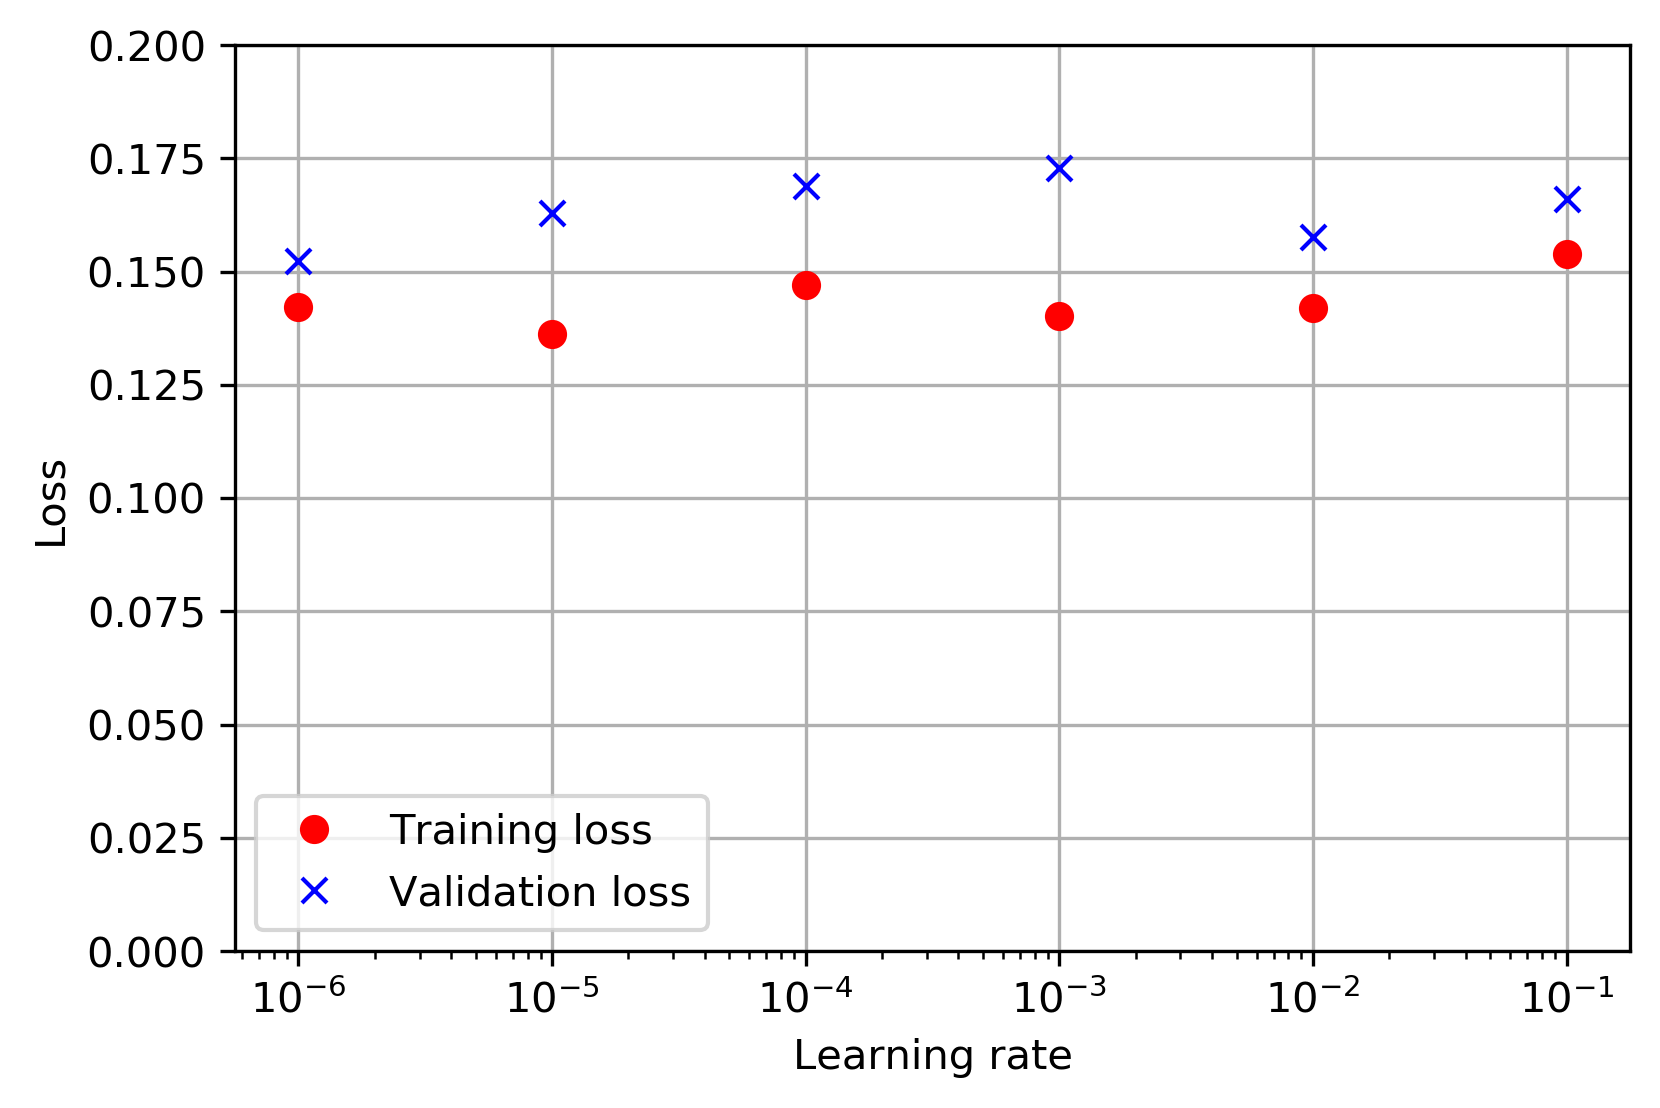

In [98]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(levels, trainLoss,'ro',label="Training loss")
ax.semilogx(levels, valLoss,'bx',label="Validation loss")
ax.legend()
ax.grid()
ax.set_xlabel("Learning rate")
ax.set_ylabel("Loss")
ax.set_ylim([0,.2])
plt.savefig('learning_rate.png', dpi=300)

## PCA

In [53]:
pca = PCA(n_components = 5)
X2D = pca.fit_transform(X)

rmse = np.zeros(4)
var_ratio = np.zeros((4,4))
for _ in range(4): 
    pca = PCA(n_components=_+1, svd_solver="randomized")
    U = pca.fit_transform(X)
    V_recovered = pca.inverse_transform(U)
    rmse[_] = np.sqrt(np.mean((X-V_recovered)**2))

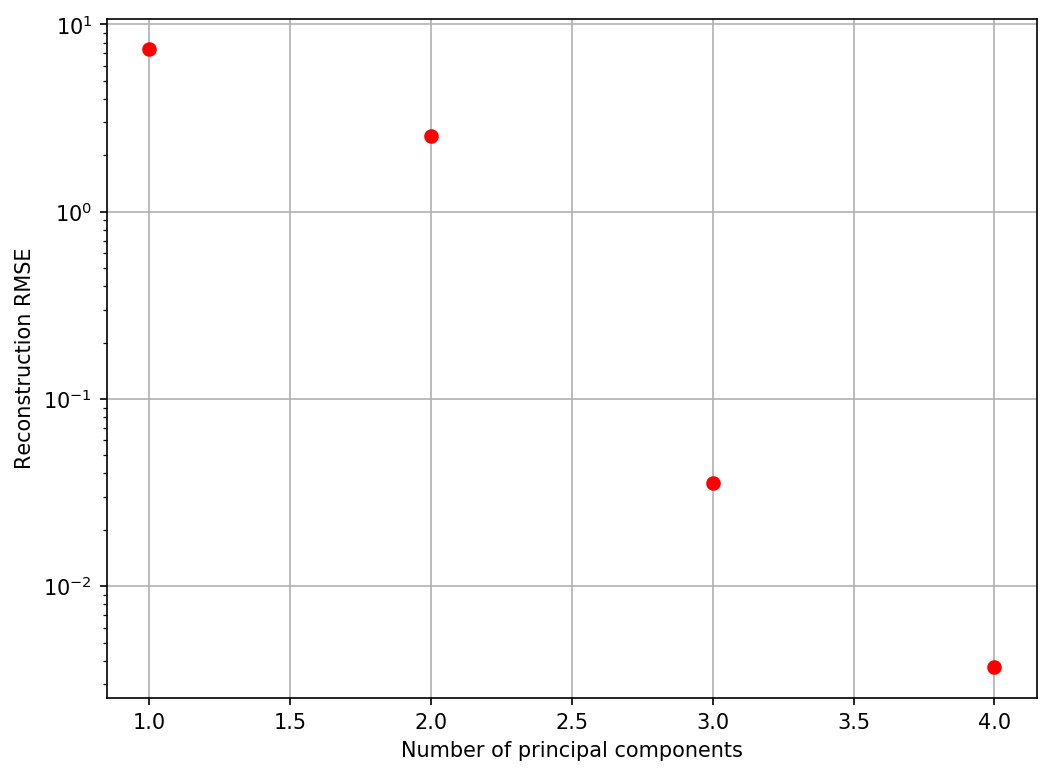

In [57]:
fig = plt.figure(figsize=[8,6], dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.semilogy(np.arange(1,5,1),rmse,'ro')
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Reconstruction RMSE')
ax.grid()
plt.savefig('pca.png')